### Objetivo deste trabalho

O presente trabalho visa fornecer uma visão geral do aprendizado de máquina usando a linguagem Python e um banco de dados real do Hospital Sírio-Libanês no Brasil. A base de dados contém dados de monitoramento de saúde de pacientes em diferentes janelas de eventos e sua eventual evolução para a unidade de terapia intensiva (UTI).

Alguns dos métodos e funções das diferentes bibliotecas utilizadas serão brevemente descritos. No entanto, alguns podem não ser tão claros para o leitor que não está familiarizado com o tema. Algumas fontes de consulta serão fornecidas também.

### Contexto e enunciado do problema

A pandemia covid-19 assola o mundo desde o início de 2020, lotando hospitais e resultando em escassez de recursos.

Pensando nesse problema, no primeiro semestre daquele ano, uma equipe médica do hospital Sírio-Libanês disponibilizou um banco de dados na plataforma Kaggle sobre a ocupação de leitos de unidade de terapia intensiva (UTI) por pacientes com diagnóstico de covid.

Sabe-se que os sistemas de saúde podem ser um recurso escasso em tempos de pandemia; portanto, poder prever se um paciente ocupará ou não um leito em UTI pode ser um forte aliado na estruturação de planos de combate à doença, considerando os recursos limitados em termos de equipe médica e infraestrutura hospitalar.

O objetivo final é fazer previsões sobre o número de leitos a serem ocupados num futuro próximo (horas) afim de evitar o colapso do sistema de saúde sobrecarregando a capacidade hospitalar em termos de leitos de UTI, recursos humanos e equipamentos de proteção individual.

#### Importando as bibliotécas necessárias

In [1]:
from matplotlib.patches import Rectangle
from sklearn.metrics import recall_score
from sklearn.metrics import f1_score
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import RepeatedStratifiedKFold

In [2]:
import pandas as pd
import numpy as np
from sklearn import preprocessing
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
from sklearn.feature_selection import chi2
from sklearn.feature_selection import SelectKBest

In [3]:
from sklearn.model_selection import cross_validate
from sklearn.tree import DecisionTreeClassifier
from sklearn.tree import export_graphviz
from sklearn.externals.six import StringIO
from IPython.display import Image
import pydotplus

In [4]:
from sklearn.metrics import accuracy_score
from sklearn.dummy import DummyClassifier
from sklearn.metrics import plot_confusion_matrix
from sklearn.ensemble import RandomForestClassifier

## Análise exploratória de dados (EDA) parte I:

### Carregando e explorando o banco de dados

In [5]:
data = pd.read_excel("https://github.com/renato-favarin/Kaggle_Sirio_Libanes_ICU_Prediction/blob/main/database/Kaggle_Sirio_Libanes_ICU_Prediction.xlsx?raw=true")

Conhecendo os dados em termos de features e amostras

In [6]:
data.head(n=10)

,PATIENT_VISIT_IDENTIFIER,AGE_ABOVE65,AGE_PERCENTIL,GENDER,DISEASE GROUPING 1,DISEASE GROUPING 2,DISEASE GROUPING 3,DISEASE GROUPING 4,DISEASE GROUPING 5,DISEASE GROUPING 6,...,TEMPERATURE_DIFF,OXYGEN_SATURATION_DIFF,BLOODPRESSURE_DIASTOLIC_DIFF_REL,BLOODPRESSURE_SISTOLIC_DIFF_REL,HEART_RATE_DIFF_REL,RESPIRATORY_RATE_DIFF_REL,TEMPERATURE_DIFF_REL,OXYGEN_SATURATION_DIFF_REL,WINDOW,ICU
0,0,1,60th,0,0.0,0.0,0.0,0.0,1.0,1.0,...,-1.000000,-1.000000,-1.000000,-1.000000,-1.000000,-1.000000,-1.000000,-1.000000,0-2,0
1,0,1,60th,0,0.0,0.0,0.0,0.0,1.0,1.0,...,-1.000000,-1.000000,-1.000000,-1.000000,-1.000000,-1.000000,-1.000000,-1.000000,2-4,0
2,0,1,60th,0,0.0,0.0,0.0,0.0,1.0,1.0,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,4-6,0
3,0,1,60th,0,0.0,0.0,0.0,0.0,1.0,1.0,...,-1.000000,-1.000000,NaN,NaN,NaN,NaN,-1.000000,-1.000000,6-12,0
4,0,1,60th,0,0.0,0.0,0.0,0.0,1.0,1.0,...,-0.238095,-0.818182,-0.389967,0.407558,-0.230462,0.096774,-0.242282,-0.814433,ABOVE_12,1
5,1,1,90th,1,0.0,0.0,0.0,0.0,0.0,0.0,...,-1.000000,-1.000000,-1.000000,-1.000000,-1.000000,-1.000000,-1.000000,-1.000000,0-2,1
6,1,1,90th,1,0.0,0.0,0.0,0.0,0.0,0.0,...,-1.000000,-1.000000,-1.000000,-1.000000,-1.000000,-1.000000,-1.000000,-1.000000,2-4,1
7,1,1,90th,1,0.0,0.0,0.0,0.0,0.0,0.0,...,-1.000000,-1.000000,-1.000000,-1.000000,-1.000000,-1.000000,-1.000000,-1.000000,4-6,1
8,1,1,90th,1,0.0,0.0,0.0,0.0,0.0,0.0,...,-0.880952,-1.000000,-0.906832,-0.831132,-0.940967,-0.817204,-0.882574,-1.000000,6-12,1
9,1,1,90th,1,0.0,0.0,0.0,0.0,1.0,0.0,...,0.142857,-0.797980,0.315690,0.200359,-0.239515,0.645161,0.139709,-0.802317,ABOVE_12,1


In [7]:
data.shape

(1925, 231)

#### Suma do conjunto de dados

Segundo os criadores do banco de dados (link kaggle na seção Introdução), o conjunto de dados contém dados anônimos do Hospital Sírio-Libanês, de São Paulo e de Brasília. Todos os dados foram tornados anônimos de acordo com as melhores práticas e recomendações internacionais. Os dados foram limpos e escalados por coluna para caber entre -1 e 1.

Como pode ser visto, existem mais de 230 colunas (
na parte inferior da célula acima, está escrito "10 linhas x 231 colunas) cada uma sendo uma característica como GÊNERO, GRUPO DE DOENÇA 1, TEMPERATURA_MEAN, OXYGEN_SATURATION_MIN, JANELA e o último, o" ICU ".
Tente rolar para a direita para ver todos esses recursos; como há muitas colunas no banco de dados, nem todas estão sendo mostradas.

A coluna PATIENT_VISIT_IDENTIFIER contém o identificador do paciente.
Existem 5 linhas para cada paciente; cada linha refere-se a uma janela de tempo, que pode ser visualizada no recurso JANELA, a partir do momento da admissão hospitalar e até "acima de 12 horas".

Após uma análise completa e detalhada das diferentes colunas, nota-se que as primeiras 13 colunas possuem dados categóricos e as demais, com exceção das duas últimas, são contínuas, que contêm informações momentâneas sobre a saúde do paciente.

Quanto às duas últimas colunas, já foi explicado a JANELA e com relação à UTI representa se, para a janela de tempo em questão, o paciente está (UTI = 1) ou não (UTI = 0) em unidade de terapia intensiva .

Portanto, a primeira questão que se coloca é: quantos pacientes há neste banco de dados? <br>
Podemos usar a propriedade * shape * para contar o número de linhas.

O banco de dados contém 1925 linhas; existem dados para 1925/5 = 385 pacientes.

Anteriormente, quando carregamos o banco de dados, notamos que havia valores com letras (strings) como * 60th * e * 90th * e também valores * NaN * (por exemplo, verifique os valores de ALBUMIN_MEDIAN acima) que significa "Não é um Número ", ou seja, são valores nulos.

Os algoritmos de aprendizado de máquina que usaremos realizam várias iterações numéricas, portanto, não podemos ter:

a) qualquer valor não numérico (NaN) <br> 
b) qualquer valor nulo

## Lidando com valores categóricos

Vamos começar com **(a)**. O código abaixo traz todas as colunas não numéricas do banco de dados.

In [8]:
data.select_dtypes(exclude=['int', 'float']).columns

Index(['PATIENT_VISIT_IDENTIFIER', 'AGE_ABOVE65', 'AGE_PERCENTIL', 'GENDER',
       'WINDOW', 'ICU'],
      dtype='object')

Vamos ver um exemplo dessas colunas:

In [9]:
cols = data.select_dtypes(exclude=['int', 'float']).columns
data[cols].sample(n=5)

,PATIENT_VISIT_IDENTIFIER,AGE_ABOVE65,AGE_PERCENTIL,GENDER,WINDOW,ICU
243,48,0,60th,0,6-12,1
1371,274,1,70th,1,2-4,0
1805,361,0,20th,0,0-2,0
727,145,1,Above 90th,1,4-6,0
813,162,0,30th,1,6-12,0


Existem letras com números na coluna AGE_PERCENTIL e a coluna WINDOW traz o intervalo de horas a que os dados de saúde pertencem; este será discutido mais tarde.

O primeiro, AGE_PERCENTIL, pode ser um fator importante na evolução do estado de saúde com covid-19; portanto, não podemos desconsiderar esses dados. Trataremos esses dados categóricos e os substituiremos por números.

In [10]:
# o pacote de pré-processamento fornece várias funções utilitárias comuns, incluindo LabelEnconder ()
# que é capaz de codificar rótulos de destino com valores entre 0 e n_classes-1
le = preprocessing.LabelEncoder()

# o método fit () "ensina" à ferramenta de pré-processamento quais são os valores que precisam ser convertidos - neste caso, # os valores da coluna "IDADE PERCENTIL"
le.fit(data.AGE_PERCENTIL)

# classes_ attribute mostra o rótulo para cada classe identificada
le.classes_

array(['10th', '20th', '30th', '40th', '50th', '60th', '70th', '80th',
       '90th', 'Above 90th'], dtype=object)

In [11]:
# de acordo com as classes identificadas, ou seja, para transformar rótulos em
# uma codificação normalizada

data["AGE_PERCENTIL"] = le.transform(data.AGE_PERCENTIL)

AGE_PERCENTIL atualizado, pós encoder:

In [12]:
data[["AGE_PERCENTIL", "WINDOW"]].sample(n=5)

,AGE_PERCENTIL,WINDOW
1550,8,0-2
1783,0,6-12
1118,9,6-12
669,4,ABOVE_12
732,3,4-6


Podemos ver claramente que o algoritmo transformou "Acima de 90º" na classe 9, "60º" na classe 5, "50º" na classe 4 e "10º" na classe 0; dessa forma, essa coluna está apta a ser trabalhada pelo algorítmo de aprendizado de máquina.

## Lidando com NaNs e Nulls

Agora é hora de **(b)**. Para entender quantos valores nulos existem em cada um dos recursos, podemos usar o método info()

In [13]:
data.isna().any()

PATIENT_VISIT_IDENTIFIER      False
AGE_ABOVE65                   False
AGE_PERCENTIL                 False
GENDER                        False
DISEASE GROUPING 1             True
                              ...  
RESPIRATORY_RATE_DIFF_REL      True
TEMPERATURE_DIFF_REL           True
OXYGEN_SATURATION_DIFF_REL     True
WINDOW                        False
ICU                           False
Length: 231, dtype: bool

In [14]:
pd.set_option('display.max_rows', None)

In [15]:
data.isna().sum()

PATIENT_VISIT_IDENTIFIER               0
AGE_ABOVE65                            0
AGE_PERCENTIL                          0
GENDER                                 0
DISEASE GROUPING 1                     5
DISEASE GROUPING 2                     5
DISEASE GROUPING 3                     5
DISEASE GROUPING 4                     5
DISEASE GROUPING 5                     5
DISEASE GROUPING 6                     5
HTN                                    5
IMMUNOCOMPROMISED                      5
OTHER                                  5
ALBUMIN_MEDIAN                      1104
ALBUMIN_MEAN                        1104
ALBUMIN_MIN                         1104
ALBUMIN_MAX                         1104
ALBUMIN_DIFF                        1104
BE_ARTERIAL_MEDIAN                  1104
BE_ARTERIAL_MEAN                    1104
BE_ARTERIAL_MIN                     1104
BE_ARTERIAL_MAX                     1104
BE_ARTERIAL_DIFF                    1104
BE_VENOUS_MEDIAN                    1104
BE_VENOUS_MEAN  

### Porcentagem de NaNs por coluna

In [16]:
data.isna().sum() / data.shape[0] * 100

PATIENT_VISIT_IDENTIFIER             0.000000
AGE_ABOVE65                          0.000000
AGE_PERCENTIL                        0.000000
GENDER                               0.000000
DISEASE GROUPING 1                   0.259740
DISEASE GROUPING 2                   0.259740
DISEASE GROUPING 3                   0.259740
DISEASE GROUPING 4                   0.259740
DISEASE GROUPING 5                   0.259740
DISEASE GROUPING 6                   0.259740
HTN                                  0.259740
IMMUNOCOMPROMISED                    0.259740
OTHER                                0.259740
ALBUMIN_MEDIAN                      57.350649
ALBUMIN_MEAN                        57.350649
ALBUMIN_MIN                         57.350649
ALBUMIN_MAX                         57.350649
ALBUMIN_DIFF                        57.350649
BE_ARTERIAL_MEDIAN                  57.350649
BE_ARTERIAL_MEAN                    57.350649
BE_ARTERIAL_MIN                     57.350649
BE_ARTERIAL_MAX                   

In [17]:
data.info(null_counts=True,max_cols=231)

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1925 entries, 0 to 1924
Data columns (total 231 columns):
 #   Column                            Non-Null Count  Dtype  
---  ------                            --------------  -----  
 0   PATIENT_VISIT_IDENTIFIER          1925 non-null   int64  
 1   AGE_ABOVE65                       1925 non-null   int64  
 2   AGE_PERCENTIL                     1925 non-null   int32  
 3   GENDER                            1925 non-null   int64  
 4   DISEASE GROUPING 1                1920 non-null   float64
 5   DISEASE GROUPING 2                1920 non-null   float64
 6   DISEASE GROUPING 3                1920 non-null   float64
 7   DISEASE GROUPING 4                1920 non-null   float64
 8   DISEASE GROUPING 5                1920 non-null   float64
 9   DISEASE GROUPING 6                1920 non-null   float64
 10  HTN                               1920 non-null   float64
 11  IMMUNOCOMPROMISED                 1920 non-null   float64
 12  OTHER

Observe que apenas as primeiras 4 colunas (PATIENT_VISIT_IDENTIFIER, AGE_ABOVE65, AGE_PERCENTIL, GENDER) e as últimas 2 (WINDOW e ICU) possuem todas as 1925 colunas não nulas, ou seja, com valores preenchidos.

Além disso, observe que as colunas 4-12 contêm apenas 5 linhas com linhas nulas; este conjunto de dados provavelmente se refere a um único paciente. Voltaremos a essas 5 linhas que faltam em detalhes mais tarde.

No entanto, todas as outras colunas têm várias linhas nulas. Observe que a maioria das colunas não tem nem metade dos dados do paciente preenchidos, sempre apresentando exatamente 821 linhas com algum valor preenchido. Essas colunas referem-se aos dados momentâneos de saúde do paciente de uma janela de tempo específica; quando verificamos o nome dessas feições, a propriedade biológica / química se repete, mas o parâmetro é variado (MEDIAN, MEAN, MIN, MAX, DIFF); dado o número de linhas nessas colunas com exatamente o mesmo número de campos nulos, a questão é levantada: existem colunas no banco de dados que fornecem informações absolutamente idênticas para todos os diferentes pacientes? Ou, em outras palavras, existem colunas iguais?

Para responder a isso, podemos construir a primeira função deste trabalho. Se você deseja aprender mais sobre as funções do Python, você pode visitar este


[link](https://www.w3schools.com/python/python_functions.asp)

In [18]:
# Esta função recebe um dataframe e retorna a lista de colunas duplicadas

def getDuplicateColumns(df): 
    
    # define uma lista vazia para adicionar eventuais colunas duplicadas
    duplicate_columns = []
    
    # iterar em todas as colunas
    for x in range(df.shape[1]): 
        
        # pega a coluna no xº índice.
        column = df.iloc[:, x] 
        
        # itera através de todas as colunas do (x + 1) º índice ao último índice
        for y in range(x + 1, df.shape[1]): 
              
        # pegue a coluna no índice "i".
            other_column = df.iloc[:, y] 
              
           # verifique se duas colunas no índice x e y são iguais ou não
            # se for igual, então adicione à lista            
            if column.equals(other_column): 
                duplicate_columns.append(df.columns.values[y])
    
    # retorna uma lista de nomes de colunas exclusivos cujos conteúdos são duplicados.
    unique_duplicate_columns = list(dict.fromkeys(duplicate_columns))
    
    return unique_duplicate_columns

Once the function is set, we can use it:

In [19]:
# chamando a função recém-criada
duplicate_columns = getDuplicateColumns(data)

duplicate_columns

['ALBUMIN_MEAN',
 'ALBUMIN_MIN',
 'ALBUMIN_MAX',
 'BE_ARTERIAL_DIFF',
 'BE_VENOUS_DIFF',
 'BIC_ARTERIAL_DIFF',
 'BIC_VENOUS_DIFF',
 'BILLIRUBIN_DIFF',
 'BLAST_DIFF',
 'CALCIUM_DIFF',
 'CREATININ_DIFF',
 'FFA_DIFF',
 'GGT_DIFF',
 'GLUCOSE_DIFF',
 'HEMATOCRITE_DIFF',
 'HEMOGLOBIN_DIFF',
 'INR_DIFF',
 'LACTATE_DIFF',
 'LEUKOCYTES_DIFF',
 'LINFOCITOS_DIFF',
 'NEUTROPHILES_DIFF',
 'P02_ARTERIAL_DIFF',
 'P02_VENOUS_DIFF',
 'PC02_ARTERIAL_DIFF',
 'PC02_VENOUS_DIFF',
 'PCR_DIFF',
 'PH_ARTERIAL_DIFF',
 'PH_VENOUS_DIFF',
 'PLATELETS_DIFF',
 'POTASSIUM_DIFF',
 'SAT02_ARTERIAL_DIFF',
 'SAT02_VENOUS_DIFF',
 'SODIUM_DIFF',
 'TGO_DIFF',
 'TGP_DIFF',
 'TTPA_DIFF',
 'UREA_DIFF',
 'DIMER_DIFF',
 'BE_ARTERIAL_MEAN',
 'BE_ARTERIAL_MIN',
 'BE_ARTERIAL_MAX',
 'BE_VENOUS_MEAN',
 'BE_VENOUS_MIN',
 'BE_VENOUS_MAX',
 'BIC_ARTERIAL_MEAN',
 'BIC_ARTERIAL_MIN',
 'BIC_ARTERIAL_MAX',
 'BIC_VENOUS_MEAN',
 'BIC_VENOUS_MIN',
 'BIC_VENOUS_MAX',
 'BILLIRUBIN_MEAN',
 'BILLIRUBIN_MIN',
 'BILLIRUBIN_MAX',
 'BLAST_MEAN',
 'B

In [20]:
len(duplicate_columns)

143

In [21]:
# como foram identificadas muitas colunas duplicadas, vamos imprimir apenas os primeiros dez recursos
print("Amostra de 10 colunas duplicadas:")
print(duplicate_columns[:10])

print(f"\ n Número total de colunas duplicadas: {len (duplicate_columns)}")

Amostra de 10 colunas duplicadas:
['ALBUMIN_MEAN', 'ALBUMIN_MIN', 'ALBUMIN_MAX', 'BE_ARTERIAL_DIFF', 'BE_VENOUS_DIFF', 'BIC_ARTERIAL_DIFF', 'BIC_VENOUS_DIFF', 'BILLIRUBIN_DIFF', 'BLAST_DIFF', 'CALCIUM_DIFF']
\ n Número total de colunas duplicadas: 143


Como podemos ver, existem 143 colunas que mostram as mesmas informações de outras colunas. Neste momento, continuaremos utilizando todo o banco de dados, sabendo que temos informações duplicadas e posteriormente retornaremos a este tópico.

Ainda sobre a análise de colunas com valores nulos, é importante mencionar que a falta de valores preenchidos em bancos de dados no mundo da ciência de dados é bastante comum. Existem várias estratégias para lidar com essa situação.

Uma dessas estratégias é simplesmente livrar-se de qualquer linha com valores nulos; entretanto, esse banco de dados não parece ser grande o suficiente para prosseguirmos dessa forma sem afetar a representatividade dos dados, o que pode comprometer o algoritmo de aprendizado de máquina. Portanto, não faremos isso na primeira análise.

Outra abordagem, mesmo recomendada pelos autores do banco de dados, que são médicos, é considerar que as condições do paciente não variam significativamente de uma janela de tempo para outra. Nesse sentido, podemos replicar, para cada paciente individual, os dados de suas janelas anteriores. **Porém essa premissa deverá ser checada em um segundo momento da análise pós-aplicação do algorítmo.**

Para isso, podemos criar outra função, que primeiro agrupa os dados por paciente e, em seguida, executa um preenchimento para frente (preenchimento) seguido por um preenchimento posterior (preenchimento) apenas para as colunas que se referem aos dados de saúde do paciente momentâneos de uma janela de tempo específica. Lembre-se de que as colunas 4-12 também apresentam valores nulos, mas como apresentam dados categóricos, discutiremos isso mais tarde.

In [22]:
momentary_health_data_columns = data.iloc[:,13:-2].columns


momentary_health_data_filled = data.groupby("PATIENT_VISIT_IDENTIFIER", 
                                         as_index=False)[momentary_health_data_columns].\
                                         fillna(method="ffill").fillna(method="bfill")

categorical = data.iloc[:,:13]

window_icu = data.iloc[:,-2:]


In [23]:
filled_data = pd.concat([categorical,momentary_health_data_filled,window_icu],ignore_index=False,axis=1)

filled_data.head()

,PATIENT_VISIT_IDENTIFIER,AGE_ABOVE65,AGE_PERCENTIL,GENDER,DISEASE GROUPING 1,DISEASE GROUPING 2,DISEASE GROUPING 3,DISEASE GROUPING 4,DISEASE GROUPING 5,DISEASE GROUPING 6,...,TEMPERATURE_DIFF,OXYGEN_SATURATION_DIFF,BLOODPRESSURE_DIASTOLIC_DIFF_REL,BLOODPRESSURE_SISTOLIC_DIFF_REL,HEART_RATE_DIFF_REL,RESPIRATORY_RATE_DIFF_REL,TEMPERATURE_DIFF_REL,OXYGEN_SATURATION_DIFF_REL,WINDOW,ICU
0,0,1,5,0,0.0,0.0,0.0,0.0,1.0,1.0,...,-1.000000,-1.000000,-1.000000,-1.000000,-1.000000,-1.000000,-1.000000,-1.000000,0-2,0
1,0,1,5,0,0.0,0.0,0.0,0.0,1.0,1.0,...,-1.000000,-1.000000,-1.000000,-1.000000,-1.000000,-1.000000,-1.000000,-1.000000,2-4,0
2,0,1,5,0,0.0,0.0,0.0,0.0,1.0,1.0,...,-1.000000,-1.000000,-1.000000,-1.000000,-1.000000,-1.000000,-1.000000,-1.000000,4-6,0
3,0,1,5,0,0.0,0.0,0.0,0.0,1.0,1.0,...,-1.000000,-1.000000,-1.000000,-1.000000,-1.000000,-1.000000,-1.000000,-1.000000,6-12,0
4,0,1,5,0,0.0,0.0,0.0,0.0,1.0,1.0,...,-0.238095,-0.818182,-0.389967,0.407558,-0.230462,0.096774,-0.242282,-0.814433,ABOVE_12,1


In [24]:
def fillTable(data):

    # extrai as informações das colunas que representam os dados momentâneos 
    # de saúde do paciente
    momentary_health_data_columns = data.iloc[:,13:-2].columns

    # aplica preenchimento para frente seguido de preenchimento para trás apenas para essas colunas
    momentary_health_data_filled = data.groupby("PATIENT_VISIT_IDENTIFIER", 
                                         as_index=False)[momentary_health_data_columns].\
                                         fillna(method="ffill").fillna(method="bfill")

    # para retornar um novo banco de dados, é necessário reconstruí-lo
    # primeiro é necessário extrair os mesmos dados categóricos do
    # dados originais
    categorical_data_original = data.iloc[:,:13]

    # então é necessário extrair os dados da janela e ICU (últimas 2 colunas)
    window_ICU_data_original = data.iloc[:,-2:]

    # com os 3 conjuntos de dados, é possível reconstruir o mesmo banco de dados
    # estrutura, desta vez com as colunas de dados de saúde momentâneas preenchidas
    filled_data = pd.concat([categorical_data_original,
                             momentary_health_data_filled, 
                             window_ICU_data_original], 
                            ignore_index=True, axis=1)
    
    # renomeie as colunas com seus nomes originais
    filled_data.columns = data.columns
    
    return filled_data

Como pode ser visto na célula abaixo, as colunas que costumavam aparecer como * NaN * agora são preenchidas com seus valores vizinhos.

In [25]:
filled_data = fillTable(data)
filled_data.head(10)

,PATIENT_VISIT_IDENTIFIER,AGE_ABOVE65,AGE_PERCENTIL,GENDER,DISEASE GROUPING 1,DISEASE GROUPING 2,DISEASE GROUPING 3,DISEASE GROUPING 4,DISEASE GROUPING 5,DISEASE GROUPING 6,...,TEMPERATURE_DIFF,OXYGEN_SATURATION_DIFF,BLOODPRESSURE_DIASTOLIC_DIFF_REL,BLOODPRESSURE_SISTOLIC_DIFF_REL,HEART_RATE_DIFF_REL,RESPIRATORY_RATE_DIFF_REL,TEMPERATURE_DIFF_REL,OXYGEN_SATURATION_DIFF_REL,WINDOW,ICU
0,0,1,5,0,0.0,0.0,0.0,0.0,1.0,1.0,...,-1.000000,-1.000000,-1.000000,-1.000000,-1.000000,-1.000000,-1.000000,-1.000000,0-2,0
1,0,1,5,0,0.0,0.0,0.0,0.0,1.0,1.0,...,-1.000000,-1.000000,-1.000000,-1.000000,-1.000000,-1.000000,-1.000000,-1.000000,2-4,0
2,0,1,5,0,0.0,0.0,0.0,0.0,1.0,1.0,...,-1.000000,-1.000000,-1.000000,-1.000000,-1.000000,-1.000000,-1.000000,-1.000000,4-6,0
3,0,1,5,0,0.0,0.0,0.0,0.0,1.0,1.0,...,-1.000000,-1.000000,-1.000000,-1.000000,-1.000000,-1.000000,-1.000000,-1.000000,6-12,0
4,0,1,5,0,0.0,0.0,0.0,0.0,1.0,1.0,...,-0.238095,-0.818182,-0.389967,0.407558,-0.230462,0.096774,-0.242282,-0.814433,ABOVE_12,1
5,1,1,8,1,0.0,0.0,0.0,0.0,0.0,0.0,...,-1.000000,-1.000000,-1.000000,-1.000000,-1.000000,-1.000000,-1.000000,-1.000000,0-2,1
6,1,1,8,1,0.0,0.0,0.0,0.0,0.0,0.0,...,-1.000000,-1.000000,-1.000000,-1.000000,-1.000000,-1.000000,-1.000000,-1.000000,2-4,1
7,1,1,8,1,0.0,0.0,0.0,0.0,0.0,0.0,...,-1.000000,-1.000000,-1.000000,-1.000000,-1.000000,-1.000000,-1.000000,-1.000000,4-6,1
8,1,1,8,1,0.0,0.0,0.0,0.0,0.0,0.0,...,-0.880952,-1.000000,-0.906832,-0.831132,-0.940967,-0.817204,-0.882574,-1.000000,6-12,1
9,1,1,8,1,0.0,0.0,0.0,0.0,1.0,0.0,...,0.142857,-0.797980,0.315690,0.200359,-0.239515,0.645161,0.139709,-0.802317,ABOVE_12,1


De qualquer forma é bom checar se tem NaNs o novo dataframe

In [26]:
filled_data.isna().any()

PATIENT_VISIT_IDENTIFIER            False
AGE_ABOVE65                         False
AGE_PERCENTIL                       False
GENDER                              False
DISEASE GROUPING 1                   True
DISEASE GROUPING 2                   True
DISEASE GROUPING 3                   True
DISEASE GROUPING 4                   True
DISEASE GROUPING 5                   True
DISEASE GROUPING 6                   True
HTN                                  True
IMMUNOCOMPROMISED                    True
OTHER                                True
ALBUMIN_MEDIAN                      False
ALBUMIN_MEAN                        False
ALBUMIN_MIN                         False
ALBUMIN_MAX                         False
ALBUMIN_DIFF                        False
BE_ARTERIAL_MEDIAN                  False
BE_ARTERIAL_MEAN                    False
BE_ARTERIAL_MIN                     False
BE_ARTERIAL_MAX                     False
BE_ARTERIAL_DIFF                    False
BE_VENOUS_MEDIAN                  

In [27]:
filled_data.isna().any()[13:]

ALBUMIN_MEDIAN                      False
ALBUMIN_MEAN                        False
ALBUMIN_MIN                         False
ALBUMIN_MAX                         False
ALBUMIN_DIFF                        False
BE_ARTERIAL_MEDIAN                  False
BE_ARTERIAL_MEAN                    False
BE_ARTERIAL_MIN                     False
BE_ARTERIAL_MAX                     False
BE_ARTERIAL_DIFF                    False
BE_VENOUS_MEDIAN                    False
BE_VENOUS_MEAN                      False
BE_VENOUS_MIN                       False
BE_VENOUS_MAX                       False
BE_VENOUS_DIFF                      False
BIC_ARTERIAL_MEDIAN                 False
BIC_ARTERIAL_MEAN                   False
BIC_ARTERIAL_MIN                    False
BIC_ARTERIAL_MAX                    False
BIC_ARTERIAL_DIFF                   False
BIC_VENOUS_MEDIAN                   False
BIC_VENOUS_MEAN                     False
BIC_VENOUS_MIN                      False
BIC_VENOUS_MAX                    

Agora é hora de lembrar que, além das colunas que representam as condições de saúde do paciente, havia colunas categóricas que também continham 5 linhas com dados nulos. Essas colunas não foram incluídas na função, portanto, não se espera que tenham sido preenchidas, vamos visualizar isso.

In [28]:
# lista todas as colunas que contêm dados nulos
filled_data.columns[filled_data.isna().any()].tolist()

['DISEASE GROUPING 1',
 'DISEASE GROUPING 2',
 'DISEASE GROUPING 3',
 'DISEASE GROUPING 4',
 'DISEASE GROUPING 5',
 'DISEASE GROUPING 6',
 'HTN',
 'IMMUNOCOMPROMISED',
 'OTHER']

Como vimos antes, como havia apenas 5 linhas faltando para essas colunas, podemos simplesmente nos livrar delas, elas não farão tanta diferença.

In [29]:
# remove todas as linhas com dados nulos
new_filled_data = filled_data.dropna()

Finalmente, para confirmar que as 5 linhas ausentes nesses dados categóricos eram de um único paciente (para evitar possíveis impactos nos próximos algoritmos de aprendizado de máquina), podemos contar o número de pacientes que temos agora no banco de dados.

In [30]:
print("Número de pacientes da variável 'new_filled_data':")
len(new_filled_data.groupby("PATIENT_VISIT_IDENTIFIER").count().index)

Número de pacientes da variável 'new_filled_data':


384

Como agora temos 384 pacientes (antes eram 385), realmente as 5 linhas de dados categóricos ausentes eram do mesmo paciente.

Com o conjunto de dados sem mais valores nulos, devemos lembrar que o objetivo deste estudo é prever, com base nos dados de saúde, se determinado paciente necessitará ou não de UTI; portanto, neste estudo, não podemos ter pacientes que chegam ao hospital e são encaminhados imediatamente diretamente para a UTI porque todos os seus dados de saúde - para todas as janelas de tempo - desse (desses) pacientes já estão se referindo àquele tipo de tratamento.

O mesmo raciocínio será usado quando formos treinar nossos algoritmos de aprendizado de máquina; não podemos usar dados de pacientes que já estão na UTI, isso colocaria um viés no modelo.

Essa premissa é tão importante que até mesmo um alerta - em forma de figura - foi feito pelos criadores do conjunto de dados:

! [] (https://raw.githubusercontent.com/renato-favarin/Kaggle_Sirio_Libanes_ICU_Prediction/main/images/ICU_use_data.jpg)

Para realizar essa limpeza final crucial do banco de dados, há o seguinte código:

In [31]:
new_filled_data.ICU.dtype

dtype('int64')

In [32]:
patient_to_remove = new_filled_data[(new_filled_data.WINDOW == '0-2') & (new_filled_data.ICU == 1)]['PATIENT_VISIT_IDENTIFIER']

In [33]:
machine_learning_data = new_filled_data.query('PATIENT_VISIT_IDENTIFIER not in @patient_to_remove')

In [34]:
# this array ('patient_to_remove') armazena todos os pacientes cuja primeira janela (0-2 horas)
# já é 1 para UTI.
patient_to_remove = new_filled_data.query("WINDOW =='0-2' and ICU == 1")["PATIENT_VISIT_IDENTIFIER"].values

# cria um novo dataframe sem o 'patient_to_remove'
# o caractere @ aqui marca um nome de variável em vez de um nome de coluna
machine_learning_data = new_filled_data.query("PATIENT_VISIT_IDENTIFIER not in @patient_to_remove")

In [35]:
print("Número de pacientes do DataFrame 'machine_learning_data':")
len(machine_learning_data.groupby("PATIENT_VISIT_IDENTIFIER").count().index)

Número de pacientes do DataFrame 'machine_learning_data':


352

Com os dados de 352 pacientes temos a primeira versão do conjunto de dados pronta para ser utilizada em algoritmos de aprendizado de máquina que visam cumprir nosso objetivo. Mas primeiro, vamos aprofundar nossa análise exploratória de dados.

## Análise exploratória de dados (EDA) parte II:  
### Estudo das features mais correlacionadas com a presença ou ausência de um paciente na UTI

## Análise de proporções

Durante esta sessão, traçaremos alguns gráficos; para evitar scripts duplicados, devemos definir uma função dedicada a este propósito.

In [36]:
def plotGraph(data, title, x, type, y_limit = None, y=None, labels = None):
  # tema do gráfico, definição de estilo e fonte
  sns.set_theme(style = "darkgrid", font='serif', font_scale = 1.4)

  # tipo de gráfico e seus parâmetros
  if type == "bar":
    ax = sns.countplot(data = data,x=x)
  
  if type == "box":
    ax = sns.boxplot(data =data, x = x, y=y)
    
  if type == "dist":
    ax = sns.distplot(data =data, x = x, y=y)

  # tamanho do gráfico dependendo do seu tipo
  if type == "bar":
    ax.figure.set_size_inches(7,7)
  
  if type == "box":
    ax.figure.set_size_inches(5,5)

  if type == "dist":
    ax.figure.set_size_inches(5,5)        
    
  # título (o \ n é para criar uma lacuna extra entre o título e a figura)
  ax.set_title(title + "\n")

  # desativar rótulo y ("contagem")
  ax.set(ylabel=None)

  # configurações de rótulo x (rótulos x_tick, desabilitar rótulo x e definir o limite)
  ax.set_xticklabels(["No ICU (0)", "ICU (1)"])
  ax.set(xlabel=None)
  
  if y_limit != None:
    ax.set_ylim(top=y_limit)

  # para adicionar os rótulos sobre as barras
  if labels == True:
    for rect in ax.patches:
        
      # encontre os valores de cada barra
      height = rect.get_height()
      width = rect.get_width()
      x = rect.get_x()
      y = rect.get_y()
    
      # texto do rótulo é exatamente sua altura
      label_text = f'{height}'
    
      # parâmetros xey do rótulo (o 0,02 * y_limit em label_y é para se ajustar melhor na fig.)
      label_x = x + width / 2
      label_y = height + (0.02*y_limit)

      # plotar o rótulo se a altura for diferente de zero
      if height != 0:
        ax.text(label_x, label_y, label_text, ha='center', va='center', fontsize=15)

    plt.show(ax)

Agora é possível plotar usando uma única linha de código, apenas chamando a função.

Para entender quantas janelas de tempo dos diferentes pacientes estão relacionadas aos tratamentos na UTI, podemos traçar o gráfico abaixo

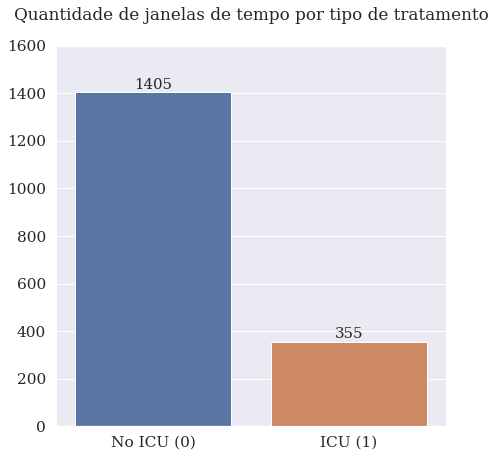

In [37]:
# "title" é um dos parâmetros necessários para a função plotGraph
title = "Quantidade de janelas de tempo por tipo de tratamento"

plotGraph(data = machine_learning_data, type = "bar", title = title, x="ICU", y_limit = 1600, labels=True)

In [38]:
# No entanto, este gráfico não leva em consideração o número de pacientes que apresentam pelo menos uma janela de tempo em tratamento na UTI. Para obter isso, podemos usar o seguinte código:

# O método groupby () é aplicado à identificação do paciente seguido pela função agregada que retorna o valor máximo para o recurso "ICU"
# Que por sua vez é seguido pelo método value_counts () que conta a quantidade para os 2 valores "ICU" possíveis: 0 e 1.

machine_learning_data.groupby("PATIENT_VISIT_IDENTIFIER").agg({"ICU": max}).value_counts()

ICU
0      189
1      163
dtype: int64

In [39]:
machine_learning_data.groupby("PATIENT_VISIT_IDENTIFIER").max().ICU.value_counts()

0    189
1    163
Name: ICU, dtype: int64

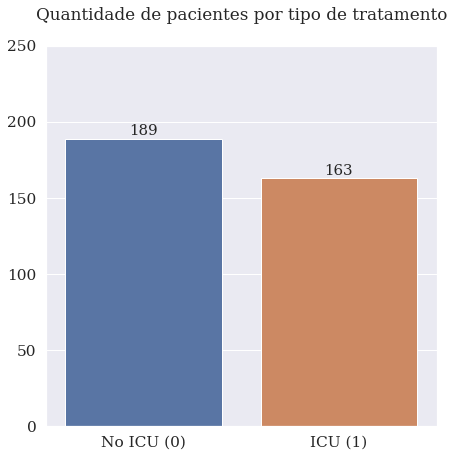

In [40]:
# Também podemos traçar o código acima:
title = "Quantidade de pacientes por tipo de tratamento"
plotGraph(data = machine_learning_data.groupby("PATIENT_VISIT_IDENTIFIER").agg({"ICU": max}), type = "bar", title = title, x="ICU", y_limit=250, labels = True)

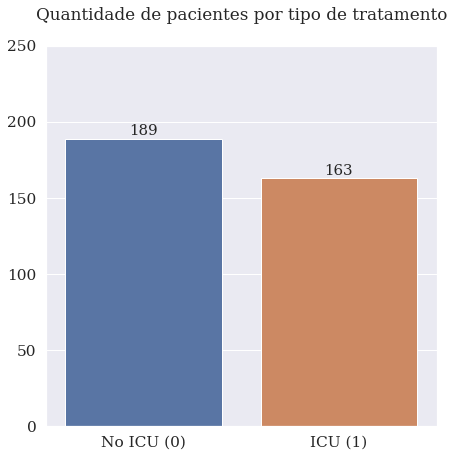

In [41]:
# Também podemos traçar o código acima:
title = "Quantidade de pacientes por tipo de tratamento"
plotGraph(data = machine_learning_data.groupby("PATIENT_VISIT_IDENTIFIER").agg({"ICU": max}), type = "bar", title = title, x="ICU", y_limit=250, labels = True)

Como se pode verificar, quase metade dos pacientes do banco de dados elaborado, em alguma janela de tempo, foi encaminhada à UTI.

## Análise de correlação

Outra análise que podemos fazer é listar as maiores correlações de Pearson entre os diversos recursos e a variável "UTI"; dessa forma, podemos identificar características com alto potencial para serem vinculadas a um paciente que vai ou não ao tratamento na UTI.

Como as correlações podem ser diretas (positivas) e inversas (negativas), ambas as listas classificadas são mostradas.

In [42]:
# o parâmetro "método" deve indicar qual tipo de correlação (neste caso, Pearson)

machine_learning_data_corr = machine_learning_data.corr()["ICU"]
machine_learning_data_corr.sort_values(ascending = False)

ICU                                 1.000000
RESPIRATORY_RATE_MAX                0.570316
RESPIRATORY_RATE_DIFF               0.551715
RESPIRATORY_RATE_DIFF_REL           0.545261
BLOODPRESSURE_SISTOLIC_DIFF         0.467795
BLOODPRESSURE_SISTOLIC_DIFF_REL     0.461163
BLOODPRESSURE_DIASTOLIC_DIFF_REL    0.430419
BLOODPRESSURE_DIASTOLIC_DIFF        0.419989
HEART_RATE_DIFF_REL                 0.419885
HEART_RATE_DIFF                     0.419293
TEMPERATURE_DIFF_REL                0.410746
TEMPERATURE_DIFF                    0.409567
BLOODPRESSURE_SISTOLIC_MAX          0.359339
RESPIRATORY_RATE_MEAN               0.309588
OXYGEN_SATURATION_DIFF_REL          0.307223
OXYGEN_SATURATION_DIFF              0.306366
RESPIRATORY_RATE_MEDIAN             0.266532
HEART_RATE_MAX                      0.264105
AGE_PERCENTIL                       0.246674
BE_VENOUS_MIN                       0.246501
BE_VENOUS_MEAN                      0.246501
BE_VENOUS_MEDIAN                    0.246501
BE_VENOUS_

In [43]:
# Os recursos com a correlação negativa mais alta (indicando que quanto mais alto,
# menor a frequencia do UTI = 1, validando a internação)

machine_learning_data_corr.sort_values(ascending = True)

BLOODPRESSURE_DIASTOLIC_MIN        -0.412856
LACTATE_MEAN                       -0.323185
LACTATE_MAX                        -0.323185
LACTATE_MIN                        -0.323185
LACTATE_MEDIAN                     -0.323185
TEMPERATURE_MIN                    -0.319998
OXYGEN_SATURATION_MIN              -0.272579
BLOODPRESSURE_DIASTOLIC_MEDIAN     -0.248020
HEART_RATE_MIN                     -0.244031
BLOODPRESSURE_DIASTOLIC_MEAN       -0.237768
BLOODPRESSURE_SISTOLIC_MIN         -0.212231
ALBUMIN_MAX                        -0.209462
ALBUMIN_MIN                        -0.209462
ALBUMIN_MEAN                       -0.209462
ALBUMIN_MEDIAN                     -0.209462
HEMOGLOBIN_MAX                     -0.202906
HEMOGLOBIN_MEDIAN                  -0.202906
HEMOGLOBIN_MEAN                    -0.202906
HEMOGLOBIN_MIN                     -0.202906
HEMATOCRITE_MAX                    -0.182940
HEMATOCRITE_MIN                    -0.182940
HEMATOCRITE_MEAN                   -0.182940
HEMATOCRIT

Observe que não há nenhuma característica altamente correlacionada com o fato de o paciente ir ou não para a unidade de terapia intensiva; parece ser uma combinação "sinérgica" de muitas variáveis umas com as outras, que resulta na necessidade de um paciente ir (ou não) para a UTI. Em análises complexas como essa, os algoritmos de aprendizado de máquina podem ajudar muito.

Ainda na análise de correlação, também podemos identificar alguns valores de NaN; se olharmos para a equação de correlação de Pearson, entendemos que a única maneira possível de resultar em valores NaN é ter o denominador igual a zero; para isso, o desvio padrão de qualquer característica deve ser zero e, por conseqüência, seus valores devem ser sempre os mesmos, visto que o desvio padrão de uma série com valores iguais é zero.

São 36 características diferentes que apresentam correlação do NaN com a coluna “UTI”, como podemos observar a seguir.

In [44]:
corr_null = machine_learning_data_corr[machine_learning_data_corr.isna()].index
print(f"Número total de recursos que apresentam correlação NaN com o recurso 'ICU': {len(corr_null)} ")
print(corr_null)

Número total de recursos que apresentam correlação NaN com o recurso 'ICU': 36 
Index(['ALBUMIN_DIFF', 'BE_ARTERIAL_DIFF', 'BE_VENOUS_DIFF',
       'BIC_ARTERIAL_DIFF', 'BIC_VENOUS_DIFF', 'BILLIRUBIN_DIFF', 'BLAST_DIFF',
       'CALCIUM_DIFF', 'CREATININ_DIFF', 'FFA_DIFF', 'GGT_DIFF',
       'GLUCOSE_DIFF', 'HEMATOCRITE_DIFF', 'HEMOGLOBIN_DIFF', 'INR_DIFF',
       'LACTATE_DIFF', 'LEUKOCYTES_DIFF', 'LINFOCITOS_DIFF',
       'NEUTROPHILES_DIFF', 'P02_ARTERIAL_DIFF', 'P02_VENOUS_DIFF',
       'PC02_ARTERIAL_DIFF', 'PC02_VENOUS_DIFF', 'PCR_DIFF',
       'PH_ARTERIAL_DIFF', 'PH_VENOUS_DIFF', 'PLATELETS_DIFF',
       'POTASSIUM_DIFF', 'SAT02_ARTERIAL_DIFF', 'SAT02_VENOUS_DIFF',
       'SODIUM_DIFF', 'TGO_DIFF', 'TGP_DIFF', 'TTPA_DIFF', 'UREA_DIFF',
       'DIMER_DIFF'],
      dtype='object')


Se tomarmos alguns exemplos dessas colunas, veremos que elas têm um valor único (neste caso, "-1"). Portanto, essas colunas também são repetidas entre si.

In [45]:
print(machine_learning_data["ALBUMIN_DIFF"].value_counts())
print("\n") # to print an empty row
print(machine_learning_data["GLUCOSE_DIFF"].value_counts())
print("\n")
print(machine_learning_data["POTASSIUM_DIFF"].value_counts())

-1.0    1760
Name: ALBUMIN_DIFF, dtype: int64


-1.0    1760
Name: GLUCOSE_DIFF, dtype: int64


-1.0    1760
Name: POTASSIUM_DIFF, dtype: int64


Provavelmente, a maioria dessas colunas já está listada na variável * duplicate_columns * que foi criada antes; o script abaixo lista qualquer uma dessas colunas que eventualmente não estão presentes na lista * duplicate_columns *.

In [46]:
for col in corr_null:
    if col not in duplicate_columns:
        print(f"A {col} não está entre as colunas duplicadas")

A ALBUMIN_DIFF não está entre as colunas duplicadas


Como podemos ver, o primeiro recurso da lista (ALBUMIN_DIFF) é o único que não está presente na lista * duplicated_columns *; a explicação para isso é porque o estudo que foi feito anteriormente preservou a primeira coluna da série repetida, então era realmente esperado que exatamente uma unidade de coluna com valores repetidos não fizesse parte da lista * duplicate_columns *.

Para o estudo do aprendizado de máquina sabe-se que colunas com o mesmo valor não agregam valor e podem ser removidas. Por enquanto, vamos apenas adicioná-lo à lista de * colunas duplicadas * (mais tarde removeremos essas colunas do banco de dados).

In [47]:
duplicate_columns.append("ALBUMIN_DIFF")

## Estudos das características mais correlacionadas com a UTI

Vamos trabalhar um pouco mais no estudo das variáveis correlacionadas

In [48]:
# o "~" é comandar o oposto, neste caso, todas as linhas que não são NaN
machine_learning_data_corr_no_nan = machine_learning_data_corr[~machine_learning_data_corr.isna()]

Podemos escolher algumas características diferentes das variáveis mais correlacionadas com a UTI:

In [49]:
# As 20 variáveis mais diretamente correlacionadas são

machine_learning_data_corr_no_nan.sort_values(ascending = False)[0:20]

ICU                                 1.000000
RESPIRATORY_RATE_MAX                0.570316
RESPIRATORY_RATE_DIFF               0.551715
RESPIRATORY_RATE_DIFF_REL           0.545261
BLOODPRESSURE_SISTOLIC_DIFF         0.467795
BLOODPRESSURE_SISTOLIC_DIFF_REL     0.461163
BLOODPRESSURE_DIASTOLIC_DIFF_REL    0.430419
BLOODPRESSURE_DIASTOLIC_DIFF        0.419989
HEART_RATE_DIFF_REL                 0.419885
HEART_RATE_DIFF                     0.419293
TEMPERATURE_DIFF_REL                0.410746
TEMPERATURE_DIFF                    0.409567
BLOODPRESSURE_SISTOLIC_MAX          0.359339
RESPIRATORY_RATE_MEAN               0.309588
OXYGEN_SATURATION_DIFF_REL          0.307223
OXYGEN_SATURATION_DIFF              0.306366
RESPIRATORY_RATE_MEDIAN             0.266532
HEART_RATE_MAX                      0.264105
AGE_PERCENTIL                       0.246674
BE_VENOUS_MIN                       0.246501
Name: ICU, dtype: float64

In [50]:
# Variáveis mais inversamente correlacionadas

machine_learning_data_corr_no_nan.sort_values(ascending = True)[0:20]

BLOODPRESSURE_DIASTOLIC_MIN      -0.412856
LACTATE_MEAN                     -0.323185
LACTATE_MAX                      -0.323185
LACTATE_MIN                      -0.323185
LACTATE_MEDIAN                   -0.323185
TEMPERATURE_MIN                  -0.319998
OXYGEN_SATURATION_MIN            -0.272579
BLOODPRESSURE_DIASTOLIC_MEDIAN   -0.248020
HEART_RATE_MIN                   -0.244031
BLOODPRESSURE_DIASTOLIC_MEAN     -0.237768
BLOODPRESSURE_SISTOLIC_MIN       -0.212231
ALBUMIN_MAX                      -0.209462
ALBUMIN_MIN                      -0.209462
ALBUMIN_MEAN                     -0.209462
ALBUMIN_MEDIAN                   -0.209462
HEMOGLOBIN_MAX                   -0.202906
HEMOGLOBIN_MEDIAN                -0.202906
HEMOGLOBIN_MEAN                  -0.202906
HEMOGLOBIN_MIN                   -0.202906
HEMATOCRITE_MAX                  -0.182940
Name: ICU, dtype: float64

Vamos escolher 8 variáveis, evitando aqueles que possuem "diferentes" por não serem medidas absolutas.
Também,

In [51]:
features_list = ["RESPIRATORY_RATE_MAX","BLOODPRESSURE_DIASTOLIC_MIN",
                 "BLOODPRESSURE_SISTOLIC_MIN","TEMPERATURE_MIN",
                 "HEART_RATE_MAX","OXYGEN_SATURATION_MIN", "AGE_PERCENTIL"]

Agora que temos essas variáveis em nossa lista, traçaremos o valor exibido desses dados de saúde, comparando o valor mostrado na primeira janela fora da UTI com a primeira janela já na UTI.

In [52]:
# Esse df é composto apenas pelas primeiras linhas de UTI = 0 e UTI = 1 por 
# paciente
# Com isso, podemos traçar o universo do estado de saúde dos pacientes quando 
# eles estão na UTI em comparação com quando estão fora dela.

box_plot_data = machine_learning_data.drop_duplicates(subset=["PATIENT_VISIT_IDENTIFIER","ICU"], keep='first')

In [53]:
features_list = ["RESPIRATORY_RATE_MAX","BLOODPRESSURE_DIASTOLIC_MIN",
                 "BLOODPRESSURE_SISTOLIC_MIN","TEMPERATURE_MIN",
                 "HEART_RATE_MAX","OXYGEN_SATURATION_MIN", "AGE_PERCENTIL"]

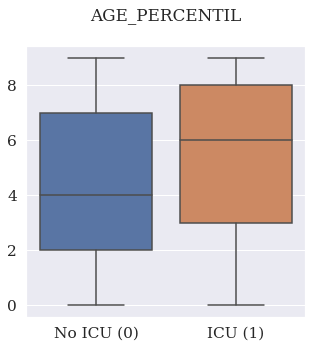

In [54]:
plotGraph(data = box_plot_data, title = features_list[6] , x = "ICU", y=features_list[6], type="box")

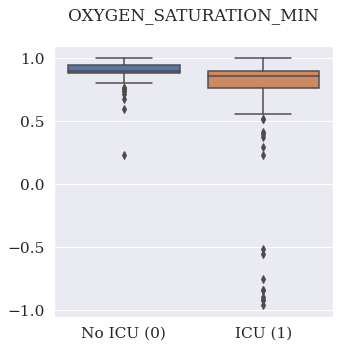

In [55]:
plotGraph(data = box_plot_data, title = features_list[5] , x = "ICU", y=features_list[5], type="box")

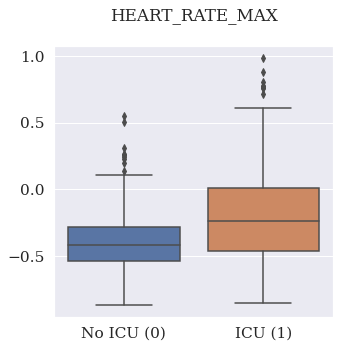

In [56]:
plotGraph(data = box_plot_data, title = features_list[4] , x = "ICU", y=features_list[4], type="box")

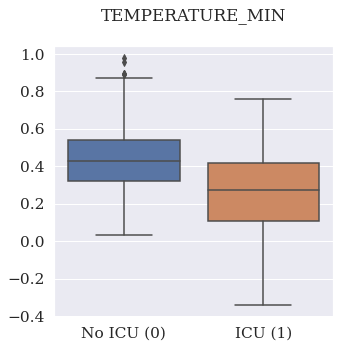

In [57]:
plotGraph(data = box_plot_data, title = features_list[3] , x = "ICU", y=features_list[3], type="box")

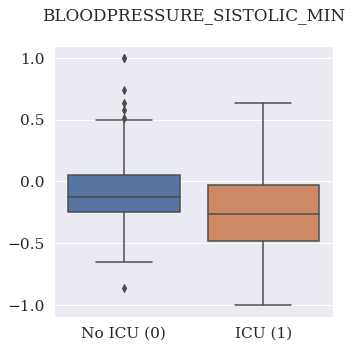

In [58]:
plotGraph(data = box_plot_data, title = features_list[2] , x = "ICU", y=features_list[2], type="box")

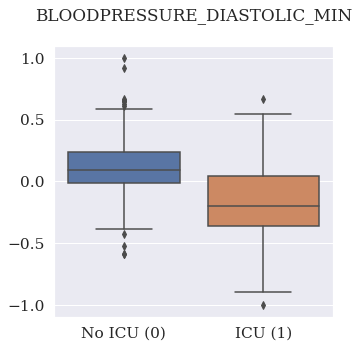

In [59]:
plotGraph(data = box_plot_data, title = "BLOODPRESSURE_DIASTOLIC_MIN", x = "ICU", y='BLOODPRESSURE_DIASTOLIC_MIN', type="box")

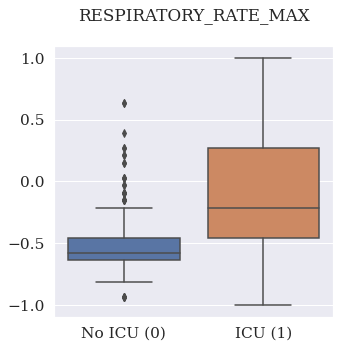

In [60]:
plotGraph(data = box_plot_data, title = "RESPIRATORY_RATE_MAX", x = "ICU", y="RESPIRATORY_RATE_MAX", type="box")

In [61]:
# for feature in features_list:
#   plotGraph(data = box_plot_data, title = feature, x = "ICU", y=feature, type="box")
#   print("\n")

Para variáveis como RESPIRATORY_RATE_MAX, BLOODPRESSURE_DIASTOLIC_MIN, TEMPERATURE_MIN E OXYGEN_SATURATION_MIN
as diferenças nos valores obtidos em pacientes dentro e fora da UTI são bastante acentuadas.

A princípio pode não ser óbvio o motivo pelo qual fora da UTI a temperatura mínima dos pacientes é maior do que dentro da UTI; sabe-se que a febre alta é um dos principais sintomas da covid-19; entretanto, as temperaturas mais baixas observadas para pacientes em unidades de terapia intensiva podem ser devidas à administração de medicamentos para controlar a temperatura, que as reduzem consideravelmente.

Quando plotamos a variável TEMPERATURE_MAX, observamos que os valores mais altos são de fato em pacientes de UTI.

C:\Users\Dell\anaconda3\envs\DataScienceMeigarom\lib\site-packages\seaborn\distributions.py:2551: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)


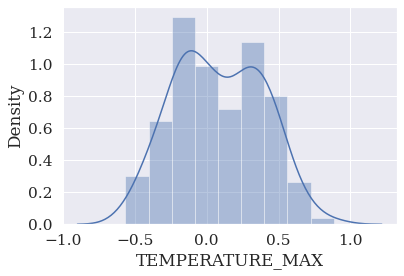

In [62]:
sns.distplot(box_plot_data.loc[box_plot_data.ICU == 1,'TEMPERATURE_MAX']);

C:\Users\Dell\anaconda3\envs\DataScienceMeigarom\lib\site-packages\seaborn\distributions.py:2551: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)


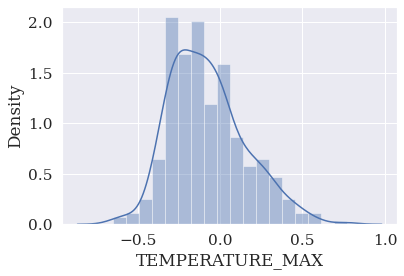

In [63]:
sns.distplot(box_plot_data.loc[box_plot_data.ICU == 0,'TEMPERATURE_MAX']);

C:\Users\Dell\anaconda3\envs\DataScienceMeigarom\lib\site-packages\seaborn\distributions.py:2551: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)


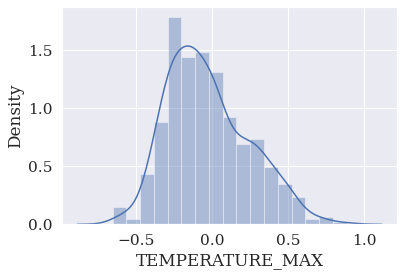

In [64]:
sns.distplot(a=box_plot_data['TEMPERATURE_MAX']);

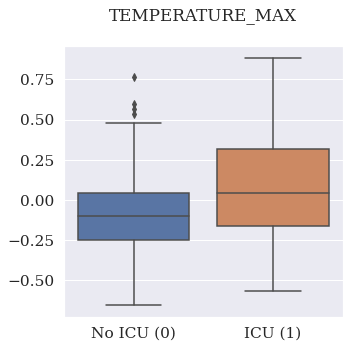

In [65]:
plotGraph(data = box_plot_data, title = "TEMPERATURE_MAX", x = "ICU", y="TEMPERATURE_MAX", type="box")

Com isso, finalizamos a segunda parte da EDA; eles nos ajudarão a ter critérios na definição e ajustes dos modelos de aprendizado de máquina que serão empregados.

Agora é hora de aplicar o primeiro modelo de aprendizado de máquina.

# Preparação do primeiro modelo de aprendizado de máquina

Os autores da base de dados que propuseram o desafio em kaggle, recomendam o seguinte:

> Quanto mais cedo, melhor! A identificação precoce dos pacientes que desenvolverão um curso adverso da doença (e precisam de cuidados intensivos) é a chave para um tratamento adequado (salvar vidas) e para gerenciar leitos e recursos. <br>
Dicas e truques: Considerando que um modelo preditivo usando todas as janelas de tempo provavelmente produzirá uma maior precisão, um bom modelo usando apenas o primeiro (0-2) provavelmente será mais clinicamente relevante.

Assumiremos a premissa de utilizar apenas os valores da primeira janela para prever se, em qualquer outra janela, o paciente irá ou não para a UTI.

Será criada uma função para analisar se o paciente vai ou não para a UTI em alguma janela. Se isso acontecer, um novo recurso chamado "ANY_WINDOW_IN_ICU" receberá 1, caso contrário, o valor será 0.

In [66]:
def getAnyICU_WINDOW(dataframe_agrupado):    
    #dataframe_agrupado.reset_index(drop=True, inplace=True)    
    
    if(np.any(dataframe_agrupado["ICU"])):
        # se o paciente agrupado tiver algum valor ICU == 1 irá ser considerado os valores da primeira janela
        # a linha abaixo identifica a linha da primeira janela e a coluna do ICU (que está 0) e modifica - apenas esta "célula" com o valor de 1
        dataframe_agrupado.loc[dataframe_agrupado["WINDOW"] == "0-2", "ICU"] = 1
    
    # o retorno é apenas a linha da janela 0-2
    new_df = dataframe_agrupado.loc[dataframe_agrupado["WINDOW"]=="0-2"]

    # remove a variável WINDOW (todos eles agora são "0-2")
    new_df.drop(columns = "WINDOW", inplace=True)

    # renomear o recurso UTI (agora é um indicativo do paciente presença ou não na UTI)
    new_df.rename(columns={"ICU": "ANY_WINDOW_IN_ICU"},inplace=True)
    return new_df

Agora aplicaremos a função definida acima.

In [67]:
# como estamos alterando o banco de dados, é importante criar uma cópia do dataframe original preparado usando o método copy ()
first_approach_machine_learning = machine_learning_data.copy()

# aplique a função no método groupby ()
first_approach_machine_learning = first_approach_machine_learning.groupby("PATIENT_VISIT_IDENTIFIER").apply(getAnyICU_WINDOW)

# o dataframe retornado contém um índice múltiplo que será retirado
first_approach_machine_learning.reset_index(drop = True, inplace=True)

# e então é possível definir um único índice, neste caso o "PATIENT_VISIT_IDENTIFIER"
first_approach_machine_learning.set_index("PATIENT_VISIT_IDENTIFIER", inplace=True)

Percebe-se que o dataframe resultante apresenta uma linha por paciente e com o novo recurso ANY_WINDOW_IN_ICU devidamente classificado, conforme o paciente vai ou não para a UTI. Esse novo recurso é a meta da aprendizagem supervisionada que estamos prestes a estabelecer.

CONFIRMAR QUE APRENDIZADO SUPERVISIONADO FOI CITADO ANTES

In [68]:
first_approach_machine_learning.head()

,AGE_ABOVE65,AGE_PERCENTIL,GENDER,DISEASE GROUPING 1,DISEASE GROUPING 2,DISEASE GROUPING 3,DISEASE GROUPING 4,DISEASE GROUPING 5,DISEASE GROUPING 6,HTN,...,RESPIRATORY_RATE_DIFF,TEMPERATURE_DIFF,OXYGEN_SATURATION_DIFF,BLOODPRESSURE_DIASTOLIC_DIFF_REL,BLOODPRESSURE_SISTOLIC_DIFF_REL,HEART_RATE_DIFF_REL,RESPIRATORY_RATE_DIFF_REL,TEMPERATURE_DIFF_REL,OXYGEN_SATURATION_DIFF_REL,ANY_WINDOW_IN_ICU
PATIENT_VISIT_IDENTIFIER,,,,,,,,,,,,,,,,,,,,,
0,1,5,0,0.0,0.0,0.0,0.0,1.0,1.0,0.0,...,-1.000000,-1.000000,-1.000000,-1.000000,-1.000000,-1.000000,-1.000000,-1.000000,-1.000000,1
2,0,0,0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,-0.764706,-1.000000,-0.959596,-0.515528,-0.351328,-0.747001,-0.756272,-1.000000,-0.961262,1
3,0,3,1,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,-1.000000,-1.000000,-1.000000,-1.000000,-1.000000,-1.000000,-1.000000,-1.000000,-1.000000,0
4,0,0,0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,-0.882353,-0.952381,-0.979798,-1.000000,-0.883669,-0.956805,-0.870968,-0.953536,-0.980333,0
5,0,0,0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,-1.000000,-0.976190,-0.979798,-0.860870,-0.714460,-0.986481,-1.000000,-0.975891,-0.980129,0


Antes de começar, é necessário separar o recurso de destino das outras variáveis.

Pensando cartesiano sobre o algoritmo de aprendizado de máquina ser uma função, temos os pontos de entrada "x" e a saída "y". Portanto, a saída y é a variável de destino.

In [69]:
# input 
x = first_approach_machine_learning.drop(["ANY_WINDOW_IN_ICU"], axis=1)

# output (target)
y = first_approach_machine_learning["ANY_WINDOW_IN_ICU"]

Queremos que nosso algoritmo receba dados históricos para aprender padrões e também para testar os padrões aprendidos.

Para continuar, é necessário dividir o banco de dados em "base de treinamento" e "base de teste"; o primeiro é usado para ajustar ("ensinar") o algoritmo e o segundo é usado para testar sua eficácia.

O código abaixo executa esta tarefa de divisão; neste momento, vamos começar com uma amostra de teste contendo 30% do banco de dados.

In [70]:
# o parâmetro de tamanho de teste é escolher a porcentagem do banco de dados
# que é usado para testar o modelo
x_train, x_test, y_train, y_test = train_test_split(x, y, test_size=0.3)

Um ponto muito importante de atenção, especialmente em conjuntos de dados pequenos, é a estratificação do banco de dados de teste / treinamento; se o número de pacientes que vão para a UTI na base de treinamento for muito diferente da base de teste, o modelo pode não ser treinado adequadamente.

A divisão atualmente ocupada tem quase 44% dos pacientes da base de treinamento indo para a UTI, enquanto na base de teste isso ocorre para quase 52%.

Vale destacar que, de acordo com a distribuição da base original, esse valor gira em torno de 46%.

In [71]:
print("Database (train) distribution:")
print(y_train.value_counts(normalize=True).sort_index(ascending=True))
print("\nDatabase (test) distribution:")
print(y_test.value_counts(normalize=True).sort_index(ascending=True))
print("\n\n Database (original) distribution")
print(y.value_counts(normalize=True).sort_index(ascending=True))

Database (train) distribution:
0    0.544715
1    0.455285
Name: ANY_WINDOW_IN_ICU, dtype: float64

Database (test) distribution:
0    0.518868
1    0.481132
Name: ANY_WINDOW_IN_ICU, dtype: float64


 Database (original) distribution
0    0.536932
1    0.463068
Name: ANY_WINDOW_IN_ICU, dtype: float64


Se você alterar o random.seed, a distribuição do banco de dados para treinamento e teste será diferente. Mas existe uma forma, independente da semente, de sempre balancear a divisão: podemos usar o parâmetro stratify, conforme o código abaixo.

In [72]:
# Estratificar pelo banco de dados original (simplesmente sendo o y original)
x_train, x_test, y_train, y_test = train_test_split(x, y, test_size=0.3, stratify=y)

print("Database (train) distribution:")
print(y_train.value_counts(normalize=True))
print("\nDatabase (test) distribution:")
print(y_test.value_counts(normalize=True))

Database (train) distribution:
0    0.536585
1    0.463415
Name: ANY_WINDOW_IN_ICU, dtype: float64

Database (test) distribution:
0    0.537736
1    0.462264
Name: ANY_WINDOW_IN_ICU, dtype: float64


Agora temos a mesma proporção em x_train / x_test na classe ANY_WINDOW_IN_ICU observada no conjunto de dados original.

### Classificador de árvore de decisão: parte I

O primeiro modelo que usaremos para prever se um paciente irá ou não para a UTI será feito usando um algoritmo de árvore de decisão.
Árvores de decisão são algoritmos de aprendizado de máquina versáteis que podem realizar
tarefas de classificação e regressão e até tarefas de várias saídas. Eles são
capaz de ajustar conjuntos de dados complexos.
Em uma árvore de decisão, existem dois nós, que são o nó de decisão e o nó folha; os primeiros são usados ​​para tomar qualquer decisão e podem resultar em outras ramificações, enquanto os nós folha são a saída dessas decisões e não contêm quaisquer ramificações adicionais.

! [] (https://raw.githubusercontent.com/renato-favarin/Kaggle_Sirio_Libanes_ICU_Prediction/main/images/Dec_Tree.jpg)

Você pode encontrar mais informações sobre esta técnica nas fontes destas informações:

- Aprendizado de máquina prático com Scikit-Learn, Keras & TensorFlow, Aurélien Géron;

- Decision Tree Classification Algorithm, por Javatpoint (https://www.javatpoint.com/machine-learning-decision-tree-classification-algorithm).

O código abaixo é importado da biblioteca sklearn e se ajusta ao classificador DecisionTree.

Observe que definimos a profundidade máxima da árvore. É importante restringir a liberdade do modelo para evitar que o algoritmo construa uma árvore gigante, muito especializada para os dados de treinamento (que é chamada de * overfit *); retornaremos a esse tópico na Árvore de Decisão, parte II.

In [73]:
# definição do modelo
tree_clf = DecisionTreeClassifier(max_depth=5)

print("O modelo e seus parâmetros: \n")

# ajustar ("ensinar") o modelo
tree_clf.fit(x_train, y_train)

O modelo e seus parâmetros: 



DecisionTreeClassifier(max_depth=5)

Também é possível visualizar a árvore criada utilizando o bloco de código abaixo.

In [74]:
dot_data = StringIO()
# export_graphviz(tree_clf, out_file=dot_data,filled=True,class_names=True)
# graph = pydotplus.graph_from_dot_data(dot_data.getvalue())  
# Image(graph.create_png())

Você pode verificar os 5 níveis de nós criados. Cada nó apresenta uma decisão sobre um recurso identificado pelo índice da coluna.
O primeiro nó é x [1], que é AGE_PERCENTIL; acima de 6,5 (na prática, igual ou maior que 7, já que não temos valores decimais para este recurso), existe uma ramificação com outro nó de decisão, desta vez para o recurso x [40], que é BILLIRUBIN_MAX; sabíamos também que a maior parte das folhas (embaixo) desse galho são referentes a pacientes que vão para a UTI (para a cor azul, que foi atribuída à classe 1).

Por outro lado, se o paciente tiver um AGE_PERCENTIL de 6 ou menos no primeiro nó, abre-se um novo ramo com nó de decisão para PCR_MEDIAN; desta vez notamos que a maior parte das licenças desse ramo são referentes a pacientes que não irão para a UTI (para a cor laranja, que foi atribuída à classe 0).

Você pode identificar o nome da coluna através do índice pelo código abaixo, simplesmente substituindo o número pelo índice desejado.

In [75]:
# digite qualquer índice dentro dos colchetes para revelar o nome da coluna
x_train.columns[1]

'AGE_PERCENTIL'

Agora podemos avaliar o modelo através do método precision_score; mas antes submetemos ao modelo o banco de dados x_test para rodar o modelo na árvore criada acima.

In [76]:
# execute o modelo com o banco de dados x_test
tree_clf_predict = tree_clf.predict(x_test)

# calcular a precisão, ou seja, a quantidade de pacientes que nosso modelo previu corretamente.
accuracy_score(y_test,tree_clf_predict)

0.6037735849056604

Como podemos ver, a árvore de decisão com aquele conjunto de treinamento especificado prevê corretamente mais de 66%.

Esse número, por si só, é difícil de interpretar.
Para entender melhor, vamos criar um modelo, denominado "dummy".

## Modelo fictício

Um modelo fictício pode ser basicamente uma estimativa aproximada; existem algumas estratégias para o modelo adivinhar o valor correto, mas usaremos uma estimativa puramente aleatória.
Como existem apenas dois valores possíveis em nossa meta (0 ou 1), provavelmente deve ser em torno de 50%; mas vamos confirmar.

As etapas necessárias para implementar este modelo são basicamente as mesmas do modelo de árvore de decisão: importar da biblioteca sklearn, fornecer uma semente, definir o modelo, ajustar o modelo e prever usando o modelo ajustado com o banco de dados x_test

In [77]:
dummy = DummyClassifier(strategy="uniform")
dummy.fit(x_train, y_train)
np.random.seed(1417643)
dummy_predict = dummy.predict(x_test)
accuracy_score(y_test,dummy_predict)

0.5094339622641509

Como esperado, a precisão do modelo simulado é de cerca de 50%.

O modelo da árvore de decisão, * aparentemente *, pode ser muito melhor do que uma estimativa completamente aleatória. 
A palavra "aparentemente" será explicada na próxima seção, onde explicaremos melhor sobre o desempenho dos modelos e descreveremos quais serão as métricas utilizadas para avaliá-los.

## Avaliação do modelo - matriz de confusão e definição de métricas de avaliação

A precisão é uma métrica de pontuação; no entanto, precisamos considerar os dois tipos de erros, porque eles podem afetar de forma diferente a
capacidade hospitalar e vida do paciente:

Falso positivo: quando nosso modelo considera 1 e o real é 0; ou seja, um paciente que não precisaria de um leito de UTI ocupará um; o impacto desse erro é aumentar desnecessariamente a carga de trabalho nas unidades de terapia intensiva, reduzindo recursos para quem realmente precisa.

Falso negativo: quando nosso modelo considera 0 e o real é 1; ou seja, um paciente que precisaria de um leito na UTI está sendo mandado para casa; o impacto desse erro é colocar em risco a vida do paciente, pois quando o paciente necessita da UTI, sua saúde pode piorar do que estaria se tivesse sido encaminhado para a UTI no momento adequado.

Existe uma tabela que permite visualizar o desempenho de um algoritmo em termos de falso positivo, falso negativo, verdadeiro positivo e verdadeiro negativo. É chamado de matriz de confusão.

A biblioteca sklearn (você já deve ter percebido como ela é incrível) também oferece essa métrica. Vamos ver a matriz de confusão para o modelo de árvore de decisão que foi definido anteriormente.

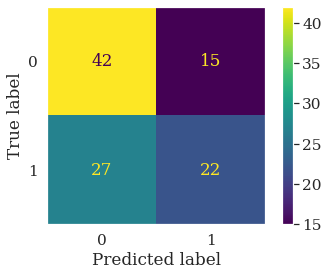

In [78]:
# carregue o pacote confused_matrix da biblioteca sklearn
plot_confusion_matrix(tree_clf, x_test, y_test)
plt.grid(False)
plt.show()

Como podemos ver, o modelo não está funcionando bem, principalmente para a taxa de falsos positivos.

Não precisamos nos preocupar, há muito o que fazer para melhorar esse modelo, como será feito ao longo deste trabalho.

Também é muito importante mencionar que este modelo é o resultado de apenas uma rodada de treinamento, baseada em uma divisão aleatória da amostra; em outras palavras: não significa nada, pois é apenas uma fotografia de uma simples amostra de uma longa cadeia de testes que deve ser feita antes de podermos avaliar o desempenho do modelo; esse é o motivo pelo qual a palavra "aproximadamente" foi usada durante a comparação da árvore de decisão e dos modelos dummy.

> P.S .: Se você quer entender a "sorte" que tivemos ao obter estes resultados, basta alterar o valor das sementes presentes nas células de divisão do banco de dados (em treinamento / teste) e também as sementes presentes nas células dos modelos.
Você verá uma árvore de decisão diferente, com desempenho muito diferente.


Voltando à matriz de confusão, podemos ver que dá muitas informações, mas às vezes é melhor uma métrica mais concisa.

A * precisão * e * recuperação * também são métricas boas e simples que podem funcionar para esse tipo de estudo.

A precisão é a precisão das previsões positivas e a recuperação é a proporção de instâncias positivas que são detectadas corretamente pelo classificador.

Freqüentemente, é conveniente combinar * precisão * e * rechamada * em uma única métrica chamada pontuação F1; é a média harmônica de * precisão * e * rechamada *

Lembremos o objetivo deste trabalho, que é evitar o colapso do sistema de saúde; isso é essencial para que seja possível salvar o maior número possível de vidas.

Considerando o pior cenário dos 2 tipos de erros:

  * Falso positivo: o paciente ocupava um leito de UTI que não precisaria ocupar e faltavam leitos para quem precisava, e o paciente sem leito de UTI acabou morrendo.

  * Falso negativo: o paciente foi para casa, seu estado de saúde piorou e ele faleceu.

No pior cenário, para os casos de falso positivo, ainda existe a chance de que não haja colapso do sistema de UTI e, com isso, não haja mais óbitos por causa desse erro.
Mas não podemos dizer isso sobre o erro de falso negativo.

Concluímos então que nosso objetivo é cometer o mínimo de erros possível; além disso, que os erros acabam penalizando mais a precisão do que o recall, pois entendemos que o pior cenário para falsos negativos é pior do que falsos positivos.

Assim, para avaliar o desempenho dos modelos, usaremos a métrica ** recall ** e o ** F1-score **, que inclui a precisão e o próprio recall, sendo muito sensível a qualquer valor baixo dessas métricas; para usá-los neste trabalho, vamos definir uma nova função.

In [79]:
def getMetrics(y_test, y_predict):
  
  recall = recall_score(y_test, y_predict)
  f1 = f1_score(y_test, y_predict)
  
  return recall, f1 

## Random Forest: parte I

O segundo modelo real que será usado é a floresta aleatória. Quando procuramos uma resposta para uma pergunta complexa e perguntamos a milhares e milhares de pessoas aleatórias e, em seguida, agregamos essas respostas, será possivelmente melhor (mas mais caro) do que a resposta de um especialista. Isso é chamado de sabedoria da multidão.

O mesmo conceito pode ser aplicado para preditores (famílias de algoritmos que buscam prever eventos futuros), incluindo a árvore de decisão recém-apresentada. O modelo de floresta aleatória, que é um conjunto (grupo de preditores), é um exemplo.

É possível ter um grupo de classificadores de árvore de decisão, cada um treinado em um subconjunto aleatório diferente do conjunto de treinamento. O modelo de floresta aleatório então obtém as previsões de todas as árvores individuais e prevê a classe que obtém mais votos

A figura abaixo à esquerda ilustra o que foi explicado e à direita um exemplo de classificador que identifica frutas em fotos.

! [] (https://github.com/renato-favarin/Kaggle_Sirio_Libanes_ICU_Prediction/blob/main/images/apple_banana.jpg?raw=true)

<br>
<br>

Você pode encontrar mais informações sobre esta técnica nas fontes destas informações:

- Aprendizado de máquina prático com Scikit-Learn, Keras & TensorFlow, Aurélien Géron;

- Random Forest Algorithm, por Javatpoint (https://www.javatpoint.com/machine-learning-random-forest-algorithm).

<br>

O código a seguir executa as mesmas etapas para o modelo de árvore de decisão.

In [80]:
# definição do modelo (max_depth foi definido de acordo com a árvore de decisão: parte I)
# o parâmetro n_estimators é o número de árvores
random_forest_clf = RandomForestClassifier(n_estimators=100, max_depth=5)

random_forest_clf.fit(x_train, y_train)

# execute o modelo com o banco de dados x_test
random_forest_clf_predict = random_forest_clf.predict(x_test)

# calcule as métricas deste modelo treinado conforme explicado anteriormente
recall_rf, f1_rf = getMetrics(y_test, random_forest_clf_predict)
print(f"Metrics obtained - Random forest \nRecall: {recall_rf}, F1-score: {f1_rf}")

Metrics obtained - Random forest 
Recall: 0.5510204081632653, F1-score: 0.5869565217391305


Ao comparar com o modelo de árvore de decisão, aparentemente o Random Forest realiza uma previsão melhor.

In [81]:
recall_dt, f1_dt = getMetrics(y_test, tree_clf_predict)
print(f"Métricas obtidas - árvore de decisão \n Recall: {recall_dt}, pontuação F1: {f1_dt}")

Métricas obtidas - árvore de decisão 
 Recall: 0.4489795918367347, pontuação F1: 0.5116279069767442


Para não esquecer o nosso modelo adivinhador puro, também calculamos as métricas obtidas

In [82]:
recall_dummy, f1_dummy = getMetrics(y_test, dummy_predict)
print(f"Métricas obtidas - modelo fictício \n Recall: {recall_dummy}, pontuação F1: {f1_dummy}")

Métricas obtidas - modelo fictício 
 Recall: 0.4897959183673469, pontuação F1: 0.48


Mas, novamente, não podemos concluir nada, pois é apenas uma comparação entre dois modelos treinados apenas uma vez usando os mesmos dados aleatórios e sem ajustar os parâmetros desses preditores.

Mais tarde iremos revisitar este modelo para melhorá-lo e de fato entender seu desempenho real.

## Regressão logística: parte I

O terceiro modelo que trabalharemos para esta tarefa de classificação é a regressão logística.

A regressão logística prevê a saída de uma variável dependente categórica. Portanto, o resultado deve ser um valor categórico ou discreto.
Pode ser Sim ou Não, 0 ou 1, Verdadeiro ou Falso etc; isso o torna um classificador binário.

O algoritmo, entretanto, em vez de fornecer o valor exato como 0 e 1, ele fornece os valores probabilísticos de que uma instância pertence a uma classe particular. Considerando o banco de dados deste trabalho, ele retornará a probabilidade de cada paciente ir à UTI. Se a probabilidade estimada for superior a 50%, o modelo prevê que a instância pertence a essa classe (ou seja, prevê que o paciente irá para a UTI).

A logística é uma função sigmóide (ou seja, em forma de S) que produz um número entre 0 e 1 e é representada pela figura abaixo.

! [] (https://github.com/renato-favarin/Kaggle_Sirio_Libanes_ICU_Prediction/blob/main/images/logistic_reg.jpg?raw=true)

Os círculos verdes pertencem à classe 0, pois suas probabilidades de serem classe 1 são inferiores a 50%; o oposto para círculos azuis.
<br>
<br>

Você pode encontrar mais informações sobre esta técnica nas fontes destas informações:

Aprendizado de máquina prático com Scikit-Learn, Keras & TensorFlow, Aurélien Géron;

Logistic Regression in Machine Learning, por Javatpoint (https://www.javatpoint.com/logistic-regression-in-machine-learning).

<br>

O código abaixo executa as etapas usuais aplicadas aos outros modelos.

In [83]:
np.random.seed(1417643)

log_reg_clf = LogisticRegression()

log_reg_clf.fit(x_train, y_train)

log_reg_clf_predict = log_reg_clf.predict(x_test)

recall_lr, f1_lr = getMetrics(y_test, log_reg_clf_predict)
print(f"Metrics obtained - Logistic regression \nRecall: {recall_lr}, F1-score: {f1_lr}")

Metrics obtained - Logistic regression 
Recall: 0.5102040816326531, F1-score: 0.5494505494505494


C:\Users\Dell\anaconda3\envs\DataScienceMeigarom\lib\site-packages\sklearn\linear_model\_logistic.py:763: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


De acordo com o aviso que foi gerado, entendemos que este modelo iterativo não terminou de convergir: * onvergenceWarning: lbfgs falhou em convergir (status = 1) *

Podemos modificar o parâmetro * max_iter *, que, por padrão, é 100.

In [84]:
log_reg_clf = LogisticRegression(max_iter=1000)

log_reg_clf.fit(x_train, y_train)
log_reg_clf_predict = log_reg_clf.predict(x_test)
recall_lr, f1_lr = getMetrics(y_test, log_reg_clf_predict)
print(f"Metrics obtained - Logistic regression \nRecall: {recall_lr}, F1-score: {f1_lr}")

Metrics obtained - Logistic regression 
Recall: 0.5102040816326531, F1-score: 0.5434782608695652


Notamos que agora o modelo convergiu e aparentemente teve um desempenho melhor.

## Recapitule o desempenho dos modelos da parte I

Foi ratificado algumas vezes que o desempenho dos modelos obtidos até agora foram obtidos como uma abordagem inicial, e que é necessário para poder avaliar o desempenho real do modelo.

Mesmo assim, para recapitular esses estudos de modelo (simples) até agora, criamos o seguinte quadro de dados.

In [85]:
# Criar um dataframe em um dicionário usando as variáveis de recall e f1 criadas anteriormente
scores_modelos_partI = pd.DataFrame({"Model":["Random forest", "Logistic regression","Decision tree classifier", "Dummy"],
                                     "Recall":[recall_rf, recall_lr, recall_dt, recall_dummy],
                                     "F1-score":[f1_rf,f1_lr,f1_dt,f1_dummy]})

# Criar um dataframe para manter esses resultados (exceto modelo fictício)
scores_models_full = scores_modelos_partI.drop(3)

# Cria uma coluna para identificar a origem desses resultados (ou seja, parte do desempenho)
scores_models_full["part #"] = "part I"

scores_modelos_partI.set_index('Model').rename_axis('').round(3)

,Recall,F1-score
,,
Random forest,0.551,0.587
Logistic regression,0.510,0.543
Decision tree classifier,0.449,0.512
Dummy,0.490,0.480


# Aprofundando o estudo de desempenho do modelo

Como, então, podemos saber o desempenho real do nosso modelo? É a pergunta natural neste ponto.

Uma forma de avaliar melhor o modelo é dividir o banco de dados, de maneiras diferentes, k vezes; cada vez usando k-1 conjuntos menores para treinar e o conjunto restante para testar até que cada amostra tenha a oportunidade de ser usada no conjunto de teste uma vez e usado no conjunto de treinamento k-1 vezes.

Este procedimento é denominado validação cruzada.

Existem muitos iteradores que são conhecidos por suas diferentes estratégias para realizar este procedimento. A importância de estratificar nosso banco de dados já foi explicada; então vamos fazer o mesmo para cada divisão; este iterador é denominado StratifiedKFold.

A figura abaixo ilustra esse método. Podem ser observadas 5 divisões diferentes, todas respeitando a estratificação da base original; observe que cada amostra é usada nos dados de teste 1 vez e usada para treinar o modelo k-1 vezes.

Observe que, para cada iteração, os dados no treinamento e no teste são alterados; no final some as pontuações de cada divisão e obtenha a pontuação média.

! [] (https://github.com/renato-favarin/Kaggle_Sirio_Libanes_ICU_Prediction/blob/main/images/cv_rev1.jpg?raw=true)

Mais informações podem ser obtidas no guia do usuário do scikit learn: https://scikit-learn.org/stable/modules/cross_validation.html#multimetric-cross-validation

Fonte da figura: Satish Gunjal https://satishgunjal.com/kfold/

Estamos prestes a iniciar a segunda rodada de aprendizado de máquina; vamos copiar o banco de dados que foi usado anteriormente.

In [86]:
# como estamos alterando o banco de dados, é importante criar uma cópia do dataframe original preparado usando o método copy ()
second_approach_machine_learning = first_approach_machine_learning.copy()

O código a seguir cria uma função que usa o procedimento de validação cruzada.

In [87]:
# importar a estratégia de divisão de validação cruzada, o RepeatedStratifiedKFold
# é uma variação do StratifiedKFold (explicado anteriormente), a diferença é
# que este pode ser executado várias vezes, o que aumenta o
# confiabilidade da pontuação média obtida

def runCrossValidation (model, data, n_splits, n_repeats):
  
  np.random.seed(1231234)

   # para pegar um dado aleatório (embaralhar), existe este truque de extrair
   # uma amostra de 100% do banco de dados
   # lembre-se: dados aleatórios são importantes para evitar enviesamento de dados inerente
  data = data.sample(frac=1).reset_index(drop=True)

  # input
  x = data.drop(["ANY_WINDOW_IN_ICU"], axis=1)

  # output (target)
  y = data["ANY_WINDOW_IN_ICU"]

   # definição da estratégia de validação cruzada
   # - o parâmetro "n_splits" é o número de dobras (k)
   # - o parâmetro "n_repeats" é o número de vezes que o validador cruzado precisa
   # ser repetido
  cv = RepeatedStratifiedKFold(n_splits = n_splits, n_repeats = n_repeats)

   # definição das pontuações; como foi explicado antes, as métricas são
   # recall e pontuação F1
  scoring = ['recall','f1']
  
   # definição do procedimento de validação cruzada
   # - o parâmetro "cv" é para indicar a estratégia que acabou de ser definida
   # - o "return_train_score" é usado para obter insights sobre como diferentes parâmetros
   # configurações afetam a compensação de overfitting / underfitting, como veremos em breve
  cv_results = cross_validate(model, x, y, cv = cv, scoring = scoring,  return_train_score=True)

  return cv_results

Assim que a função for ajustada, podemos usá-la. Mas primeiro, precisamos definir o valor para k, que é o número de dobras. Na primeira parte do treinamento dos modelos, usamos 30% da base de treinamento, que é aproximadamente 1/3 da base completa. Vamos manter essa proporção agora, usando k = 3.

Também é importante dizer que uma única execução da validação cruzada k-fold pode resultar em uma estimativa ruidosa do desempenho do modelo; divisões diferentes dos dados podem resultar em resultados muito diferentes; para evitar isso, repetiremos o processo 10 vezes.

Vamos executar a validação cruzada para o primeiro modelo que criamos, a árvore de decisão, mantendo o parâmetro max_depth usado na parte I (max_depth = 5).

## Classificador de árvore de decisão: parte II

In [88]:
tree_clf = DecisionTreeClassifier(max_depth=5)

tree_clf_cv = runCrossValidation(model = tree_clf, data = second_approach_machine_learning, n_splits=3, n_repeats=10)

recall_mean = np.mean(tree_clf_cv['test_recall'])
recall_std = np.std(tree_clf_cv['test_recall'])

f1_mean = np.mean(tree_clf_cv['test_f1'])
f1_std = np.std(tree_clf_cv['test_f1'])

# de acordo com a "regra 68–95–99,7" (https://en.wikipedia.org/wiki/68%E2%80%9395%E2%80%9399.7_rule),
# 95% dos valores estão dentro de dois desvios padrão da média
print(f"Recall (mean): {recall_mean:.3f}\n\
95% intervalo de confiança: {(recall_mean - (2 * recall_std)):.3f} - {(recall_mean + (2 * recall_std)):.3f}")

print(f"\nF1-score (mean): {f1_mean:.3f}\n\
95% F1-score intervalo de confiança:: {(f1_mean - (2 * f1_std)):.3f} - {(f1_mean + (2 * f1_std)):.3f}")

Recall (mean): 0.590
95% intervalo de confiança: 0.429 - 0.751

F1-score (mean): 0.616
95% F1-score intervalo de confiança:: 0.501 - 0.732


Agora, as informações de desempenho desse modelo são muito mais abrangentes, afinal, não estamos observando apenas uma única rodada de treinamento.

E por que não comparar um preditor com ele mesmo, mas usando diferentes hiperparâmetros?

Isso pode ser útil para ajustar o hiperparâmetro que melhor se ajusta à nossa base. No entanto, temos que ter cuidado com overfitting e underfitting:

Uma esplêndida definição de overfitting e underfitting pode ser lida no livro * Hands-on Machine Learning with Scikit-Learn, Keras & TensorFlow, de Aurélien Géron *
> Overfitting: supergeneralização  é algo que nós, humanos, fazemos com muita frequência e, infelizmente, as máquinas podem cair em uma armadilha parecida. No aprendizado de máquina o problema é chamado de overfitting: isso significa que o modelo tem um bom desempenho nos dados de treinamento, mas péssimo desempenho para outros conjuntos de dados, como os dados de teste. Há uma falta de generalização da solução criada pelo modelo.

> Underfitting: é o oposto de overfitting; ocorre quando o seu
modelo é muito simples para aprender a estrutura subjacente dos dados

Uma maneira de entender quando nosso modelo está superdimensionado é quando os dados de treinamento têm um desempenho excepcionalmente bom, geralmente às custas do teste de desempenho. Esta é a razão pela qual definimos "return_train_score = True" na função runCrossValidation.

Vamos simular a mesma árvore de decisão com 15 níveis de profundidade máxima.

In [89]:
# Definir max_depth variando de 1 a 15 (o último número no método - 16 - não está incluído)
max_depth = range(1,16)

# Definição de 4 listas para receber as pontuaç
test_scores_recall = []
test_scores_f1 = []
train_scores_recall = []
train_scores_f1 = []


# Realizar uma validação cruzada, com a mesma quantidade de dobras e repetições
# Definido anteriormente, mas variando o max_depth de 1 a 20
for i in max_depth:
  tree_clf = DecisionTreeClassifier(max_depth=i)
  tree_clf_cv = runCrossValidation(model = tree_clf, data = second_approach_machine_learning, n_splits=3, n_repeats=10)
  test_scores_recall.append(tree_clf_cv['test_recall'])
  test_scores_f1.append(tree_clf_cv['test_f1'])
  train_scores_recall.append(tree_clf_cv['train_recall'])
  train_scores_f1.append(tree_clf_cv['train_f1'])

# Para incluir todos os resultados em um dataframe para que possamos traçar seus valores
scores_list = [test_scores_recall, test_scores_f1, train_scores_recall, train_scores_f1]
scores_metric = ["Recall", "F1-score","Recall", "F1-score"]
scores_type = ["Test", "Test", "Train", "Train"]
decision_tree_scores = pd.DataFrame()

for i in range(4):
  scores_df = pd.DataFrame(scores_list[i]).T
  scores_df.columns = max_depth
  scores_df = scores_df.melt()
  scores_df.columns = ["max_depth", "score"]
  scores_df["score_metric"] = scores_metric[i]
  scores_df["score_type"] = scores_type[i]
  decision_tree_scores = pd.concat([decision_tree_scores,scores_df], ignore_index=True)

Como pode ser visto a seguir, temos os resultados para as diferentes métricas e tipos de pontuação (seja baseada em dados de teste ou treinamento).

In [90]:
decision_tree_scores

,max_depth,score,score_metric,score_type
0,1,0.254545,Recall,Test
1,1,0.351852,Recall,Test
2,1,0.333333,Recall,Test
3,1,0.327273,Recall,Test
4,1,0.240741,Recall,Test
5,1,0.370370,Recall,Test
6,1,0.490909,Recall,Test
7,1,0.629630,Recall,Test
8,1,0.277778,Recall,Test
9,1,0.218182,Recall,Test


Agora vamos representar graficamente as pontuações usando boxplot para observar o desempenho do teste e os dados de treinamento para a métrica de recall; como logo após traçaremos para a pontuação F1, criaremos uma função para que possamos reutilizar o código.

In [91]:
def plotScoresGraph(model, score_df, parameter_to_vary, score_metric, legend_bottom_right=False):

  # boxplot e seus parâmetros; observe o "hue = score_type", esta é a maneira como podemos comparar a mesma métrica (lembre-se)
  # obtido durante a execução com dados de teste e treinamento.
    ax = sns.boxplot(y="score", x=parameter_to_vary, data=score_df.query("score_metric==@score_metric"), hue="score_type")

  # obtenha o comprimento do eixo x para ajustar o tamanho da figura
    amount_xlabels = len(score_df[parameter_to_vary].value_counts().index)
  
    if amount_xlabels < 25:
        ax.figure.set_size_inches(24,8)
  
    if amount_xlabels < 20:
        ax.figure.set_size_inches(18,8)

    if amount_xlabels < 10:
        ax.figure.set_size_inches(12,8)

    if amount_xlabels < 5:
        ax.figure.set_size_inches(8,8)

  # adicionar colunas cinza claro para facilitar a visualização
    for i in range(0,amount_xlabels,2):
        ax.add_patch(Rectangle((i - 0.5, 0 - 0.5), 1, 2, facecolor="skyblue",alpha=0.25))
  
    ax.tick_params(direction="in", labeltop=True, bottom=True)

   # definição dos outros parâmetros do gráfico
    ax.set_xlabel("\n" + parameter_to_vary)
    ax.set_ylabel(score_metric + "\n")
    ax.set_title(model + " - " + score_metric + " evaluation\n")
    ax.set_ylim(0,1.1)

  # para alguns gráficos, a legenda deve estar à direita
    if legend_bottom_right == True:
        ax.legend(loc='lower right', frameon=False, ncol=2)
    else:
        ax.legend(loc='lower left', frameon=False, ncol=2)
  
  # ativa a grade vertical para facilitar a comparação entre diferentes max_depth
    ax.xaxis.grid(True)

    ax;

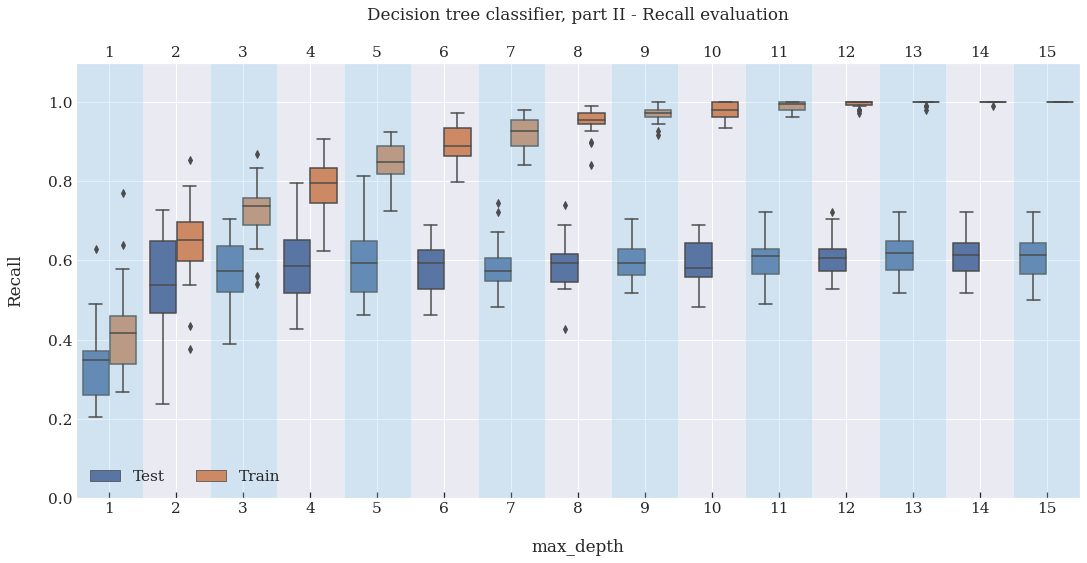

In [92]:
plotScoresGraph("Decision tree classifier, part II",decision_tree_scores, "max_depth", "Recall")

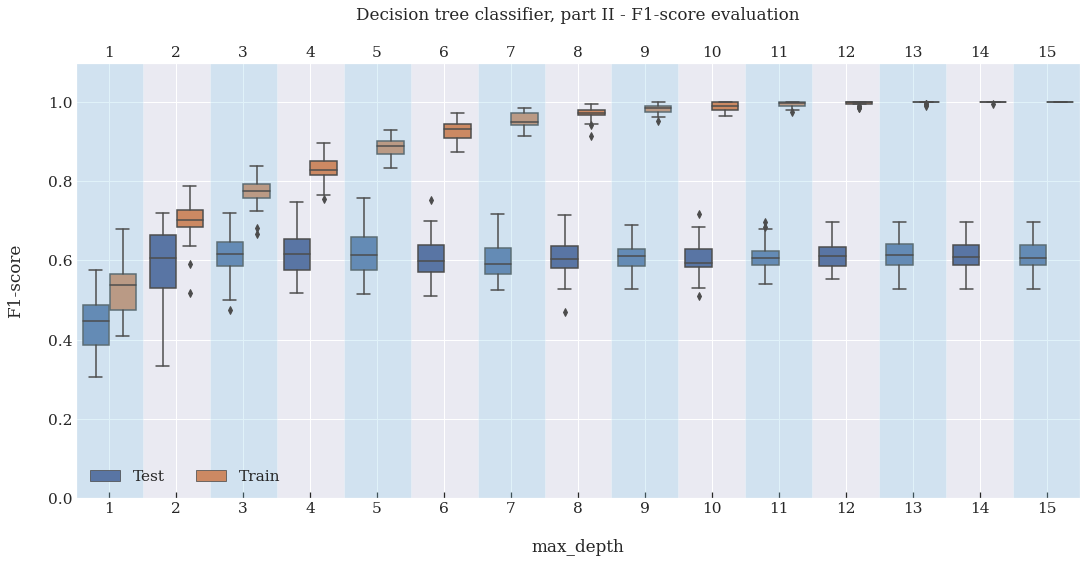

In [93]:
plotScoresGraph("Decision tree classifier, part II",decision_tree_scores, "max_depth", "F1-score")

Podemos ver claramente que a partir de max_depth = 4 há uma lacuna considerável entre o desempenho dos dados de treinamento e teste, tanto para recall quanto para metrcis de pontuação F1, indicando o início do overfit.

Observe também que em max_depths> 10 o desempenho dos dados de treinamento está próximo da perfeição, enquanto os dados de teste não funcionam tão bem quanto em max_depth = 3 ou 4; isso ocorre porque o modelo foi tão ajustado aos dados de treinamento que não é capaz de generalizar para os dados de teste.

Portanto, para o modelo de árvore de decisão ajustado de acordo com nosso banco de dados, usaremos max_depth = 4.

In [94]:
tree_clf = DecisionTreeClassifier(max_depth=4)

Antes de testarmos outros parâmetros para a floresta aleatória e
regressão logística, vamos criar uma função que funcionará para qualquer modelo para permitir usos futuros e assim evitar a repetição de código.

In [95]:
def getScores(data, model, parameter_to_vary, list_of_parameter_values, max_depth=None, n_estimators=None, max_iter=None, solver=None, c_values=None):
  
    parameter = parameter_to_vary

    test_scores_recall = []
    test_scores_f1 = []
    train_scores_recall = []
    train_scores_f1 = []

  # ajustar a string do modelo
    if model == "DecisionTreeClassifier": 
        model = model + "("
  
    if model == "RandomForestClassifier":
        if max_depth != None:
            model = model + "(" + "max_depth =" + str(max_depth) + ","

        if n_estimators != None:
            model = model + "(" + "n_estimators =" + str(n_estimators) + ","

        if model == "LogisticRegression":
            model = model + "(" + "max_iter =" + str(max_iter) + ","

        if solver != None:
            model = model + "solver =" + solver + ","
  
  # realizar uma validação cruzada, com a mesma quantidade de dobras e repetições
    for i in list_of_parameter_values:
    # eval () permite avaliar expressões Python arbitrárias a partir de uma entrada baseada em string ou baseada em código compilado.
        model_clf = eval(model + parameter + "=i)")
        model_clf_cv = runCrossValidation(model =  model_clf, data = data, n_splits=3, n_repeats=10)
        test_scores_recall.append(model_clf_cv['test_recall'])
        test_scores_f1.append(model_clf_cv['test_f1'])
        train_scores_recall.append(model_clf_cv['train_recall'])
        train_scores_f1.append(model_clf_cv['train_f1'])

  # para incluir todos os resultados em um dataframe para que possamos traçar seus valores 
        scores_list = [test_scores_recall, test_scores_f1, train_scores_recall, train_scores_f1]
        scores_metric = ["Recall", "F1-score","Recall", "F1-score"]
        scores_type = ["Test", "Test", "Train", "Train"]
        complete_scores_df = pd.DataFrame()

    for i in range(4):
        scores_df = pd.DataFrame(scores_list[i]).T
        scores_df.columns = list_of_parameter_values
        scores_df = scores_df.melt()
        scores_df.columns = [parameter_to_vary, "score"]
        scores_df["score_metric"] = scores_metric[i]
        scores_df["score_type"] = scores_type[i]
        complete_scores_df = pd.concat([complete_scores_df,scores_df], ignore_index=True)

    return(complete_scores_df)

In [96]:
def getScores(data, model, parameter_to_vary, list_of_parameter_values, max_depth=None, n_estimators=None, max_iter=None, solver=None, c_values=None):
  
  parameter = parameter_to_vary

  test_scores_recall = []
  test_scores_f1 = []
  train_scores_recall = []
  train_scores_f1 = []

  # adjust model string
  if model == "DecisionTreeClassifier": 
    model = model + "("
  
  if model == "RandomForestClassifier":
    if max_depth != None:
      model = model + "(" + "max_depth =" + str(max_depth) + ","

    if n_estimators != None:
      model = model + "(" + "n_estimators =" + str(n_estimators) + ","

  if model == "LogisticRegression":
      model = model + "(" + "max_iter =" + str(max_iter) + ","
      
      if solver != None:
        model = model + "solver =" + solver + ","
  
  # perform a cross validation, with the same amount of folds and repetitions 
  for i in list_of_parameter_values:
    # eval() allows to evaluate arbitrary Python expressions from a string-based or compiled-code-based input.
    model_clf = eval(model + parameter + "=i)")
    model_clf_cv = runCrossValidation(model =  model_clf, data = data, n_splits=3, n_repeats=10)
    test_scores_recall.append(model_clf_cv['test_recall'])
    test_scores_f1.append(model_clf_cv['test_f1'])
    train_scores_recall.append(model_clf_cv['train_recall'])
    train_scores_f1.append(model_clf_cv['train_f1'])

  # to include all the results on a dataframe so that we can plot their values
  scores_list = [test_scores_recall, test_scores_f1, train_scores_recall, train_scores_f1]
  scores_metric = ["Recall", "F1-score","Recall", "F1-score"]
  scores_type = ["Test", "Test", "Train", "Train"]
  complete_scores_df = pd.DataFrame()

  for i in range(4):
    scores_df = pd.DataFrame(scores_list[i]).T
    scores_df.columns = list_of_parameter_values
    scores_df = scores_df.melt()
    scores_df.columns = [parameter_to_vary, "score"]
    scores_df["score_metric"] = scores_metric[i]
    scores_df["score_type"] = scores_type[i]
    complete_scores_df = pd.concat([complete_scores_df,scores_df], ignore_index=True)

  return(complete_scores_df)

Para confirmar que a função funcionou, verificamos que a saída da função, ao passar os mesmos parâmetros necessários para a avaliação do classificador da árvore de decisão, é a mesma:

In [97]:
getScores(second_approach_machine_learning, "DecisionTreeClassifier","max_depth", range(1,16)).equals(decision_tree_scores)

True

Agora tudo está configurado para variar hiperparâmetros de floresta aleatória e regressão logística.

## Random Forests parte II

Quando este modelo foi introduzido, foi mencionado que o hiperparâmetro "n_estimators" é o número de árvores na floresta; vamos avaliar o quão sensível é a previsão do modelo a este hiperparâmetro.

Ao definir max_depth = 4 (da decisão de recurso da árvore de decisão) e variar os n_estimators de 10 a 400, temos o seguinte desempenho:

In [98]:
random_forest_scores = getScores(second_approach_machine_learning, "RandomForestClassifier","n_estimators",[10,30,50,100,150,200,300,400], max_depth=4)

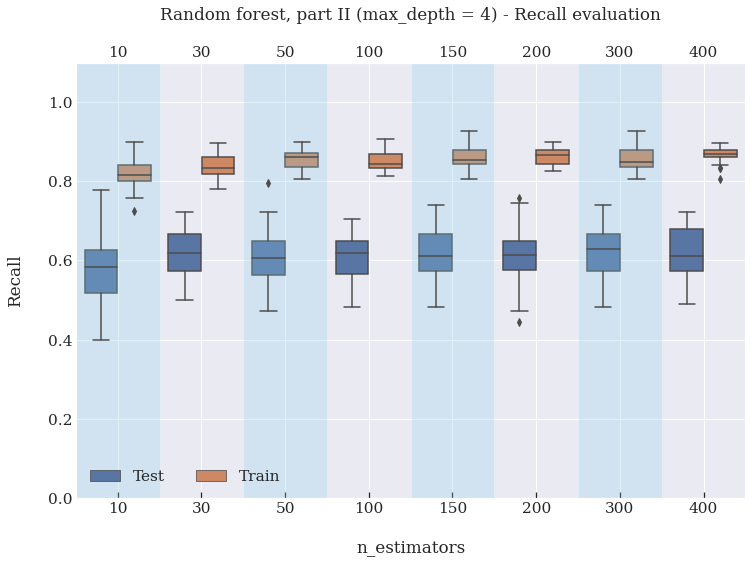

In [99]:
plotScoresGraph("Random forest, part II (max_depth = 4)",random_forest_scores, "n_estimators", "Recall")

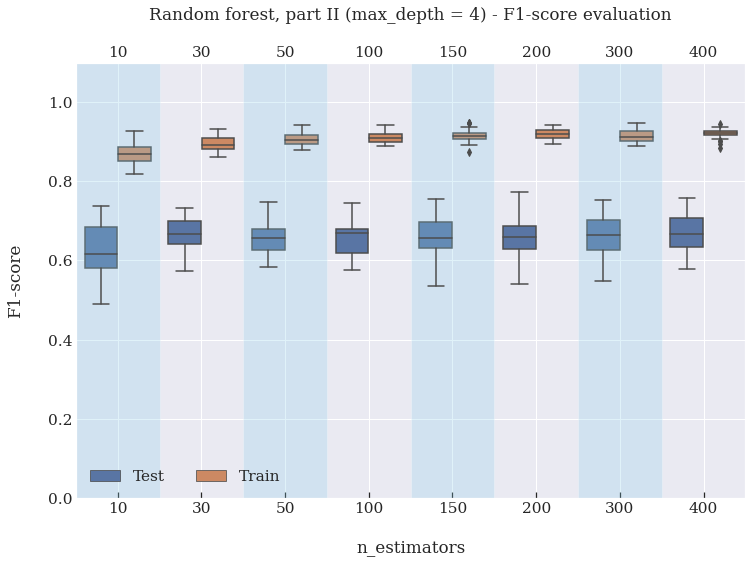

In [100]:
plotScoresGraph("Random forest, part II (max_depth = 4)",random_forest_scores, "n_estimators", "F1-score")

Observe que não há diferenças significativas; podemos apenas notar um desempenho inferior ao usar n_estimators = 10.

Ao analisar o número de estimadores, para aqueles com a menor variância e sem outliers, aquele com o menor custo computacional é quando n_estimators = 100

Vamos variar o max_depth agora.

In [101]:
random_forest_scores = getScores(second_approach_machine_learning, "RandomForestClassifier","max_depth",range(1, 21), n_estimators=100)

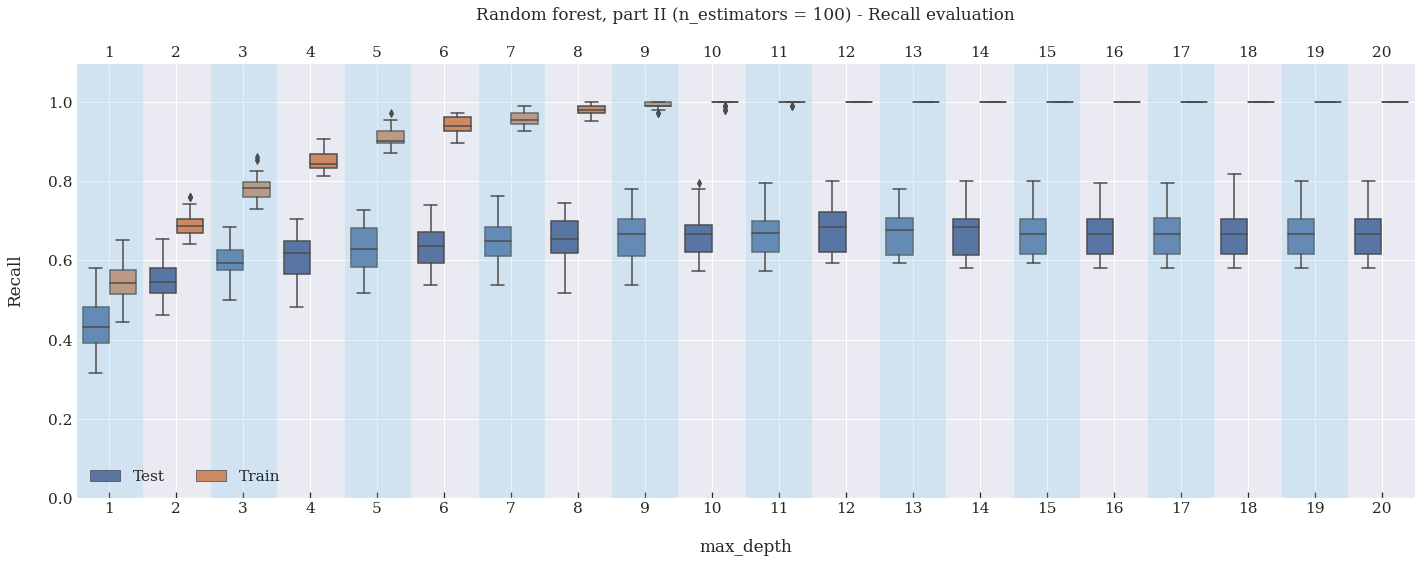

In [102]:
plotScoresGraph("Random forest, part II (n_estimators = 100)",random_forest_scores, "max_depth", "Recall")

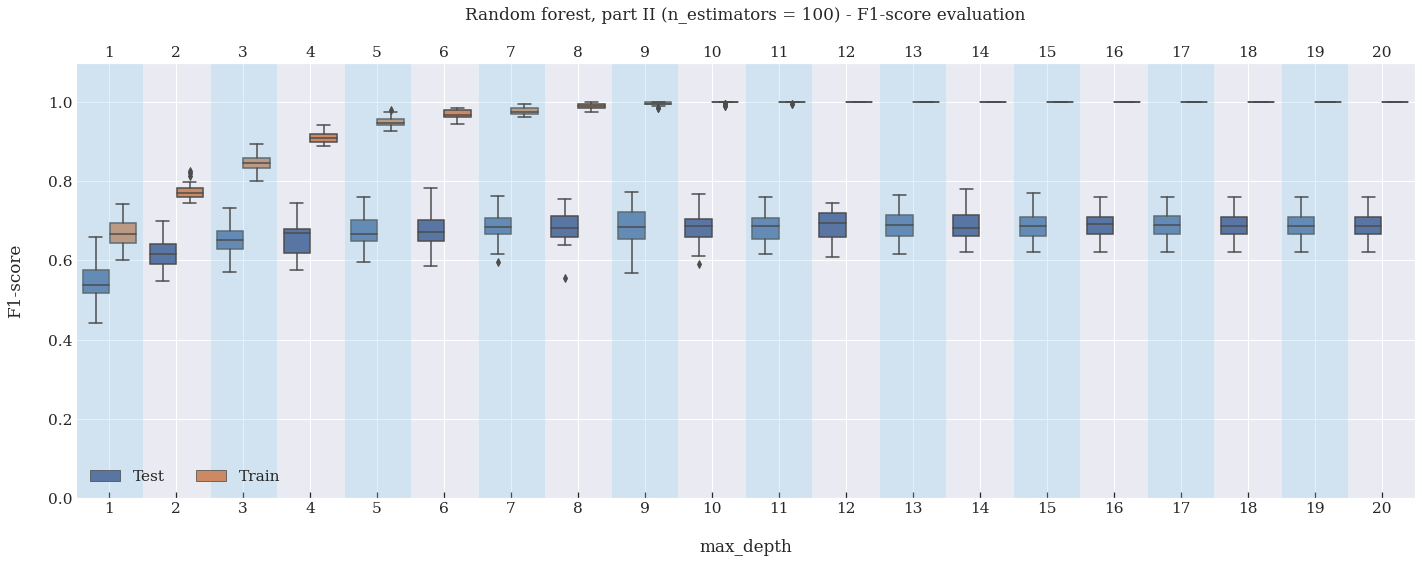

In [103]:
plotScoresGraph("Random forest, part II (n_estimators = 100)",random_forest_scores, "max_depth", "F1-score")

As principais diferenças observadas da floresta aleatória em comparação com a árvore de decisão são:
- evocação menor e variância de pontuação F1 para todos os valores max_depth, particularmente nos mais baixos max_depths;
- depois de atingir as pontuações máximas nos dados de teste para recall e pontuação F1 em torno de max_depth = 10, não há queda de pontuação (ou aumento) em max_depths mais altos, mesmo quando os dados de treinamento já estão sobrecarregados.

Portanto, para o modelo de floresta aleatório ajustado de acordo com nosso banco de dados, usaremos n_estimators = 100 e max_depth = 10.

In [104]:
random_forest_clf = RandomForestClassifier(n_estimators=100, max_depth=10)

## Regressão logística: parte II

Modificaremos dois hiperparâmetros da regressão logística: "solver" e "C"; o primeiro é o algoritmo a ser usado no problema de otimização e o segundo é um parâmetro de regularização definido como 1 / $ \ lambda $, onde $ \ lambda $ controla a compensação entre aumentar a complexidade tanto quanto quiser enquanto tenta mantenha simples. Por exemplo, se λ for muito baixo ou 0 (valor C alto), o modelo terá potência suficiente para aumentar sua complexidade (overfit) atribuindo grandes valores aos pesos de cada parâmetro. Por outro lado, quando aumentamos o valor de λ (menor valor de C), o modelo tende a se ajustar abaixo do normal, pois fica muito simples.

Além disso, considerando a falta de convergência quando max_iter foi definido de acordo com seu valor padrão (max_iter = 100) durante a parte I, será usado max_iter = 1000.

Vamos começar variando o solucionador, mantendo o C em seu valor padrão (C = 1)

In [105]:
logistic_regression_scores = getScores(second_approach_machine_learning, "LogisticRegression","solver",['newton-cg', 'lbfgs', 'liblinear', 'sag'], max_iter=1000)

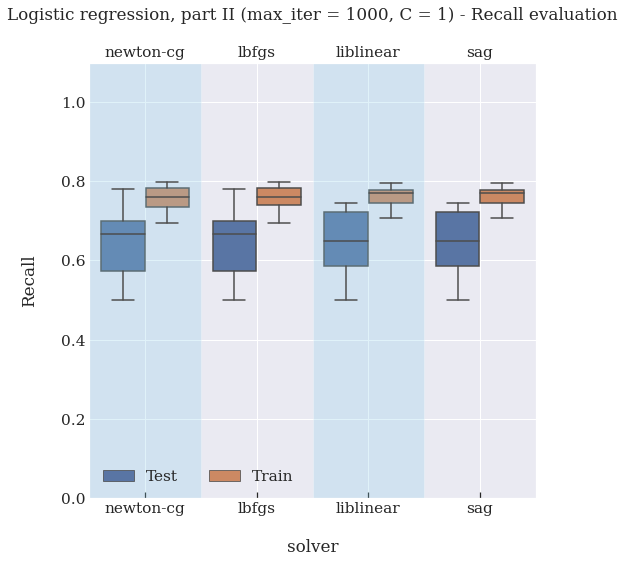

In [106]:
plotScoresGraph("Logistic regression, part II (max_iter = 1000, C = 1)", logistic_regression_scores, "solver", "Recall")

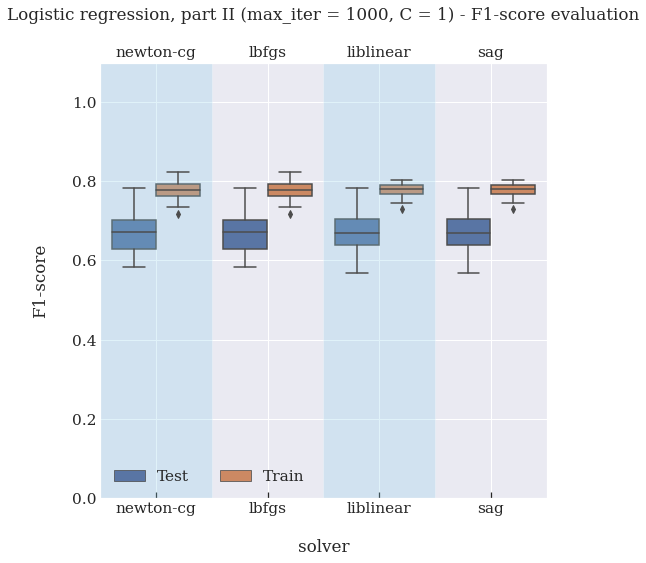

In [107]:
plotScoresGraph("Logistic regression, part II (max_iter = 1000, C = 1)", logistic_regression_scores, "solver", "F1-score")

As mudanças de desempenho observadas nos diferentes solvers são bastante sutis; observe a diminuição nos dados de teste do bigode superior (métrica de recuperação) para os solucionadores 'liblinear' e 'sag'

Por outro lado, temos "newton-cg" e "lbfgs" com desempenho igual.

Como o solucionador "newton é mais caro computacionalmente, escolheremos o" lbfs ", que significa o algoritmo Broyden – Fletcher – Goldfarb – Shanno de memória limitada.

> Se você quiser entender melhor cada um desses solucionadores, chegando aos conceitos matemáticos, sugiro este [tópico sobre estouro de pilha] (
https://stackoverflow.com/questions/38640109/logistic-regression-python-solvers-defintions).

Portanto, vamos definir o solucionador como "lbfgs" e variar o parâmetro C agora.

In [108]:
logistic_regression_scores = getScores(second_approach_machine_learning, "LogisticRegression","C",[0.01, 0.1, 1.0, 10, 100, 1000, 10000], max_iter=10000, solver= "'lbfgs'")

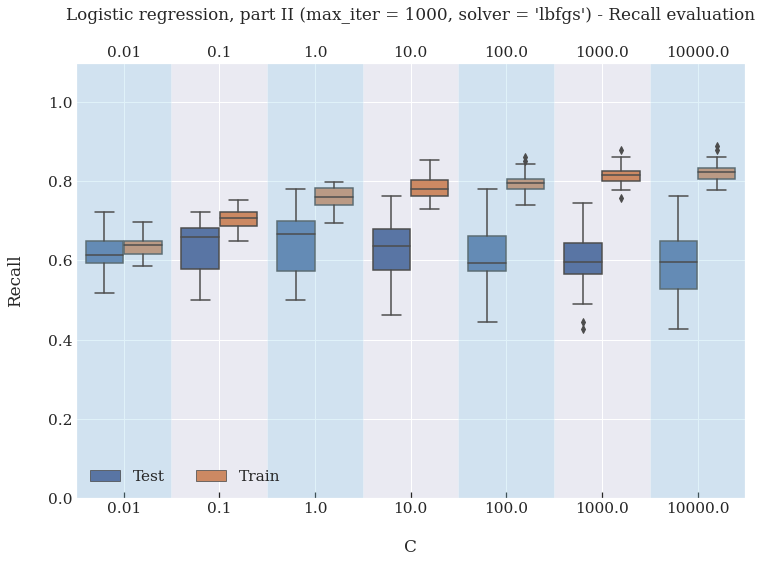

In [109]:
plotScoresGraph("Logistic regression, part II (max_iter = 1000, solver = 'lbfgs')", logistic_regression_scores, "C", "Recall")

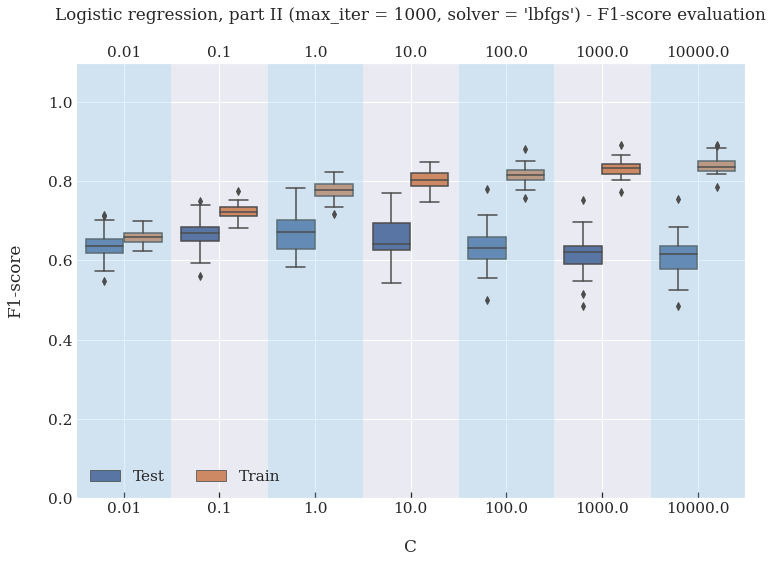

In [110]:
plotScoresGraph("Logistic regression, part II (max_iter = 1000, solver = 'lbfgs')", logistic_regression_scores, "C", "F1-score")

Conforme já explicado, quando o valor de C aumenta, também aumenta a tendência de overfit, observada pelo aumento do desempenho dos dados de treinamento.

Desempenho quando C = 0,1 e C = 1 são semelhantes e estão no limiar do início da queda de desempenho (observe a mediana); notamos também que a variância do bigode superior na métrica de recall, quando C = 0,1, é menor em relação a C = 1; mas como ainda não está claro qual valor usar, estudaremos os valores de C entre 0,1 e 10.

In [111]:
logistic_regression_scores = getScores(second_approach_machine_learning, "LogisticRegression","C",[0.1, 0.5, 1.0, 2, 3, 5, 10], max_iter=10000, solver= "'lbfgs'")

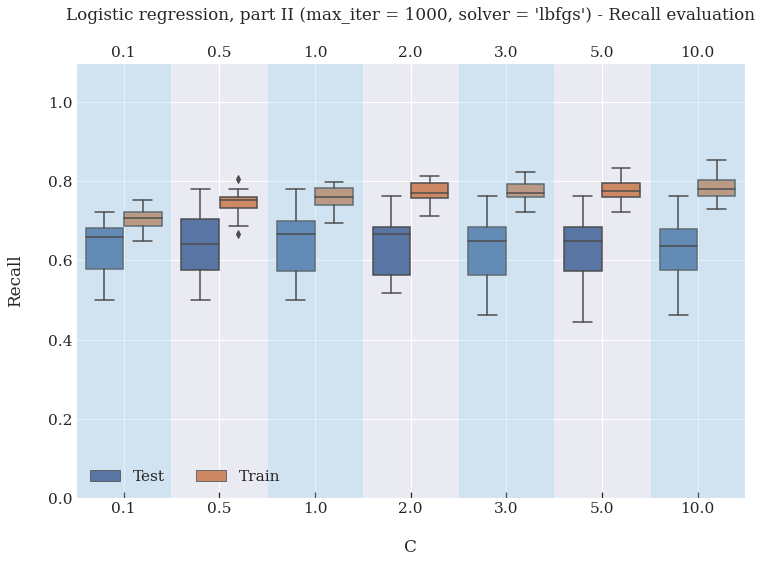

In [112]:
plotScoresGraph("Logistic regression, part II (max_iter = 1000, solver = 'lbfgs')", logistic_regression_scores, "C", "Recall")

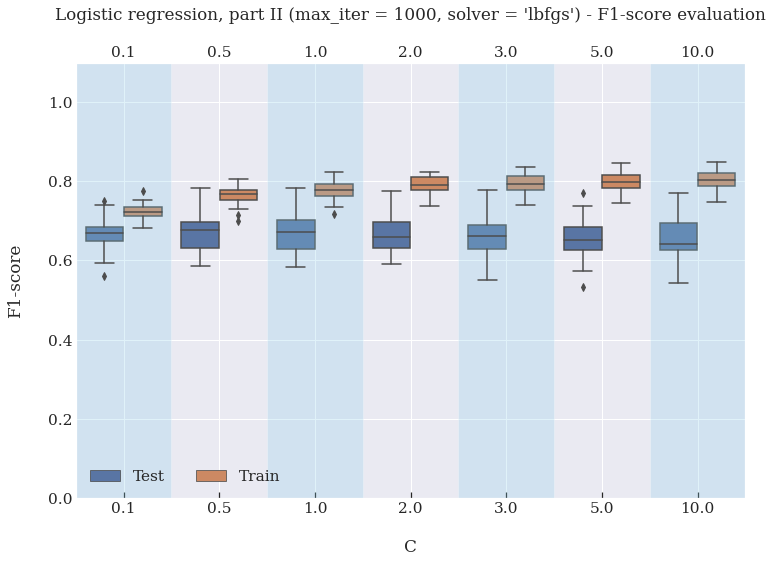

In [113]:
plotScoresGraph("Logistic regression, part II (max_iter = 1000, solver = 'lbfgs')", logistic_regression_scores, "C", "F1-score")

Vemos diferenças de desempenho muito sutis, variando este parâmetro de regularização C entre 0,1 e 10

Quando C = 1, para ambas as métricas, o bigode inferior é um pouco mais longo do que C = 2; como queremos maximizar os valores dessas métricas, especialmente o recall, escolheremos C = 2.

Portanto, para o modelo de regressão logística ajustado de acordo com nosso banco de dados, usaremos max_iter = 1000, solver = 'lbfgs' e C = 2.

In [114]:
log_reg_clf = LogisticRegression(max_iter=1000, solver='lbfgs', C=2)

## Desempenho dos modelos parte II

Desta vez temos maior confiança no desempenho dos modelos ajustados, pois os testes e avaliações foram feitos em multiplicidade, tornando-se muito menos suscetíveis à volatilidade dos resultados, conforme explicado durante o treinamento dos modelos / teste parte I.

Portanto, vamos verificar o desempenho final, após a otimização do hiperparâmetro que foi feita durante a parte II.

Para futura reutilização do código, criaremos mais uma função.

In [115]:
def getSummaryScores(data):
    
  "" "É necessário ter 'Árvore de decisão', 'Floresta aleatória' e 'Regressão logística' já treinados para usar esta função" "" # este é um docstring do módulo, mostrado quando você usa help () em um módulo
  models_list = [tree_clf, random_forest_clf, log_reg_clf]
  
  recall_score_list = []
  f1_score_list = []

  for model in models_list:
    scores = runCrossValidation(model,data,n_splits=3, n_repeats=10)
    recall_score_list.append(scores['test_recall'])
    f1_score_list.append(scores['test_f1'])

  models = ["Decision tree classifier", "Random forest", "Logistic regression"]
  scores_recall_partX = pd.DataFrame(recall_score_list, index=models).T.melt().set_index("variable")
  scores_recall_partX.columns = ["Recall"]

  scores_f1_partX = pd.DataFrame(f1_score_list, index=models).T.melt().set_index("variable")
  scores_f1_partX.columns = ["F1-score"]
  scores_f1_partX

  scores_models_partX = pd.concat([scores_recall_partX,scores_f1_partX], axis=1)
  scores_models_partX.reset_index(inplace=True)

  table_scores = pd.pivot_table(scores_models_partX, values=['Recall', 'F1-score'], index=['variable'],
                      aggfunc={'Recall': [np.mean, np.std],
                              'F1-score': [np.mean, np.std]})

  table_scores.rename_axis('',inplace=True)

  table_scores = table_scores[[('Recall', 'mean'), ('Recall',  'std'), ('F1-score', 'mean'),('F1-score', 'std')]].sort_values(by=('Recall', 'mean'),ascending=False).round(3)
  
  scores_models_partX.columns = ["Model", "Recall", "F1-score"]
  
  return (table_scores, scores_models_partX)

In [116]:
summary_partII, scores_models_partII = getSummaryScores(second_approach_machine_learning)

scores_models_partII["part #"] = "part II"
scores_models_full = pd.concat([scores_models_full, scores_models_partII])

summary_partII

Recall        F1-score       
                           mean    std     mean    std
                                                      
Random forest             0.660  0.056    0.684  0.041
Logistic regression       0.637  0.074    0.667  0.049
Decision tree classifier  0.592  0.088    0.616  0.056

Dentre os 3 preditores utilizados, o que teve melhor desempenho, de acordo com os ajustes de hiperparâmetros mostrados anteriormente, foi a floresta aleatória.

Como o mundo do aprendizado de máquina é iterativo, revisaremos nosso banco de dados e realizaremos mais testes na tentativa de aumentar esse desempenho.

# Tentativas de melhorar os modelos

## Revisão do banco de dados

A primeira tentativa de melhorar o desempenho obtido será finalmente utilizar a lista que contém todas as colunas duplicadas. Também verificaremos como as colunas estão correlacionadas para eliminar um pouco mais; colunas altamente correlacionadas podem ser prejudiciais para algoritmos de aprendizado de máquina.

### Seleção de recursos parte I: remoção de colunas duplicadas e altamente correlacionadas

In [117]:
# como estamos alterando o banco de dados, é importante criar uma cópia do dataframe original preparado usando o método copy ()
third_approach_machine_learning = first_approach_machine_learning.copy()
third_approach_machine_learning.shape[1]

229

There are 229 original columns.

In [118]:
# aplica a remoção de colunas
third_approach_machine_learning = third_approach_machine_learning.drop(columns=duplicate_columns)
third_approach_machine_learning.shape[1]

85

Após retirar as colunas duplicadas, podemos avaliar, entre as restantes (85), qual a correlação entre elas; removeremos aqueles que estão altamente correlacionados entre si (> 0,90 de acordo com a correlação de Pearson). Para isso, será criada uma função que possa testar, se desejado, com outros valores de corte.

In [119]:
# esta função considera a análise apenas para o triângulo superior da matriz de correlação;
# desta forma, uma das duas colunas que apresentaram alta correlação será preservada.

def removeHighCorr(data,cut_off_value):
  matrix_corr = data.iloc[:,3:-1].corr().abs()
  matrix_up = matrix_corr.where(np.triu(np.ones(matrix_corr.shape),k=1).astype(np.bool))
  columns_removal = [column for column in matrix_up.columns if any(matrix_up[column]>cut_off_value)]
  
  return data.drop(columns_removal, axis=1)

third_approach_machine_learning = removeHighCorr(third_approach_machine_learning,0.90)
third_approach_machine_learning.shape[1]

59

Das 229 colunas originais, 59 permanecem.

Agora vamos fazer a mesma coisa que fizemos durante a parte II, ou seja, variar os hiperparâmetros e avaliar quais são melhores para esse conjunto de dados recém-retrabalhado.

Em seguida, o novo desempenho dos 3 preditores será apresentado.

Os comentários serão feitos somente após o término dos testes dos hiperparâmetros de cada preditor.

#### Árvore de decisão parte III

In [120]:
decision_tree_scores = getScores(third_approach_machine_learning, "DecisionTreeClassifier","max_depth", range(1,16))

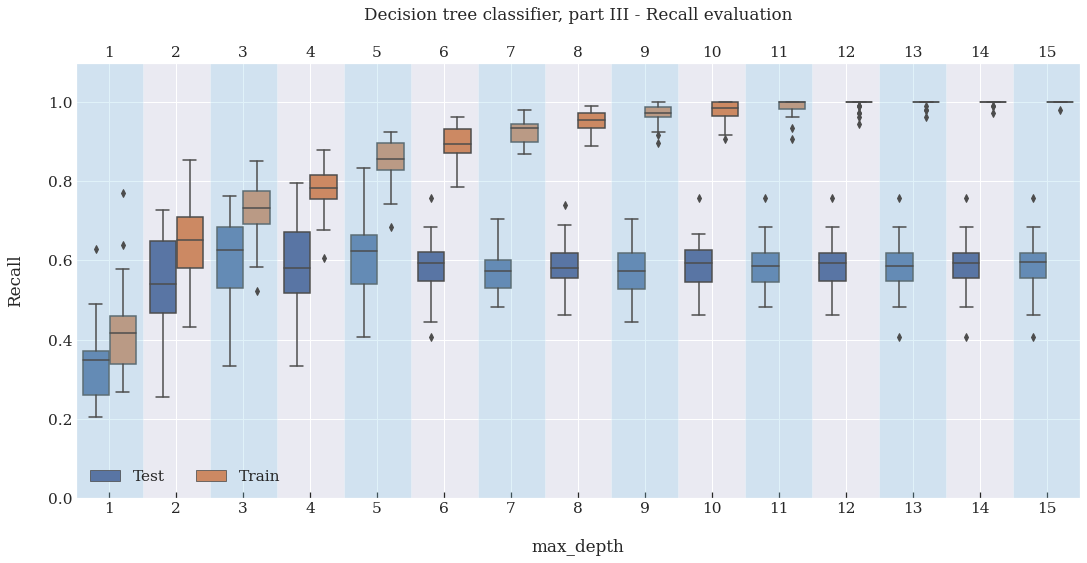

In [121]:
plotScoresGraph("Decision tree classifier, part III",decision_tree_scores, "max_depth", "Recall")

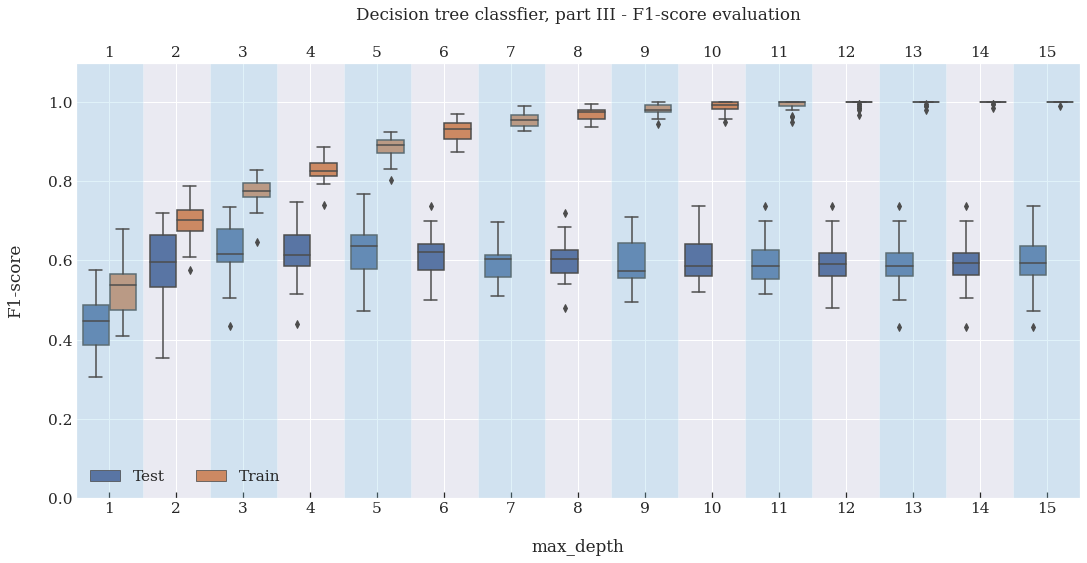

In [122]:
plotScoresGraph("Decision tree classfier, part III",decision_tree_scores, "max_depth", "F1-score")

Após analisar o desempenho com os diferentes hiperparâmetros, optou-se por max_depth = 5.

In [123]:
tree_clf = DecisionTreeClassifier(max_depth=5)

#### Random Forest part III

In [124]:
random_forest_scores = getScores(third_approach_machine_learning, "RandomForestClassifier","n_estimators",[10,30,50,100,150,200,300,400], max_depth=5)

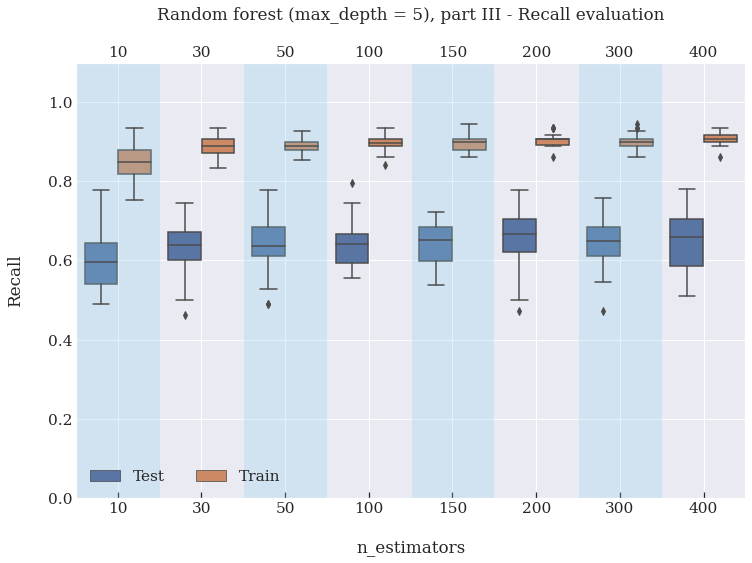

In [125]:
plotScoresGraph("Random forest (max_depth = 5), part III",random_forest_scores, "n_estimators", "Recall")

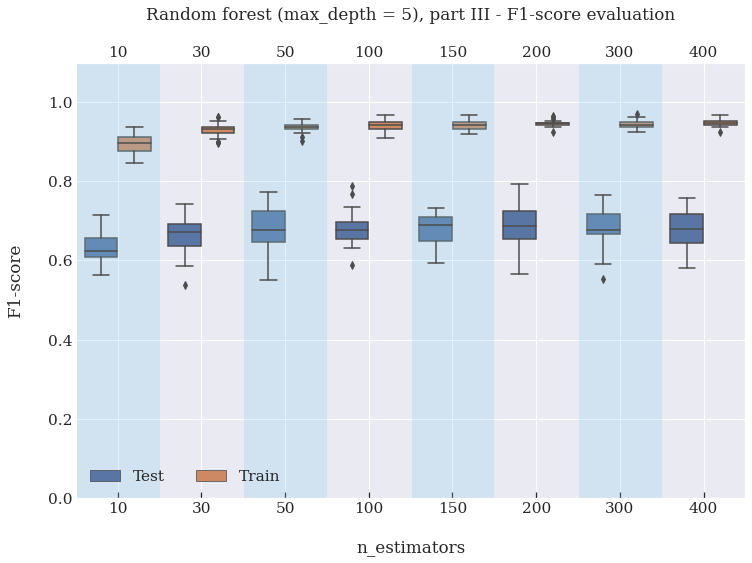

In [126]:
plotScoresGraph("Random forest (max_depth = 5), part III",random_forest_scores, "n_estimators", "F1-score")

In [127]:
random_forest_scores = getScores(third_approach_machine_learning, "RandomForestClassifier","max_depth",range(1, 21), n_estimators=100)

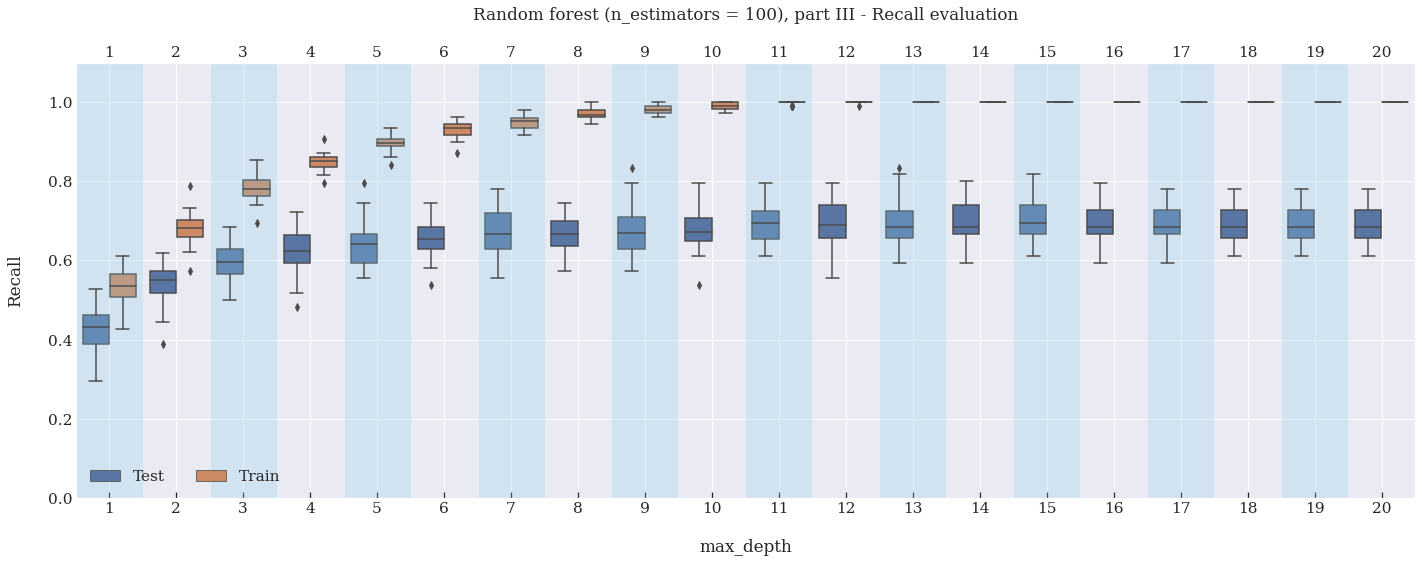

In [128]:
plotScoresGraph("Random forest (n_estimators = 100), part III",random_forest_scores, "max_depth", "Recall")

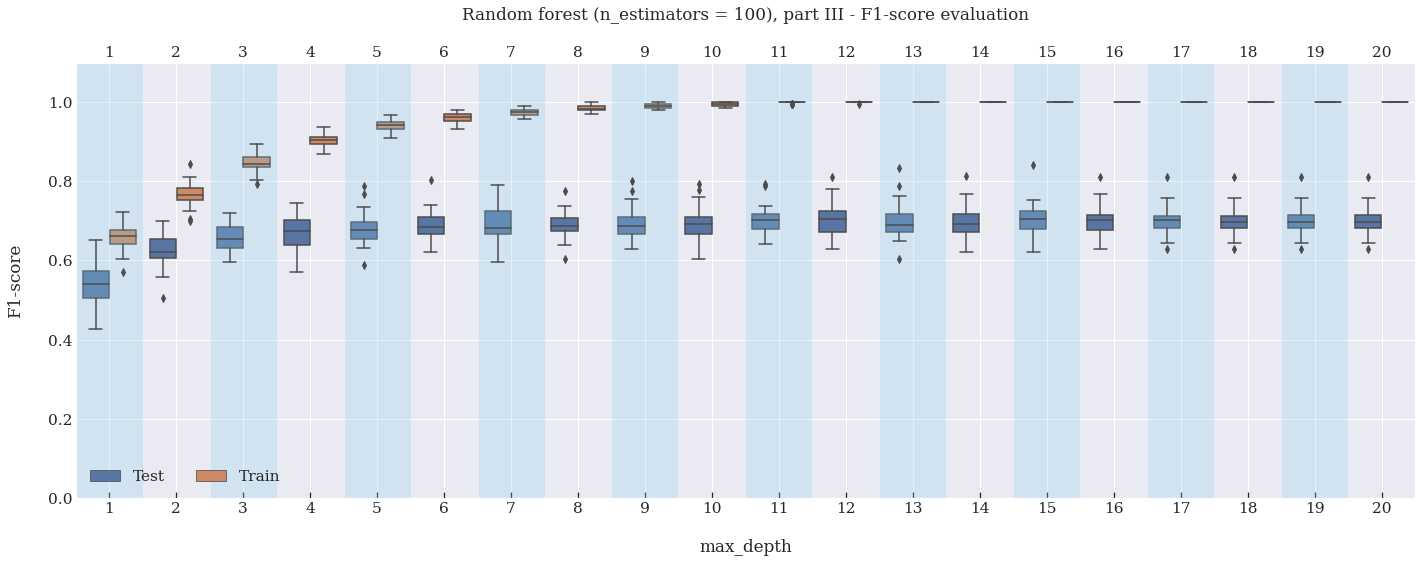

In [129]:
plotScoresGraph("Random forest (n_estimators = 100), part III",random_forest_scores, "max_depth", "F1-score")

Após analisar o desempenho com os diferentes hiperparâmetros, optou-se por n_estimators = 100 e max_depth = 11.

In [130]:
random_forest_clf = RandomForestClassifier(n_estimators=100, max_depth=11)

#### Logistic regression part III

In [131]:
logistic_regression_scores = getScores(third_approach_machine_learning, 
                                       "LogisticRegression","solver",['newton-cg', 'lbfgs', 'liblinear', 'sag'], max_iter=1000)

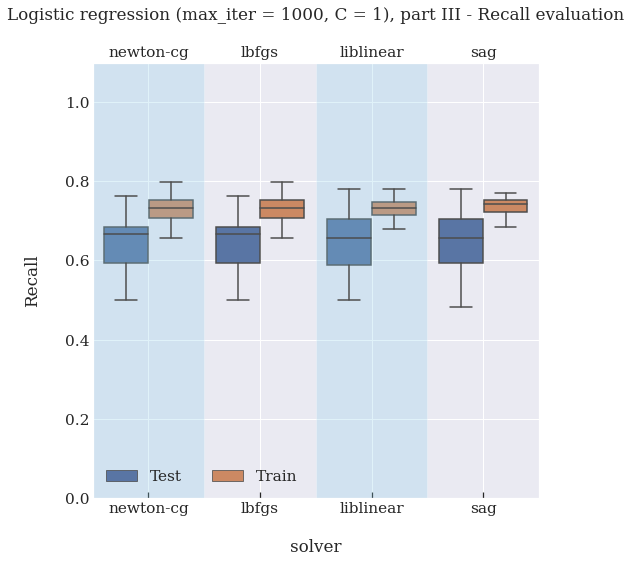

In [132]:
plotScoresGraph("Logistic regression (max_iter = 1000, C = 1), part III", logistic_regression_scores, "solver", "Recall")

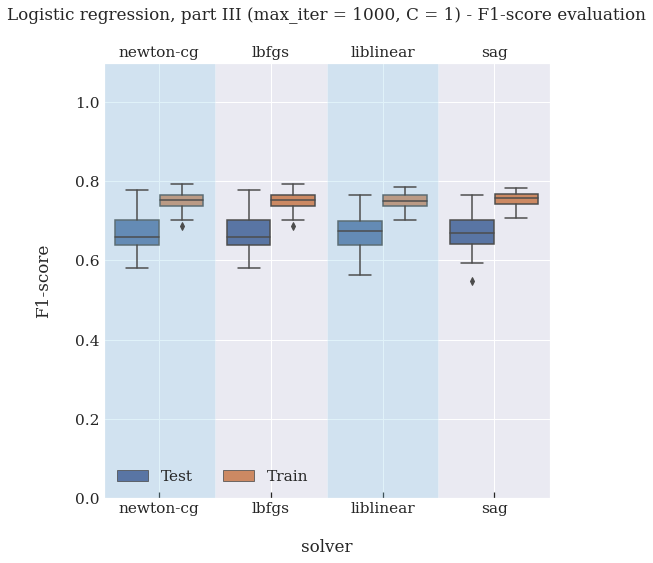

In [133]:
plotScoresGraph("Logistic regression, part III (max_iter = 1000, C = 1)", logistic_regression_scores, "solver", "F1-score")

Vamos escolher solver = 'lbfgs' novamente.

In [134]:
logistic_regression_scores = getScores(third_approach_machine_learning, "LogisticRegression","C",
                                       [0.01, 0.1, 1.0, 10, 100, 1000, 10000], max_iter=10000, solver= "'lbfgs'")

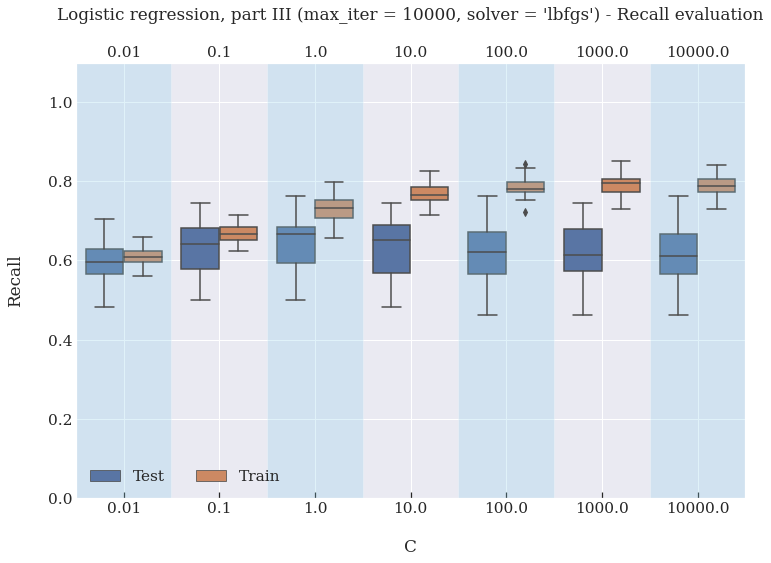

In [135]:
plotScoresGraph("Logistic regression, part III (max_iter = 10000, solver = 'lbfgs')", logistic_regression_scores, "C", "Recall")

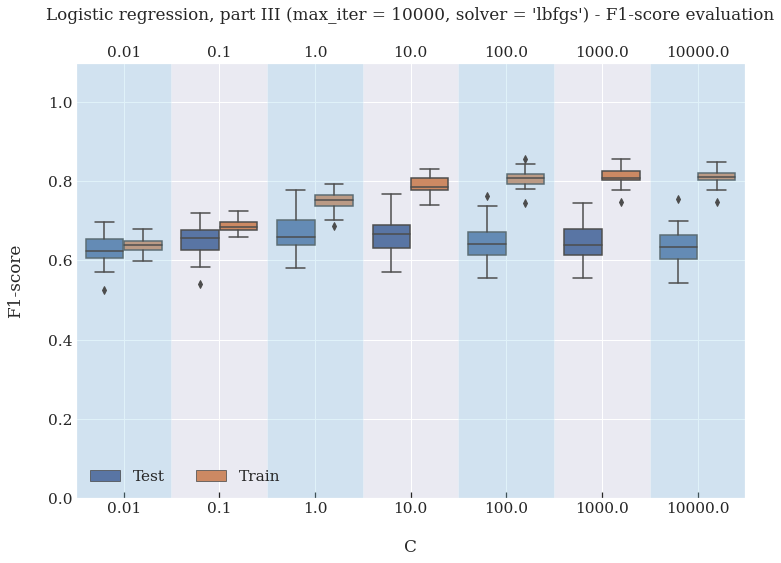

In [136]:
plotScoresGraph("Logistic regression, part III (max_iter = 10000, solver = 'lbfgs')", logistic_regression_scores, "C", "F1-score")

Ao variar o parâmetro C, foi necessário aumentar o max_iter para 10000 para convergir.
Por enquanto, continuaremos avaliando este parâmetro, desta vez entre 0,1 e 10.

In [137]:
logistic_regression_scores = getScores(third_approach_machine_learning, "LogisticRegression","C",[0.1, 0.5, 1.0, 2, 3, 5, 10], max_iter=10000, solver= "'lbfgs'")

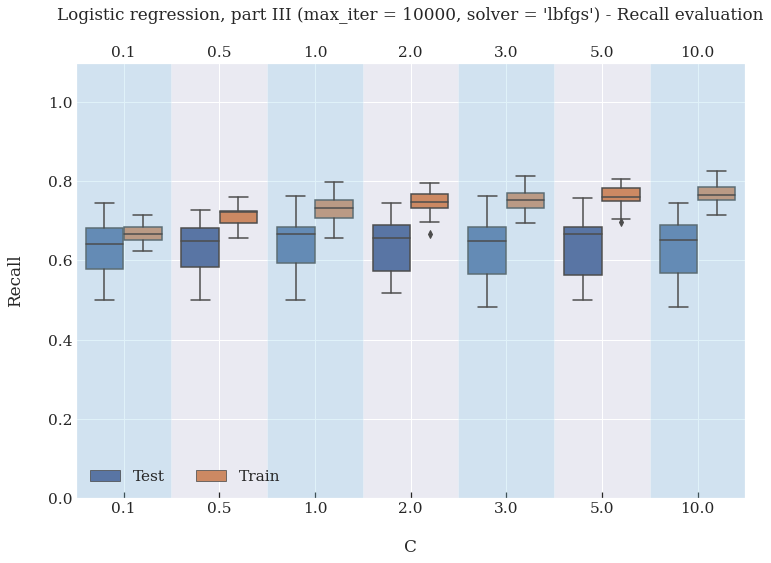

In [138]:
plotScoresGraph("Logistic regression, part III (max_iter = 10000, solver = 'lbfgs')", logistic_regression_scores, "C", "Recall")

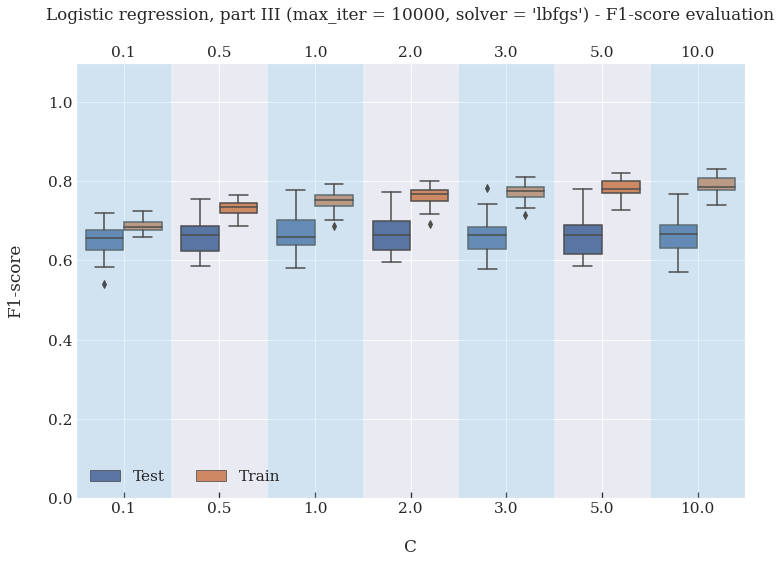

In [139]:
plotScoresGraph("Logistic regression, part III (max_iter = 10000, solver = 'lbfgs')", logistic_regression_scores, "C", "F1-score")

Após analisar o desempenho com os diferentes hiperparâmetros, optou-se por solver = 'lbfgs' e C = 1; além disso, foi necessário definir max_iter = 10000 para convergir.

In [140]:
log_reg_clf = LogisticRegression(max_iter=10000, solver='lbfgs', C=1)

#### Desempenho dos modelos parte III

Podemos ver que houve um aumento interessante no desempenho dos 3 preditores após a mudança no banco de dados (redução no número de colunas).

In [141]:
summary_partIII, scores_models_partIII = getSummaryScores(third_approach_machine_learning)

scores_models_partIII["part #"] = "part III"
scores_models_full = pd.concat([scores_models_full, scores_models_partIII])
scores_models_full

summary_partIII

Recall        F1-score       
                           mean    std     mean    std
                                                      
Random forest             0.694  0.048    0.703  0.034
Logistic regression       0.643  0.067    0.671  0.045
Decision tree classifier  0.605  0.094    0.622  0.063

### Seleção de recursos parte II: usando SelectKBest e definindo recursos relacionados à idade

Vamos reduzir o banco de dados um pouco mais, selecionando os 10 recursos mais em nossos dados que mais contribuem para a variável de destino (ANY_WINDOW_IN_ICU), de acordo com o método SelectKBest, baseado na função qui-quadrado.

Para obter mais informações sobre o método SelectKBest, visite este [link] (https://www.kaggle.com/jepsds/feature-selection-using-selectkbest?utm_campaign=News&utm_medium=Community&utm_source=DataCamp.com) e assista a este [vídeo] (https://www.youtube.com/watch?v=UW9U0bYJ-Ys).

In [142]:
# vamos começar esta seleção usando o banco de dados anterior, que tem
# já sofreu uma redução significativa nas colunas

fourth_approach_machine_learning = third_approach_machine_learning.copy()

In [143]:
# valores negativos não são permitidos, é por isso que adicionamos 1 para os valores de x
x = fourth_approach_machine_learning.drop(columns=["ANY_WINDOW_IN_ICU"])+1
y = fourth_approach_machine_learning["ANY_WINDOW_IN_ICU"]

# k = 10 significa que obteremos o
selector = SelectKBest(chi2, k=10)
selector.fit(x, y)
cols = selector.get_support(indices=True)
fourth_approach_machine_learning = pd.concat([fourth_approach_machine_learning.iloc[:,cols],fourth_approach_machine_learning["ANY_WINDOW_IN_ICU"]],axis=1)

list(fourth_approach_machine_learning.columns[0:-1])

['AGE_ABOVE65',
 'AGE_PERCENTIL',
 'HTN',
 'BE_VENOUS_MEDIAN',
 'BLAST_MEDIAN',
 'LACTATE_MEDIAN',
 'PCR_MEDIAN',
 'BLOODPRESSURE_DIASTOLIC_MEAN',
 'RESPIRATORY_RATE_MEAN',
 'BLOODPRESSURE_SISTOLIC_DIFF']

As colunas acima são aquelas que foram identificadas como as mais relevantes para o valor da variável alvo.

Notamos que existem 2 colunas referentes à idade: AGE_ABOVE65 e AGE_PERCENTIL; vamos usar apenas um deles; como AGE_PERCENTIL traz mais informações, vamos escolher esta. No entanto, a sequência numérica desta variável categórica pode acabar sendo superdimensionada pelo algoritmo; para removê-lo, iremos "explodir" esta coluna em múltiplos, onde cada uma conterá "0" ou "1" para aquele percentil de idade apresentado neste recurso.

Para isso, usaremos o método get_dummies ().

In [144]:
# é necessário reiniciar o índice para ser possível concatenar
# com as variáveis resultantes da explosão de AGE_PERCENTIL
fourth_approach_machine_learning = fourth_approach_machine_learning.reset_index()

# esta variável contém apenas as colunas resultantes de AGE_PERCENTIL
exploded_data = pd.get_dummies(fourth_approach_machine_learning.AGE_PERCENTIL)

# temos que concatenar e remover a coluna original;
# também, vamos eliminar a coluna AGE_ABOVE65
fourth_approach_machine_learning = pd.concat([fourth_approach_machine_learning,exploded_data],axis=1).drop(["AGE_PERCENTIL"],axis=1)
fourth_approach_machine_learning = fourth_approach_machine_learning.drop(["AGE_ABOVE65"],axis=1)

# agora, vamos definir o índice novamente
fourth_approach_machine_learning = fourth_approach_machine_learning.set_index("PATIENT_VISIT_IDENTIFIER")
fourth_approach_machine_learning

,HTN,BE_VENOUS_MEDIAN,BLAST_MEDIAN,LACTATE_MEDIAN,PCR_MEDIAN,BLOODPRESSURE_DIASTOLIC_MEAN,RESPIRATORY_RATE_MEAN,BLOODPRESSURE_SISTOLIC_DIFF,ANY_WINDOW_IN_ICU,0,1,2,3,4,5,6,7,8,9
PATIENT_VISIT_IDENTIFIER,,,,,,,,,,,,,,,,,,,
0,0.0,-1.000000,-1.000000,1.000000,-0.875236,0.086420,-0.593220,-1.000000,1,0,0,0,0,0,1,0,0,0,0
2,0.0,-1.000000,-1.000000,1.000000,-0.939887,-0.489712,-0.645951,-0.533742,1,1,0,0,0,0,0,0,0,0,0
3,0.0,-1.000000,-1.000000,-0.828421,-0.503592,0.012346,-0.457627,-1.000000,0,0,0,0,1,0,0,0,0,0,0
4,0.0,-1.000000,-1.000000,1.000000,-0.990926,0.333333,-0.593220,-0.877301,0,1,0,0,0,0,0,0,0,0,0
5,0.0,-1.000000,-1.000000,1.000000,-0.997732,-0.037037,-0.525424,-0.754601,0,1,0,0,0,0,0,0,0,0,0
6,0.0,-1.000000,-1.000000,1.000000,-0.750095,-0.209877,-0.593220,-1.000000,0,0,0,0,0,0,0,1,0,0,0
7,1.0,-1.000000,-1.000000,1.000000,-0.999244,0.185185,-0.389831,-1.000000,0,0,1,0,0,0,0,0,0,0,0
8,0.0,-1.000000,-1.000000,-0.952572,-0.798110,-0.185185,-0.593220,-1.000000,0,0,0,0,0,1,0,0,0,0,0
9,0.0,-1.000000,-1.000000,1.000000,-0.996597,0.086420,-0.661017,-1.000000,0,0,0,0,0,0,0,0,1,0,0


Tente rolar para a direita para ver as novas colunas baseadas em AGE_PERCENTIL.

Vamos fazer o mesmo de antes: variar os hiperparâmetros e avaliar quais são melhores para esse conjunto de dados recém-retrabalhado.

Novamente, comentários serão feitos somente após o término dos testes dos hiperparâmetros de cada preditor.

Ao final da série da parte IV, o novo desempenho dos 3 preditores será apresentado.

#### Árvore de decisão parte IV

In [145]:
decision_tree_scores = getScores(fourth_approach_machine_learning, "DecisionTreeClassifier","max_depth", range(1,21))

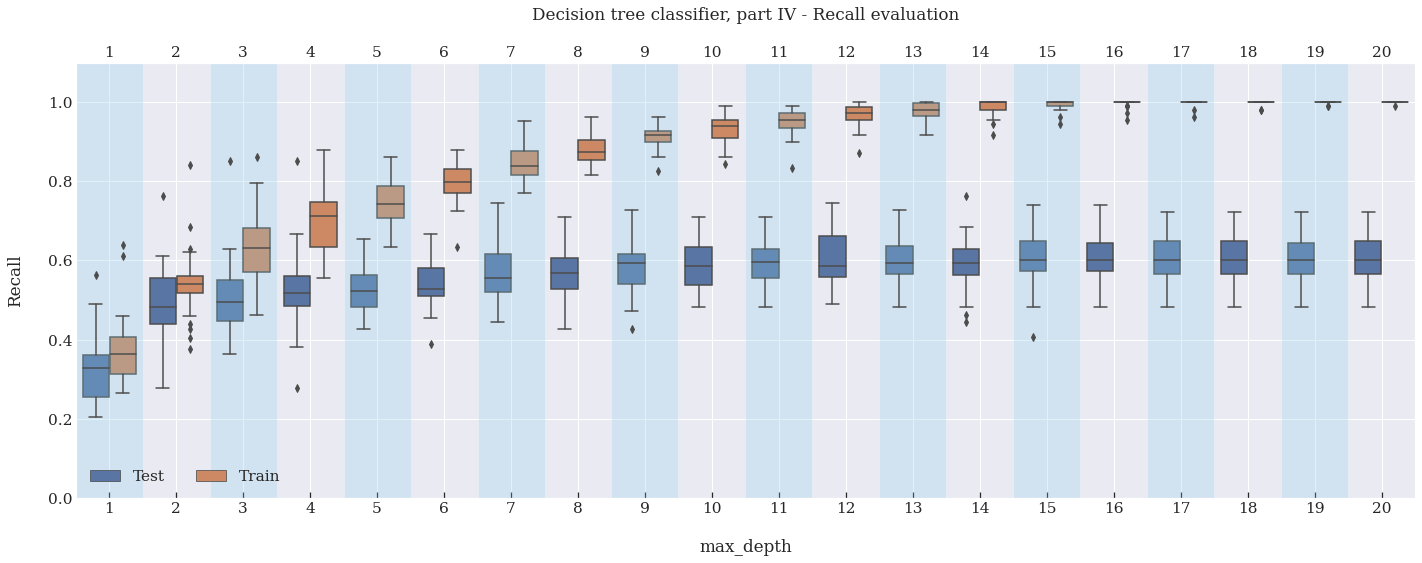

In [146]:
plotScoresGraph("Decision tree classifier, part IV",decision_tree_scores, "max_depth", "Recall")


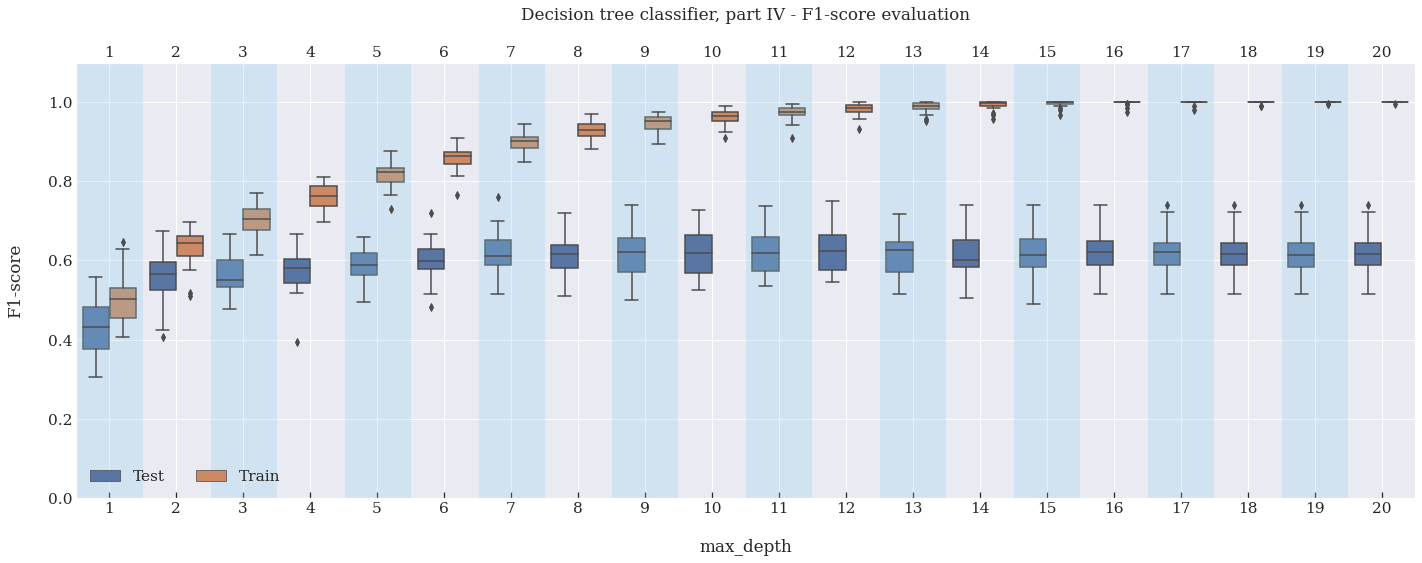

In [147]:
plotScoresGraph("Decision tree classifier, part IV",decision_tree_scores, "max_depth", "F1-score")

É interessante notar que o classificador da árvore de decisão agora está menos sujeito a ajuste excessivo.

Após analisar o desempenho com os diferentes hiperparâmetros, optou-se por max_depth = 14.

In [148]:
tree_clf = DecisionTreeClassifier(max_depth=14)

#### Floresta aleatória parte IV

In [149]:
random_forest_scores = getScores(fourth_approach_machine_learning, "RandomForestClassifier","n_estimators",[10,30,50,100,150,200,300,400], max_depth=14)

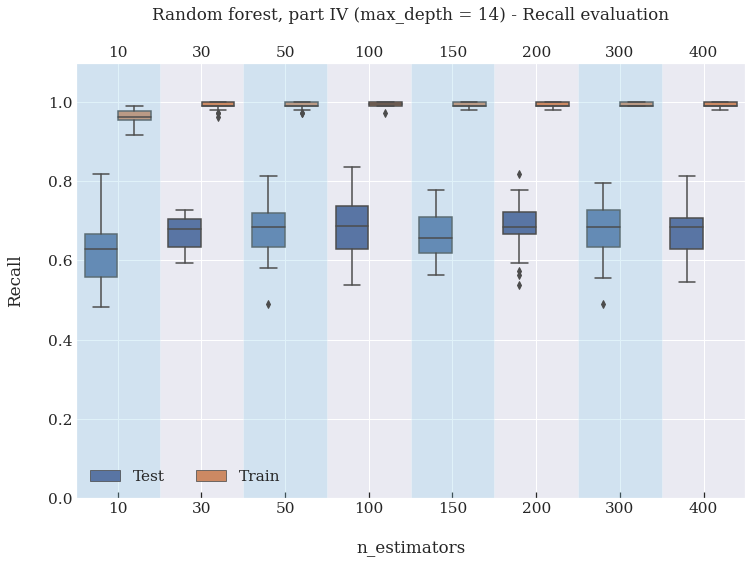

In [150]:
plotScoresGraph("Random forest, part IV (max_depth = 14)",random_forest_scores, "n_estimators", "Recall")

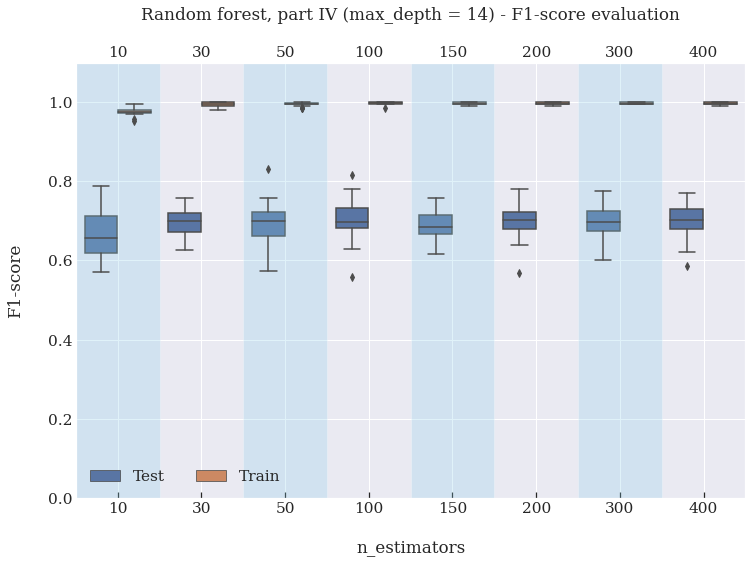

In [151]:
plotScoresGraph("Random forest, part IV (max_depth = 14)",random_forest_scores, "n_estimators", "F1-score")

Observe que mesmo em n_estimators mais baixos, a base de treinamento já está funcionando quase perfeitamente.

Com base no desempenho dos dados de teste, escolheremos n_estimators = 200.

In [152]:
random_forest_scores = getScores(fourth_approach_machine_learning, "RandomForestClassifier","max_depth",range(1, 21), n_estimators=200)

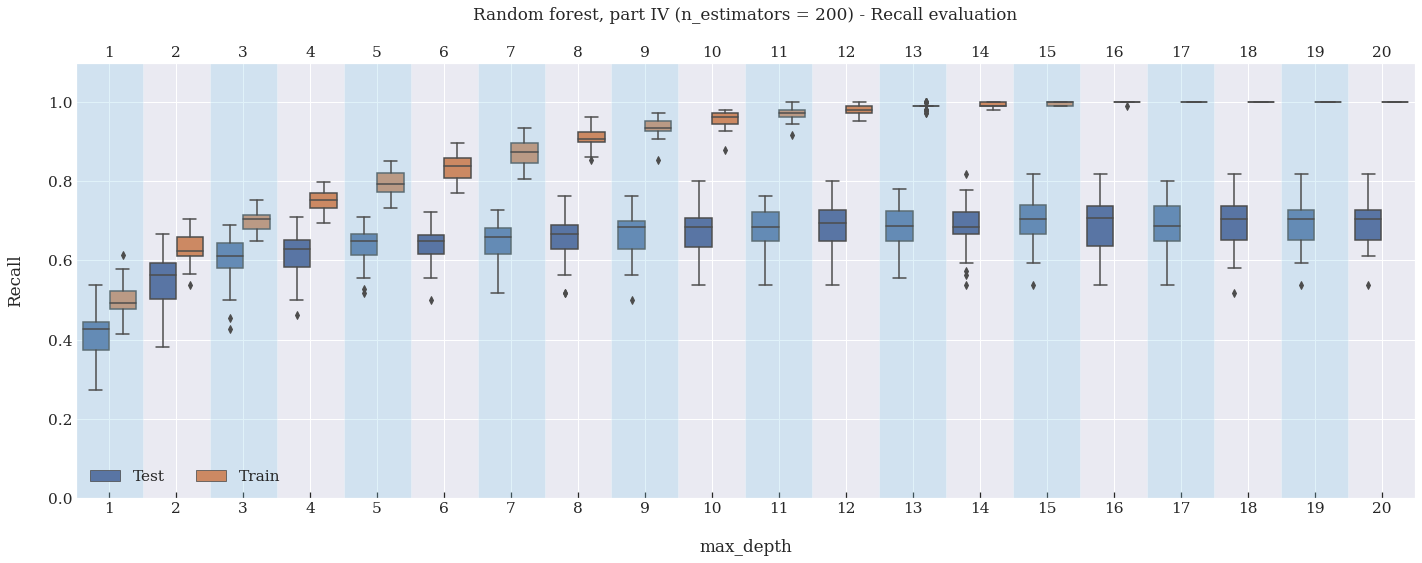

In [153]:
plotScoresGraph("Random forest, part IV (n_estimators = 200)",random_forest_scores, "max_depth", "Recall")

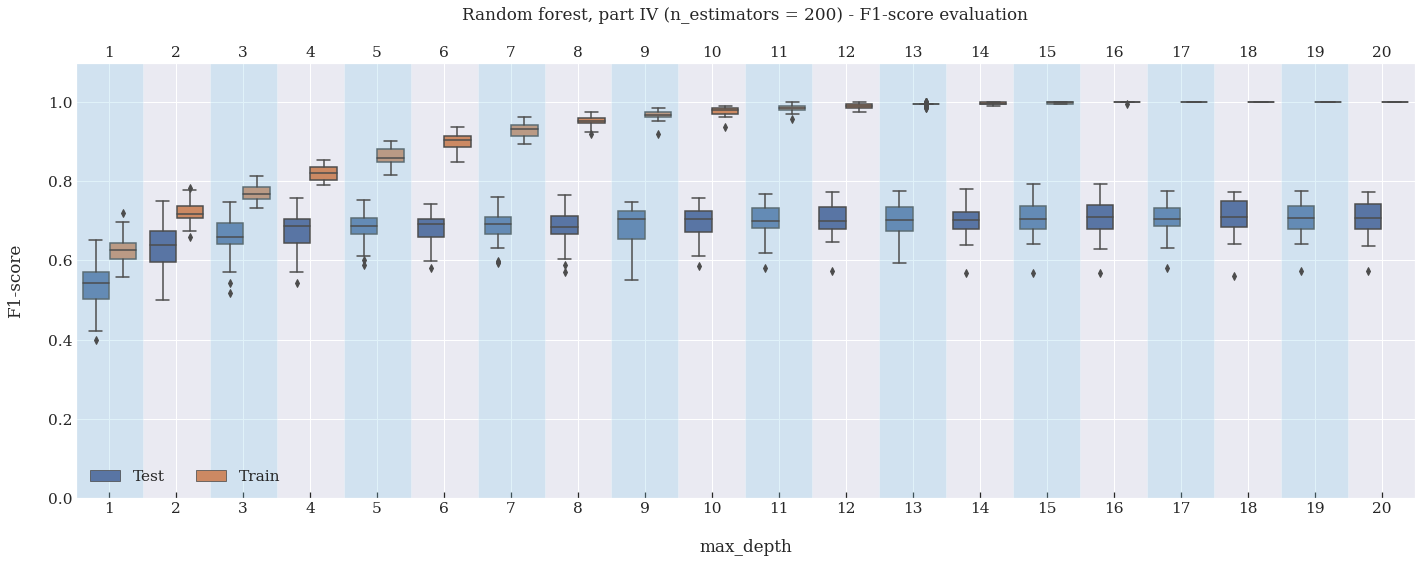

In [154]:
plotScoresGraph("Random forest, part IV (n_estimators = 200)",random_forest_scores, "max_depth", "F1-score")

Após analisar o desempenho com os diferentes hiperparâmetros, optou-se por n_estimators = 200 e max_depth = 10.

In [155]:
random_forest_clf = RandomForestClassifier(n_estimators=200, max_depth=10)

#### Regressão logística parte IV

In [156]:
logistic_regression_scores = getScores(fourth_approach_machine_learning, 
                                       "LogisticRegression","solver",['newton-cg', 'lbfgs', 'liblinear', 'sag'], max_iter=10000)

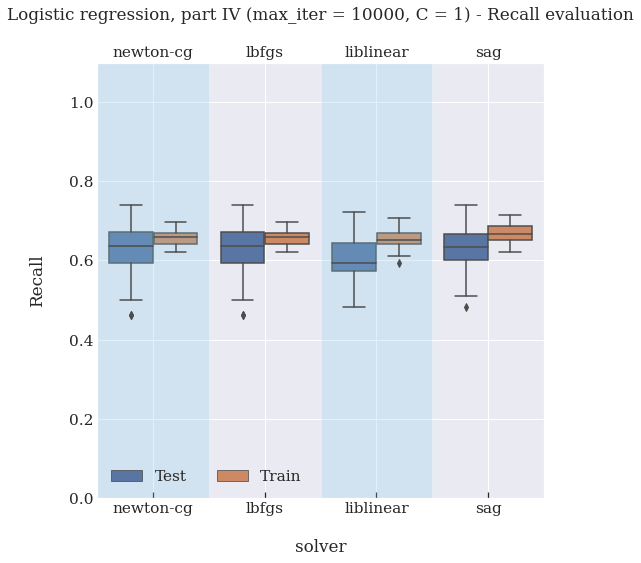

In [157]:
plotScoresGraph("Logistic regression, part IV (max_iter = 10000, C = 1)", logistic_regression_scores, "solver", "Recall")

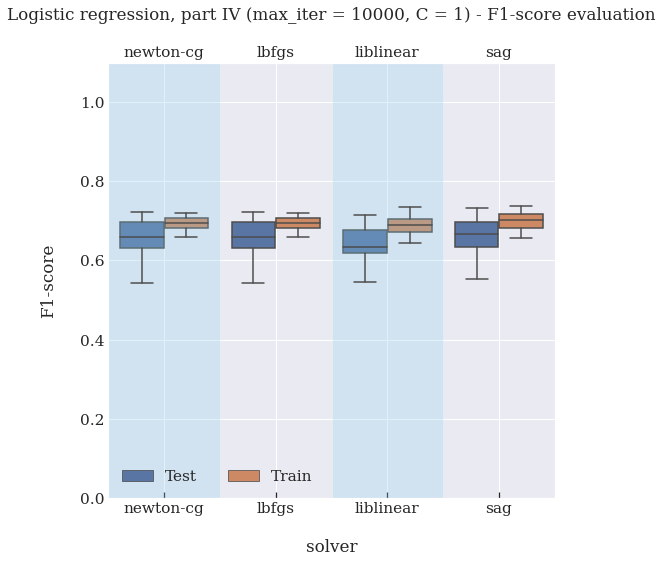

In [158]:
plotScoresGraph("Logistic regression, part IV (max_iter = 10000, C = 1)", logistic_regression_scores, "solver", "F1-score")

Vamos escolher solver = 'lbfgs' novamente.

In [159]:
logistic_regression_scores = getScores(fourth_approach_machine_learning, "LogisticRegression",
                                       "C",[0.01, 0.1, 1.0, 10, 100, 1000, 10000], max_iter=10000, solver= "'lbfgs'")

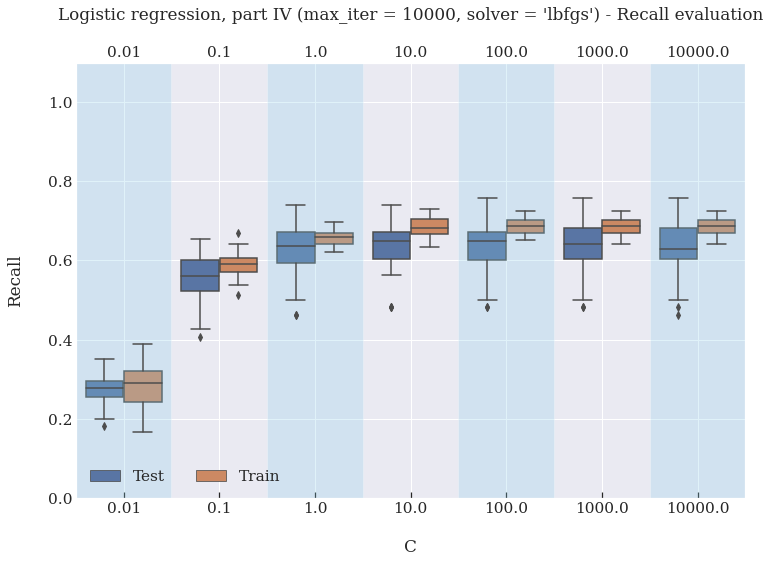

In [160]:
plotScoresGraph("Logistic regression, part IV (max_iter = 10000, solver = 'lbfgs')", logistic_regression_scores, "C", "Recall")

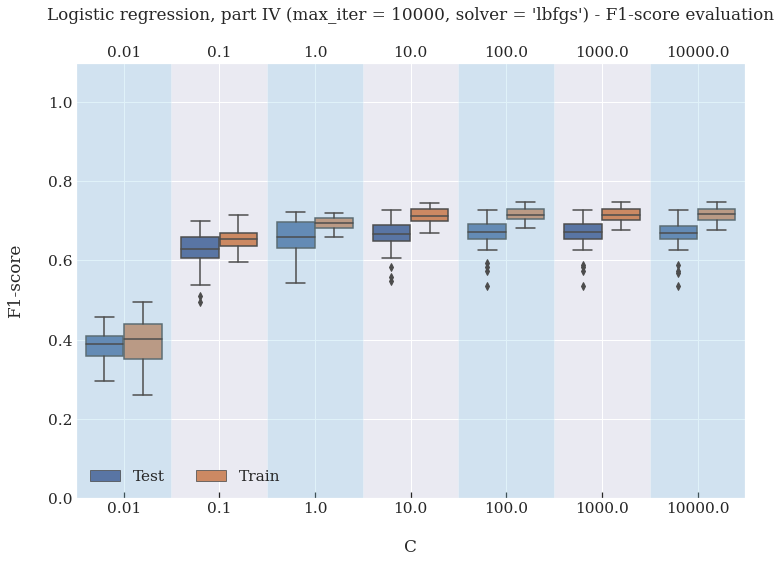

In [161]:
plotScoresGraph("Logistic regression, part IV (max_iter = 10000, solver = 'lbfgs')", logistic_regression_scores, "C", "F1-score")

Um desempenho ruim é observado para C = 0,01; continuamos avaliando este parâmetro entre 0,1 e 10.

In [162]:
logistic_regression_scores = getScores(fourth_approach_machine_learning, "LogisticRegression",
                                       "C",[0.1, 0.5, 1.0, 2, 3, 5, 10], max_iter=10000, solver= "'lbfgs'")

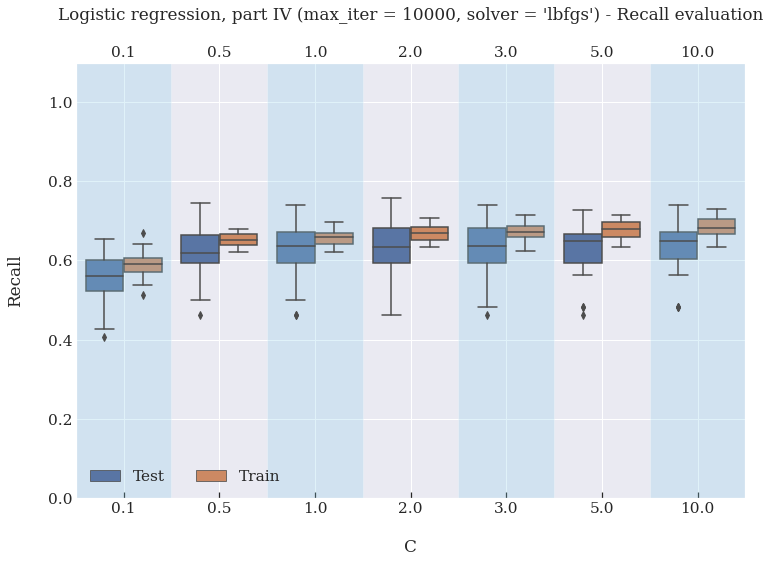

In [163]:
plotScoresGraph("Logistic regression, part IV (max_iter = 10000, solver = 'lbfgs')", logistic_regression_scores, "C", "Recall")

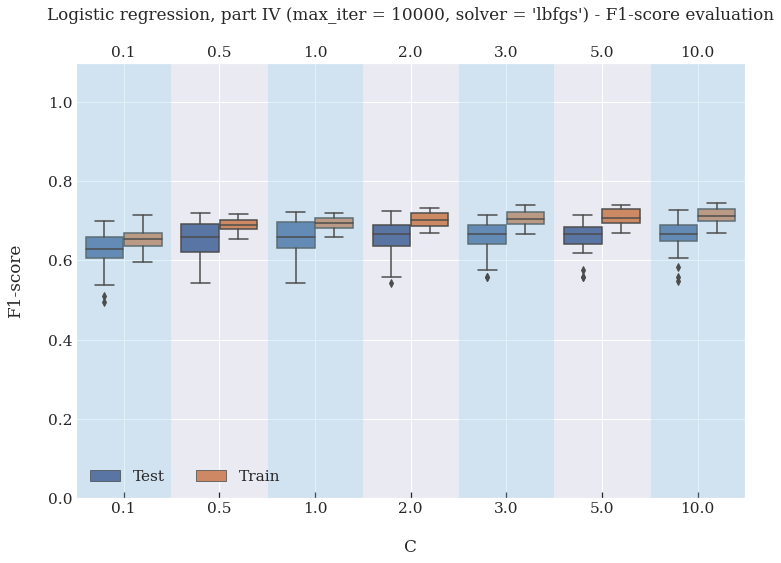

In [164]:
plotScoresGraph("Logistic regression, part IV (max_iter = 10000, solver = 'lbfgs')", logistic_regression_scores, "C", "F1-score")

Nota-se a presença de outliers inferiores para quase todos os valores de C testados.

Após analisar o desempenho com os diferentes hiperparâmetros, optou-se por solver = 'lbfgs' e C = 10; além disso, foi necessário definir max_iter = 10000 para convergir.

In [165]:
log_reg_clf = LogisticRegression(max_iter=10000, solver='lbfgs', C=10)

#### Desempenho dos modelos parte IV

Não melhoramos (e acabamos piorando) em relação à série estudada na parte III, quando fizemos as primeiras remoções de recursos.

Isso é vida, isso é ciência de dados. Nem sempre obtemos o melhor resultado depois de mais uma rodada de esforço comprometido. O importante é continuar a se empenhar e focar na melhor análise dentro do tempo disponível.

In [166]:
summary_partIV, scores_models_partIV = getSummaryScores(fourth_approach_machine_learning)

# to store the results
scores_models_partIV["part #"] = "part IV"
scores_models_full = pd.concat([scores_models_full, scores_models_partIV])

summary_partIV

Recall        F1-score       
                           mean    std     mean    std
                                                      
Random forest             0.674  0.059    0.697  0.042
Logistic regression       0.635  0.070    0.663  0.043
Decision tree classifier  0.593  0.067    0.612  0.054

### Identificação de vazamento de dados nas janelas da UTI

Agora vamos dar alguns passos para trás. Muitas vezes é necessário, em ciência de dados, olhar novamente para o banco de dados original e as primeiras manipulações realizadas; eventualmente, naquele momento, já imbuímos algum erro persistente no resto da análise.

Ao preencher os dados nulos, de volta ao EDA parte I, utilizando os dados das janelas vizinhas do próprio paciente, não foi tentado se o paciente, quando já na UTI, acabava não fornecendo dados para a janela 0-2 antes de ir para a UTI, que é a que a gente usa.

A seguinte série de códigos realiza o enchimento para frente (ffill) e para trás (bfill) apenas das janelas fora da UTI (= 0)

In [167]:
patient_list = data["PATIENT_VISIT_IDENTIFIER"]
df_uci = data.query("ICU == 1")

# primeiro, as linhas UCI = 1 são removidas
# então, é realizado preenchimento no groupby, obtendo de volta um dataframe sem identificador de paciente
# essa é a razão pela qual é necessário concatenar
df_without_uci_ffill = data.drop(data[data["ICU"] == 1].index).groupby("PATIENT_VISIT_IDENTIFIER", as_index=False).fillna(method="ffill")

# agora preciso concatenar as linhas com UTI e a colunas usuários para voltar ao df original
data_ffill = pd.concat([df_uci, df_without_uci_ffill], join="inner").sort_index()

# agora, é necessário concatenar novamente com as linhas
# que contém o identificador de visita do paciente
data_final_ffill = pd.concat([patient_list, data_ffill], axis=1)

# repita o processo para o bfill
# o problema de executar ffill e bfill na mesma linha, após o groupby,
# é porque o retorno do prim
df_without_uci_bfill = data_final_ffill.drop(data_final_ffill[data_final_ffill["ICU"] == 1]\
                                             .index).groupby("PATIENT_VISIT_IDENTIFIER", as_index=False)\
                                             .fillna(method="bfill")
                                             
data_bfill = pd.concat([df_uci, df_without_uci_bfill], join="inner").sort_index()
data_final = pd.concat([patient_list, data_bfill], axis=1)

Veja os dados do paciente abaixo; mesmo com o ffill e bfill já aplicados, notamos que ainda existem recursos com valores NaN para WINDOW 0-2 (role para a direita e observe os recursos TEMPERATURE_DIFF_REL e OXYGEN_SATURATION_DIFF_REL, por exemplo)

Observe também que esses valores nulos se referem às 2 primeiras janelas, quando o paciente ainda não havia sido transferido para a UTI, como aconteceu nas janelas 4-6 em diante.

Isso significa que usamos alguns valores de UTI em experimentos anteriores. Isso não é bom e é chamado de [vazamento de dados] (https://www.kaggle.com/dansbecker/data-leakage).

In [168]:
data_final[data_final["PATIENT_VISIT_IDENTIFIER"]==18]

,PATIENT_VISIT_IDENTIFIER,AGE_ABOVE65,AGE_PERCENTIL,GENDER,DISEASE GROUPING 1,DISEASE GROUPING 2,DISEASE GROUPING 3,DISEASE GROUPING 4,DISEASE GROUPING 5,DISEASE GROUPING 6,...,TEMPERATURE_DIFF,OXYGEN_SATURATION_DIFF,BLOODPRESSURE_DIASTOLIC_DIFF_REL,BLOODPRESSURE_SISTOLIC_DIFF_REL,HEART_RATE_DIFF_REL,RESPIRATORY_RATE_DIFF_REL,TEMPERATURE_DIFF_REL,OXYGEN_SATURATION_DIFF_REL,WINDOW,ICU
90,18,0,1,0,0.0,0.0,0.0,0.0,0.0,0.0,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0-2,0
91,18,0,1,0,0.0,0.0,0.0,0.0,0.0,0.0,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,2-4,0
92,18,0,1,0,0.0,0.0,0.0,0.0,0.0,0.0,...,-1.000000,-0.959596,-0.977316,-0.876606,-0.766327,-0.736774,-1.000000,-0.960463,4-6,1
93,18,0,1,0,0.0,0.0,0.0,0.0,0.0,0.0,...,-1.000000,-1.000000,-1.000000,-1.000000,-1.000000,-1.000000,-1.000000,-1.000000,6-12,1
94,18,0,1,0,0.0,0.0,0.0,0.0,0.0,0.0,...,-0.380952,-0.939394,-0.545780,-0.530096,-0.627689,0.096774,-0.379238,-0.939126,ABOVE_12,1


Vamos listar todos os pacientes que estão na mesma situação acima:

In [169]:
# lista de pacientes que contém valores nulos para WINDOW 0-2 após ffill e bfill
patient_with_null_values = data_final[data_final.isna().any(axis=1)].query("ICU == 0 and WINDOW=='0-2'").groupby("PATIENT_VISIT_IDENTIFIER").count().index
print(patient_with_null_values)

# o "-1" é para aquele paciente que foi retirado do estudo
# porque tinha dados categóricos com valores nulos, conforme explicado
# no final da EDA parte I
print(f"\ Existem {len (patient_with_null_values) - 1} pacientes com valores NaN para WINDOW 0-2 após ffill e bfill.")

Int64Index([ 18,  24,  28,  31,  40,  44,  52,  53,  55,  64,  69,  73,  77,
             79,  82,  84,  87, 100, 102, 103, 105, 116, 119, 120, 139, 141,
            142, 145, 148, 149, 155, 161, 191, 199, 215, 227, 234, 235, 252,
            255, 260, 263, 265, 267, 287, 288, 289, 291, 297, 316, 320, 325,
            339, 342, 347, 357, 364, 367, 372],
           dtype='int64', name='PATIENT_VISIT_IDENTIFIER')
\ Existem 58 pacientes com valores NaN para WINDOW 0-2 após ffill e bfill.


Existem estratégias possíveis para lidar com essa descoberta; o mais simples (e certamente mais caro no desempenho) é simplesmente livrar-se desses pacientes para a próxima rodada de treinamento e teste de preditor.

Devemos lembrar que este número (58) é muito alto considerando o total de 352 pacientes utilizados ao final do EDA parte I. É mais de 16% de todo o banco de dados e, pior, refere-se apenas àqueles pacientes que foram transferidos para a UTI em alguma janela de tempo.

Isso significa criar um grave desequilíbrio de classes no banco de dados, mas vamos tentar.

Como o melhor desempenho obtido até agora foi para modelos treinados com o banco de dados usado na parte III, contaremos com ele para descartar esses pacientes com valores NaN em WINDOW = 0-2.

In [171]:
fifth_approach_machine_learning = third_approach_machine_learning.copy().reset_index()
fifth_approach_machine_learning = fifth_approach_machine_learning.query("PATIENT_VISIT_IDENTIFIER not in @patient_with_null_values")
fifth_approach_machine_learning = fifth_approach_machine_learning.set_index("PATIENT_VISIT_IDENTIFIER")
print(f"Número de pacientes após a remoção: {fifth_approach_machine_learning.shape[0]}")

Número de pacientes após a remoção: 294


Com os 294 pacientes restantes, faremos o mesmo de antes: variar os hiperparâmetros e avaliar quais são os melhores para este conjunto de dados.

Novamente, comentários serão feitos somente após o término dos testes dos hiperparâmetros de cada preditor.

No final da série da parte V, o novo desempenho dos 3 preditores será apresentado.

#### Árvore de decisão parte V

In [172]:
decision_tree_scores = getScores(fifth_approach_machine_learning, "DecisionTreeClassifier","max_depth", range(1,16))

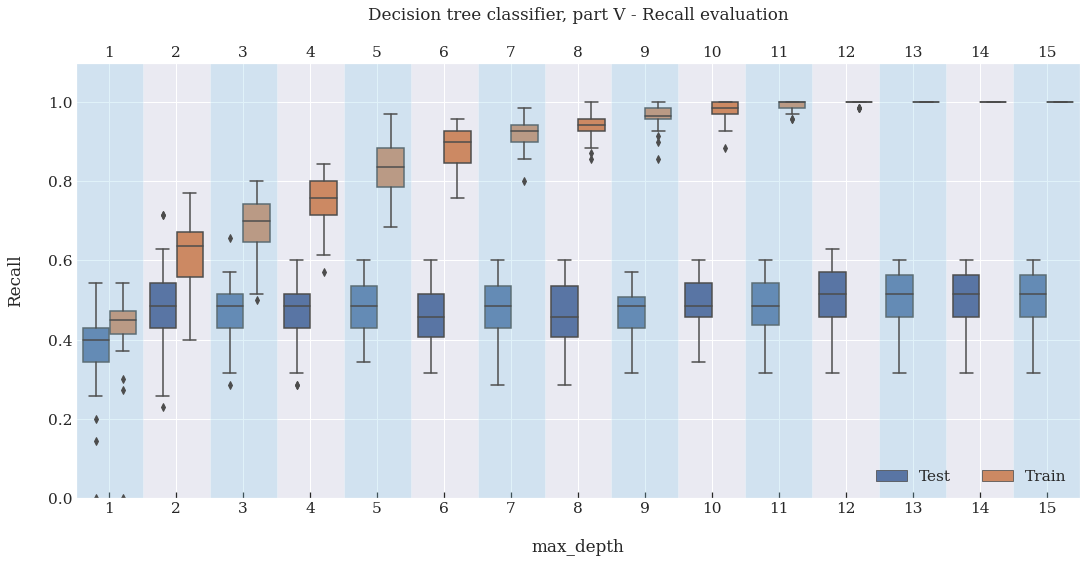

In [173]:
plotScoresGraph("Decision tree classifier, part V",decision_tree_scores, "max_depth", "Recall",legend_bottom_right=True)

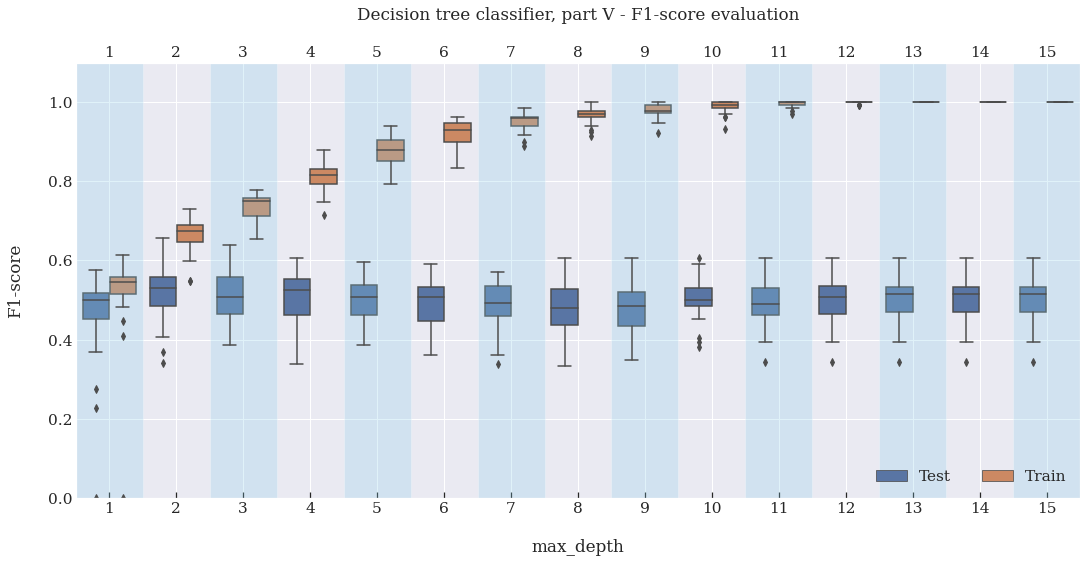

In [174]:
plotScoresGraph("Decision tree classifier, part V",decision_tree_scores, "max_depth", "F1-score",legend_bottom_right=True)

Podemos ver que o desempenho caiu consideravelmente.
Foi escolhido max_depth = 5.

In [175]:
tree_clf = DecisionTreeClassifier(max_depth=5)

#### Parte V aleatória da floresta

In [176]:
random_forest_scores = getScores(fifth_approach_machine_learning, "RandomForestClassifier","n_estimators",[10,30,50,100,150,200,300,400], max_depth=5)

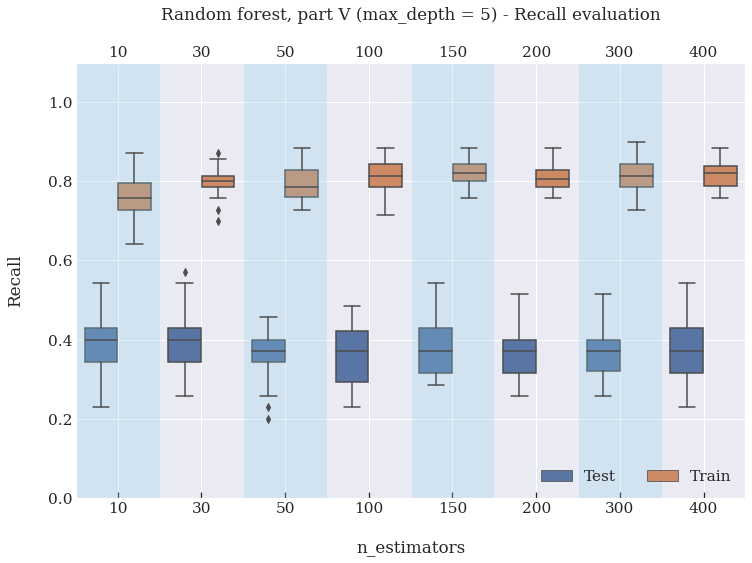

In [177]:
plotScoresGraph("Random forest, part V (max_depth = 5)",random_forest_scores, "n_estimators", "Recall",legend_bottom_right=True)

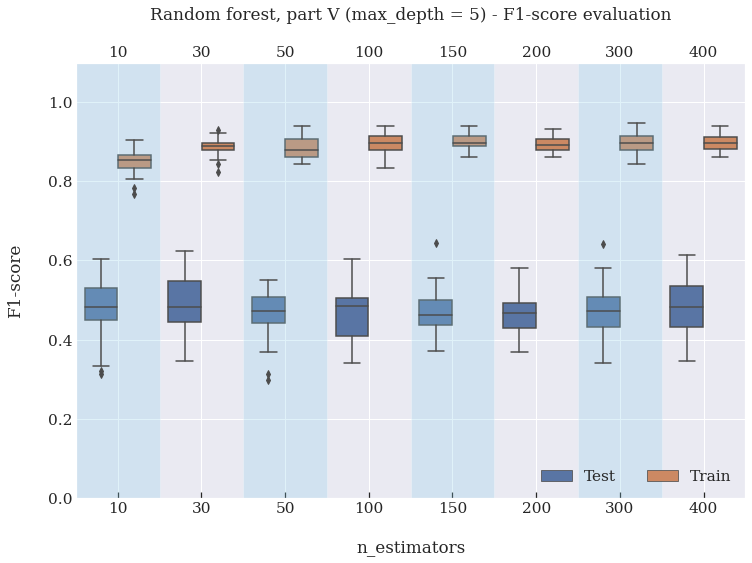

In [178]:
plotScoresGraph("Random forest, part V (max_depth = 5)",random_forest_scores, "n_estimators", "F1-score", legend_bottom_right=True)

In [179]:
random_forest_scores = getScores(fifth_approach_machine_learning, "RandomForestClassifier","max_depth",range(1, 21), n_estimators=10)

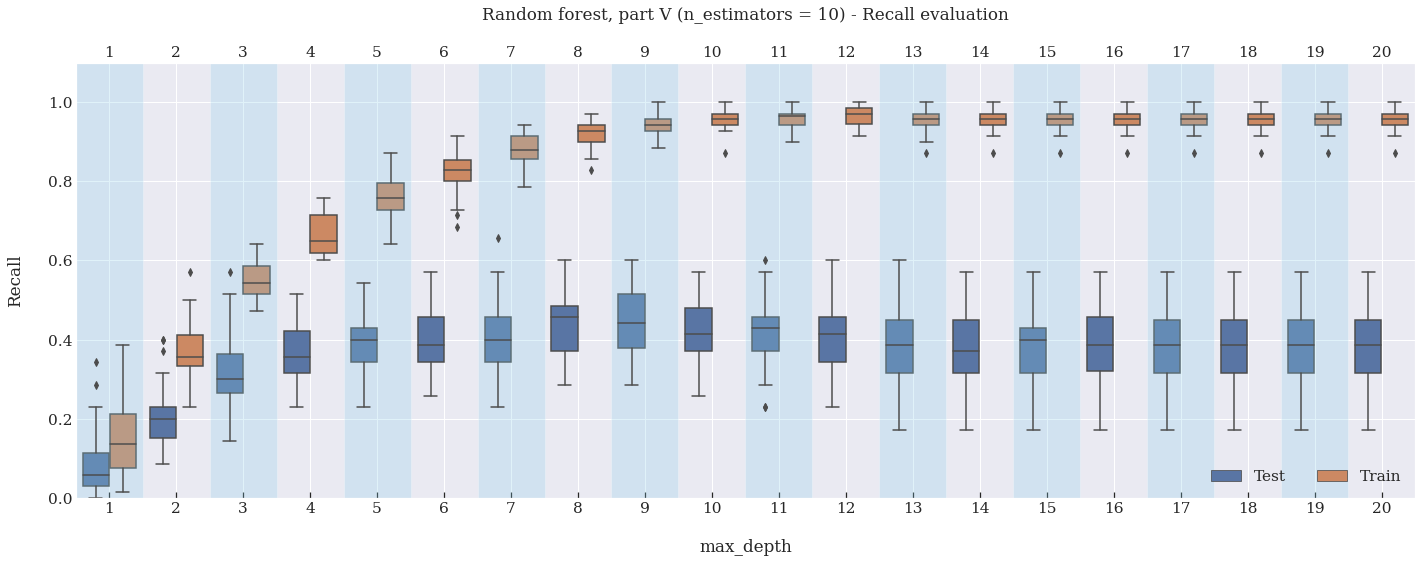

In [180]:
plotScoresGraph("Random forest, part V (n_estimators = 10)",random_forest_scores, "max_depth", "Recall", legend_bottom_right=True)

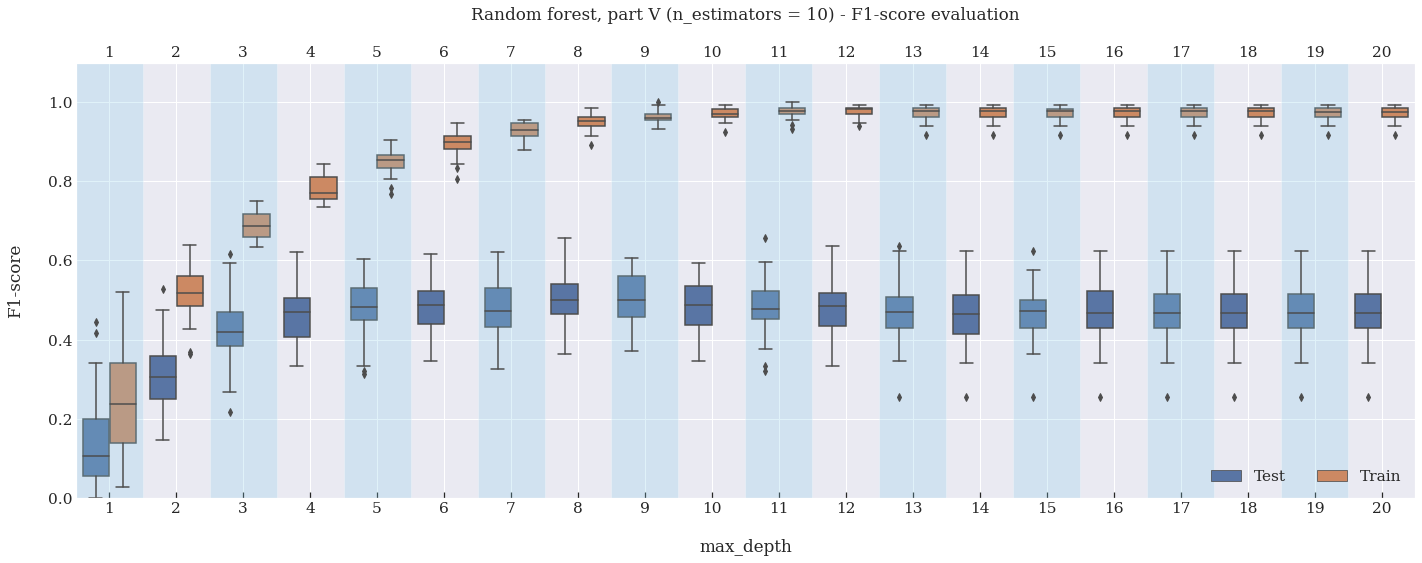

In [181]:
plotScoresGraph("Random forest, part V (n_estimators = 10)",random_forest_scores, "max_depth", "F1-score", legend_bottom_right=True)

O desempenho é realmente péssimo, em comparação com os modelos obtidos nas partes anteriores.

Foi escolhido n_estimators = 10 e max_depth = 8.

In [182]:
random_forest_clf = RandomForestClassifier(n_estimators=10, max_depth=8)

#### Regressão logística parte V

In [183]:
logistic_regression_scores = getScores(fifth_approach_machine_learning, "LogisticRegression","solver",['newton-cg', 'lbfgs', 'liblinear', 'sag'], max_iter=10000)


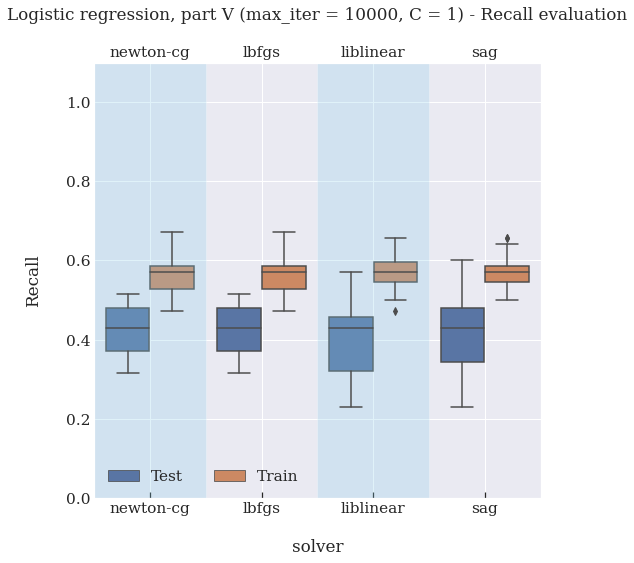

In [184]:
plotScoresGraph("Logistic regression, part V (max_iter = 10000, C = 1)", logistic_regression_scores, "solver", "Recall")


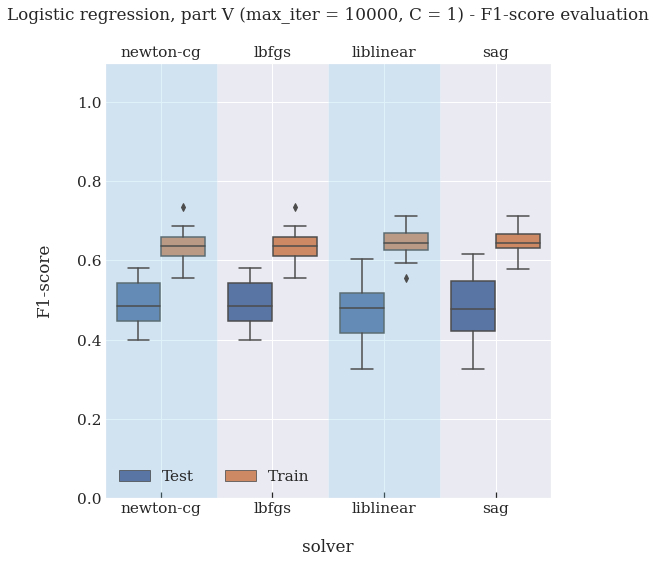

In [185]:
plotScoresGraph("Logistic regression, part V (max_iter = 10000, C = 1)", logistic_regression_scores, "solver", "F1-score")

Let's choose solver = 'lbfgs' again.

In [186]:
logistic_regression_scores = getScores(fifth_approach_machine_learning, 
                                       "LogisticRegression","C",[0.01, 0.1, 1.0, 10, 100, 1000, 10000], max_iter=10000, solver= "'lbfgs'")

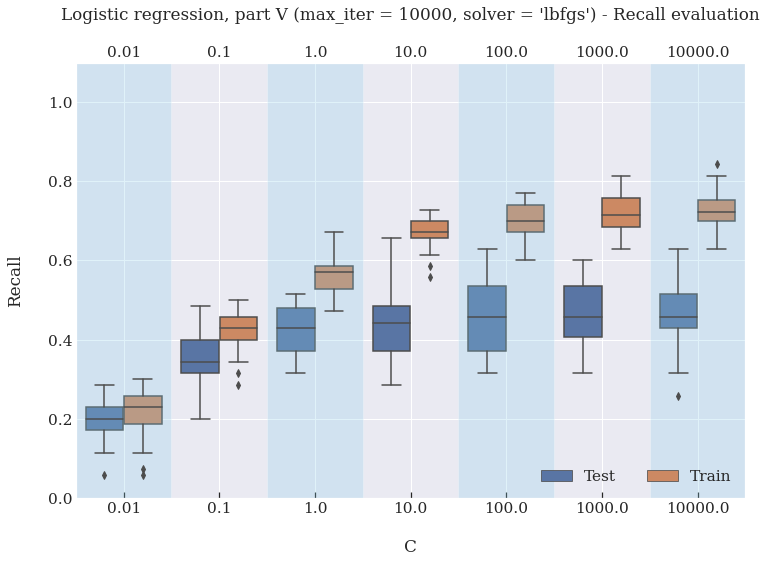

In [187]:
plotScoresGraph("Logistic regression, part V (max_iter = 10000, solver = 'lbfgs')", 
                logistic_regression_scores, "C", "Recall",legend_bottom_right=True)


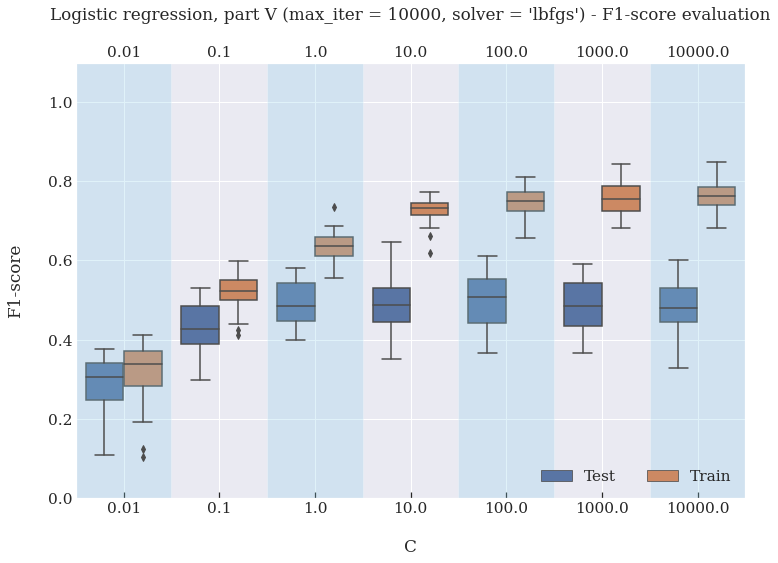

In [188]:
plotScoresGraph("Logistic regression, part V (max_iter = 10000, solver = 'lbfgs')", logistic_regression_scores, "C", "F1-score",legend_bottom_right=True)

Após analisar o desempenho com os diferentes hiperparâmetros, optou-se por solver = 'lbfgs' e C = 100; além disso, foi necessário definir max_iter = 10000 para convergir.

In [189]:
log_reg_clf = LogisticRegression(max_iter=10000, solver='lbfgs', C=100)

#### Desempenho dos modelos parte V

In [190]:
summary_partV, scores_models_partV = getSummaryScores(fifth_approach_machine_learning)

# to store the results
scores_models_partV["part #"] = "part V"
scores_models_full = pd.concat([scores_models_full, scores_models_partV])

summary_partV

Recall        F1-score       
                           mean    std     mean    std
                                                      
Decision tree classifier  0.478  0.071    0.499  0.051
Logistic regression       0.456  0.090    0.496  0.066
Random forest             0.447  0.084    0.508  0.070

Como já mencionado, o desempenho derreteu em comparação com os resultados obtidos anteriormente.

Compare o "antes" e o "depois" da remoção dos pacientes para o treinamento e teste da parte V.

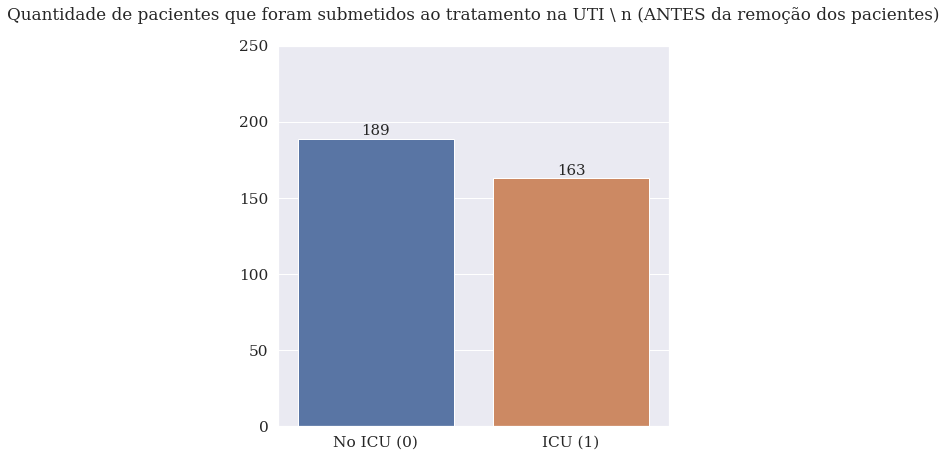

In [191]:
title = "Quantidade de pacientes que foram submetidos ao tratamento na UTI \ n (ANTES da remoção dos pacientes)"
plotGraph(data = first_approach_machine_learning.groupby("PATIENT_VISIT_IDENTIFIER").agg({"ANY_WINDOW_IN_ICU": max}), type = "bar", title = title, x="ANY_WINDOW_IN_ICU", y_limit=250, labels = True)

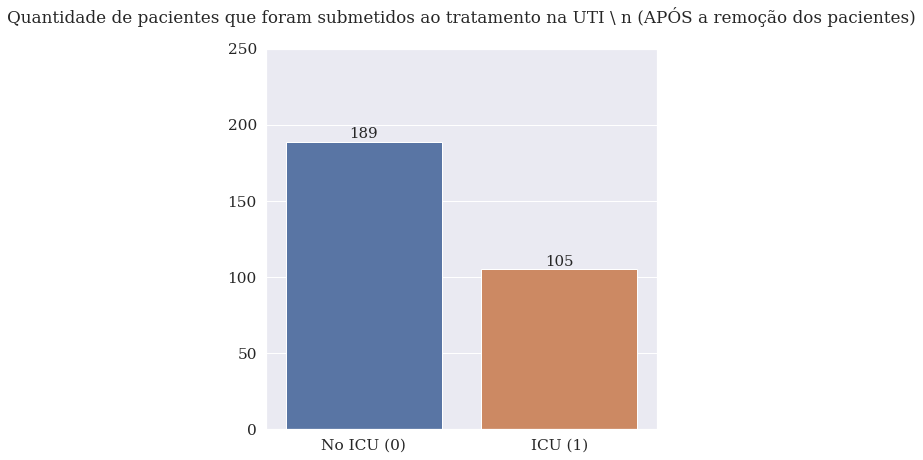

In [192]:
title = "Quantidade de pacientes que foram submetidos ao tratamento na UTI \ n (APÓS a remoção dos pacientes)"
plotGraph(data = fifth_approach_machine_learning.groupby("PATIENT_VISIT_IDENTIFIER").agg({"ANY_WINDOW_IN_ICU": max}), type = "bar", title = title, x="ANY_WINDOW_IN_ICU", y_limit=250, labels = True)

Perceba o impacto que um dado de desequilíbrio pode ter no modelo.

Agora suponha que os dados coletados já tenham sido obtidos de forma desequilibrada (por exemplo, para cada 5 pacientes que vão para a UTI, eu coleto dados para 2 e para cada 5 que não vão, eu coleto dados para 4).

Pense no impacto de colocar em produção o melhor modelo possível obtido após treiná-lo com esses dados desbalanceados já na coleção.

O critério de um cientista de dados deve ser alto em toda a cadeia de trabalho.

## Resumo de todos os desempenhos obtidos

A tabela abaixo mostra todos os desempenhos encontrados em todas as rodadas de treinamento / teste para os 3 preditores.

Não há desvio padrão para os modelos da parte I, pois apenas uma única previsão foi feita.

In [193]:
pd.pivot_table(scores_models_full, values=['Recall', 'F1-score'], index=['Model', 'part #'],
                          aggfunc={'Recall': [np.mean, np.std],
                                   'F1-score': [np.mean, np.std]}, fill_value=0).round(3).rename_axis(['',''])

F1-score        Recall       
                                      mean    std   mean    std
                                                               
Decision tree classifier part I      0.512  0.000  0.449  0.000
                         part II     0.616  0.056  0.592  0.088
                         part III    0.622  0.063  0.605  0.094
                         part IV     0.612  0.054  0.593  0.067
                         part V      0.499  0.051  0.478  0.071
Logistic regression      part I      0.543  0.000  0.510  0.000
                         part II     0.667  0.049  0.637  0.074
                         part III    0.671  0.045  0.643  0.067
                         part IV     0.663  0.043  0.635  0.070
                         part V      0.496  0.066  0.456  0.090
Random forest            part I      0.587  0.000  0.551  0.000
                         part II     0.684  0.041  0.660  0.056
                         part III    0.703  0.034  0.694  0.048
                         part IV     0.697  0.042  0.674  0.059
                         part V      0.508  0.070  0.447  0.084

Também podemos plotar os resultados:

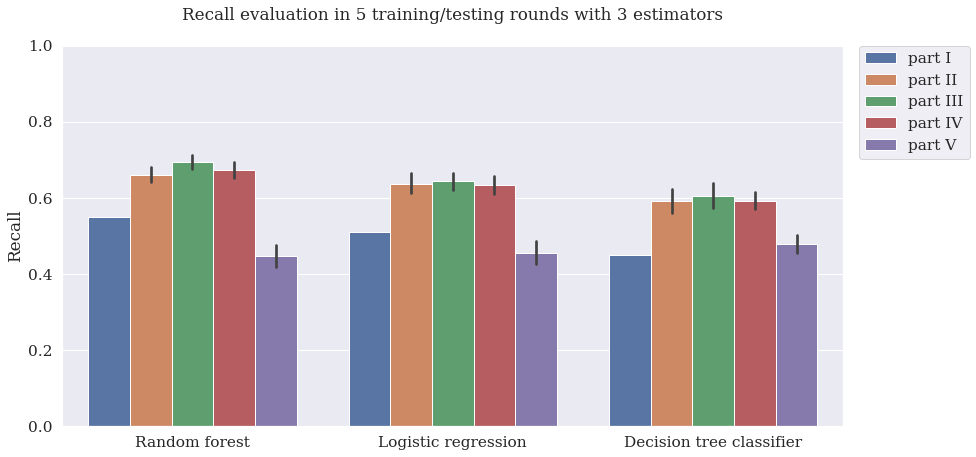

In [194]:
sns.set_theme(style = "darkgrid", font='serif', font_scale = 1.4)
ax = sns.barplot(data=scores_models_full, x="Model", y="Recall", hue="part #")
ax.figure.set_size_inches(14,7)
ax.set_title("Recall evaluation in 5 training/testing rounds with 3 estimators" + "\n")
ax.set(xlabel=None)
ax.set_ylim(0,1)

# Coloque a legenda fora do enredo
plt.legend(bbox_to_anchor=(1.02, 1), loc=2, borderaxespad=0.)
plt.show(ax)

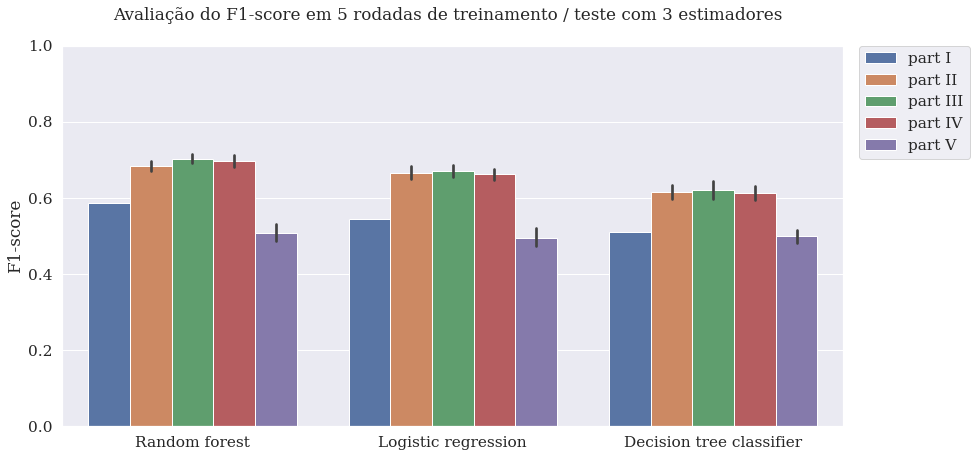

In [197]:
sns.set_theme(style = "darkgrid", font='serif', font_scale = 1.4)
ax = sns.barplot(data=scores_models_full, x="Model", y="F1-score", hue="part #")
ax.figure.set_size_inches(14,7)
ax.set_title("Avaliação do F1-score em 5 rodadas de treinamento / teste com 3 estimadores "+" \n ")
ax.set(xlabel=None)
ax.set_ylim(0,1)
plt.legend(bbox_to_anchor=(1.02, 1), loc=2, borderaxespad=0.)
plt.show(ax)

Aparentemente, o melhor modelo foi Random Forest, treinada na parte III.
Também notamos que o Random Forest sempre teve um desempenho melhor do que o classificador da árvore de decisão (exceto na parte V, que foi um desastre para todos os modelos).

# Propostas de trabalhos futuros e melhorias

- Modificar a estratégia utilizada após detectar a ocorrência de vazamento de dados;
   - tente manter a maioria dos pacientes onde isso ocorre, selecionando cuidadosamente os recursos onde não há vazamento;
   - tentar manter a distribuição original das classes, retirando aleatoriamente os pacientes que não vão à UTI;

- Estudar e variar outros hiperparâmetros nos três estimadores estudados;

- Melhor retrabalho a seleção de recursos usando métodos diferentes dos apresentados neste trabalho;

- Avalie outros estimadores de classificação, como [Nearest Neighbours] (https://scikit-learn.org/stable/modules/neighs.html), [Support Vector Machines] (https://scikit-learn.org/stable/ modules / svm.html # classificação) e [XGBoost] (https://xgboost.readthedocs.io/en/latest/index.html);

- Finalmente, devido ao notável aumento na complexidade, estude e desenvolva um [pipeline] (https://scikit-learn.org/stable/modules/generated/sklearn.pipeline.Pipeline.html#sklearn.pipeline.Pipeline) como uma etapa de pré-processamento antes de fazer o aprendizado do modelo.

# Conclusões

- Como será visto ao longo deste trabalho, faz parte da vida do cientista de dados iterar entre a análise exploratória dos dados, o tratamento do banco de dados, as modificações dos hiperparâmetros dos estimadores, o treinamento do modelo e o teste;

- Foi realizada uma extensa análise exploratória dos dados, o que resultou na eliminação de alguns dados que comprometeriam a qualidade dos modelos;

- Uma primeira rodada de aprendizado de máquina foi realizada para 3 estimadores diferentes: classificador de árvore de decisão, floresta aleatória e regressão logística; concluiu-se, no entanto, que a realização de tais previsões nada representou, sendo um mero produto da sorte;

- Para apoiar uma avaliação real do modelo, a validação cruzada foi apresentada e realizada para outras 4 rodadas de treinamento e teste.

- Além da validação cruzada, alguns hiperparâmetros também foram variados e testados para os 3 diferentes estimadores mencionados acima; a diferença no poder preditivo, em geral, variou consideravelmente com a variação do hiperparâmetro;

- O melhor estimador, para as análises realizadas neste trabalho, foi a floresta aleatória, seguida da regressão logística;

- Percebeu-se um aumento considerável no desempenho de todos os estimadores ao reduzir o número de colunas (features) do banco de dados que estavam duplicadas e altamente correlacionadas entre si; entretanto, ao exagerar a dose e remover mais recursos, negamos os benefícios obtidos anteriormente;

- Foi diagnosticado que na base de dados tratada inicialmente havia vazamento de dados que poderia estar impactando a capacidade preditiva dos modelos; uma nova rodada de testes foi realizada, mas não houve sucesso na melhoria do desempenho obtido anteriormente;

- O fracasso desta tentativa, no entanto, resultou na reflexão e consideração do impacto na análise de classificação quando a coleta e disponibilização de dados já é realizada de forma desequilibrada desde o início do trabalho.

- Os próximos passos e estratégias foram discutidos na tentativa de melhorar o desempenho preditivo dos estimadores.